In [ ]:
##### from __future__ import division
import sys
from ipyparallel import Client
import os, time
import pandas as pd
import numpy as np
import scipy as sp
from fractions import Fraction
from collections import defaultdict, OrderedDict, Counter
import vcf
import random
from geopy.distance import vincenty
import math
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
%matplotlib inline
from os import path as op
from os import listdir as ls
import shutil
from scipy.stats import hmean
from skbio.stats.distance import mantel

# Make SNPSFILE

In [13]:
stpDF = pd.read_csv('/home/lindb/wbp/sampsTOpop.txt',header=0,sep="\t")
stpDF.head()

,sampID,pop,plot
0,028compiled,Dicks_Pass,3
1,024compiled,Dicks_Pass,2
2,020compiled,Dicks_Pass,2
3,025compiled,Dicks_Pass,2
4,023compiled,Dicks_Pass,2


In [14]:
pops = np.unique(stpDF['pop']).tolist()

In [17]:
popDict = OrderedDict()
for row in stpDF.index:
    pop = stpDF.loc[row,'pop']
    samp = stpDF.loc[row,'sampID']
    if not pop in popDict.keys():
        popDict[pop] = []
    popDict[pop].append(samp)
for pop in popDict.keys():
    print pop,len(popDict[pop])

Dicks_Pass 25
Freel_Peak 48
Little_Round_Top 25
Heavenly 25
Mt_Rose_Ophir 49
Rifle_Peak 24
Snow_Valley_Peak 24
West_Shore_Peaks 24


In [315]:
%time data = pd.read_csv('/home/lindb/wbp/bayenv2/imputed_z12_maf_swp_trans_z12.txt',header=0,index_col=0,sep="\t")

CPU times: user 56.2 s, sys: 592 ms, total: 56.8 s
Wall time: 56.8 s


In [253]:
data.head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,1,1,0,0,0,1
010compiled,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
011compiled,1,0,1,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
012compiled,0,0,0,1,0,0,1,0,1,0,...,0,1,2,0,1,0,0,0,1,1
013compiled,2,0,0,0,0,0,1,1,1,0,...,0,0,1,0,1,0,0,0,0,1


In [57]:
len(data.columns)

116231

In [64]:
len(data.index)

244

In [60]:
popDictImp = OrderedDict()
for pop in sorted(pops):
    popDictImp[pop]  = data[data.index.isin(popDict[pop])]

In [107]:
total  = 0
for pop in popDictImp.keys():
    print pop, len(popDictImp[pop])
    total = total + len(popDictImp[pop])
print total

Dicks_Pass 25
Freel_Peak 48
Heavenly 25
Little_Round_Top 25
Mt_Rose_Ophir 49
Rifle_Peak 24
Snow_Valley_Peak 24
West_Shore_Peaks 24
244


In [76]:
popDictImp['Dicks_Pass']['NODE_1000013_length_91_cov_1.802198_37'].tolist().count(0)

20

In [254]:
#just a test
locCount = 0
bayDict = OrderedDict()
for locus in data.columns:
    bayDict[locus] = OrderedDict()
    popCount = 0
    for pop in sorted(pops):
        
        zero = popDictImp[pop][locus].tolist().count(0) #count the first homozygotes
        one = popDictImp[pop][locus].tolist().count(1) #count the heterozygotes
        two = popDictImp[pop][locus].tolist().count(2) #count the second homozygotes        
        
        A1 = 2*zero + one #count of global major allele
        A2 = 2*two + one #count of global minor allele
        
        if len(bayDict[locus].keys()) == 0:
            bayDict[locus]['A1'] = OrderedDict()
            bayDict[locus]['A2'] = OrderedDict()
        bayDict[locus]['A1'][pop] = A1
        bayDict[locus]['A2'][pop] = A2
        #break
    locCount += 1
    if locCount % 10 == 0:
        print locCount
        break 
    #break

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.9 µs
10


In [255]:
for locus in bayDict.keys():
    count = 0
    for allele in bayDict[locus].keys():
        for pop in bayDict[locus][allele].keys():
            count = count + bayDict[locus][allele][pop]
    print count

488
488
488
488
488
488
488
488
488
488


In [256]:
#make sure allele counts are correct
filE = '/home/lindb/wbp/bayenv2/testUnbinnedImputedSNPSFILE.txt'
with open(filE, 'w') as o:
    line = '\t'.join([str(pop) for pop in bayDict[bayDict.keys()[0]][bayDict[bayDict.keys()[0]].keys()[0]].keys()]) + str('\n')
    o.write("%s" % line)
    for locus in bayDict.keys():
        for allele in bayDict[locus].keys():
            line = str(locus) + '\t' + '\t'.join([str(x) for x in bayDict[locus][allele].values()]) + str('\n')
            #print locus,allele,line
            o.write("%s" % line)

In [99]:
#because it's way faster this way
text = '''from __future__ import division
import sys
from ipyparallel import Client
import os, time
import pandas as pd
import numpy as np
import scipy as sp
from fractions import Fraction
from collections import defaultdict, OrderedDict
import vcf
import random

filE1 = '/home/lindb/wbp/bayenv2/update.txt'
with open(filE1,'w') as o:
    text = 'reading stpDF\\n'
    o.write("%s" % text)
    
stpDF = pd.read_csv('/home/lindb/wbp/sampsTOpop.txt',header=0,sep="\\t")

pops = np.unique(stpDF['pop']).tolist()

popDict = OrderedDict()
for row in stpDF.index:
    pop = stpDF.loc[row,'pop']
    samp = stpDF.loc[row,'sampID']
    if not pop in popDict.keys():
        popDict[pop] = []
    popDict[pop].append(samp)

with open(filE1,'a') as o:
    text = 'reading data\\n'
    o.write("%s" % text)
    
data = pd.read_csv('/home/lindb/wbp/bayenv2/imputed_z12_maf_swp_trans_z12.txt',header=0,index_col=0,sep="\\t")

popDictImp = OrderedDict()
for pop in sorted(pops):
    popDictImp[pop]  = data[data.index.isin(popDict[pop])]
    
with open(filE1,'a') as o:
    text = 'iterating loci\\n'
    o.write("%s" % text)

locCount = 0
bayDict = OrderedDict()
for locus in data.columns:
    bayDict[locus] = OrderedDict()
    popCount = 0
    for pop in sorted(pops):
        
        zero = popDictImp[pop][locus].tolist().count(0) #count the first homozygotes
        one = popDictImp[pop][locus].tolist().count(1) #count the heterozygotes
        two = popDictImp[pop][locus].tolist().count(2) #count the second homozygotes        
        
        A1 = 2*zero + one
        A2 = 2*two + one
        
        if len(bayDict[locus].keys()) == 0:
            bayDict[locus]['A1'] = OrderedDict()
            bayDict[locus]['A2'] = OrderedDict()
        bayDict[locus]['A1'][pop] = A1
        bayDict[locus]['A2'][pop] = A2
        #break
    locCount += 1
    if locCount % 1000 == 0:
        print locCount
        with open(filE1,'a') as o:
            text = "%s\\n" % str(locCount)
            o.write("%s" % text)
        #break
    #break

filE = '/home/lindb/wbp/bayenv2/UnbinnedImputedSNPSFILE.txt'
with open(filE, 'w') as o:
    line = '\\t'.join([str(pop) for pop in bayDict[bayDict.keys()[0]][bayDict[bayDict.keys()[0]].keys()[0]].keys()]) + str('\\n')
    o.write("%s" % line)
    for locus in bayDict.keys():
        for allele in bayDict[locus].keys():
            line = str(locus) + '\\t' + '\\t'.join([str(x) for x in bayDict[locus][allele].values()]) + str('\\n')
            #print locus,allele,line
            o.write("%s" % line)
with open(filE1,'a') as o:
    text = 'Done!\\n'
    o.write("%s" % text)

'''

In [100]:
filE = '/home/lindb/wbp/bayenv2/get_SNPSFILE.py'
with open(filE,'w') as o:
    o.write("%s" % text)

In [101]:
shtext = '''#!/bin/bash
#$ -N snpsfile
#$ -V
#$ -j y
#$ -cwd

cd /home/lindb/wbp/bayenv2/
python get_SNPSFILE.py

'''
filE = '/home/lindb/wbp/bayenv2/get_SNPSFILE.sh'
with open(filE,'w') as o:
    o.write("%s" % shtext)

In [102]:
!qsub /home/lindb/wbp/bayenv2/get_SNPSFILE.sh

In [108]:
impbayenv = pd.read_csv('/home/lindb/wbp/bayenv2/UnbinnedImputedSNPSFILE.txt',header=0,index_col=0,sep="\t")
impbayenv.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
NODE_1000013_length_91_cov_1.802198_37,43,91,43,42,87,42,41,40
NODE_1000013_length_91_cov_1.802198_37,7,5,7,8,11,6,7,8
NODE_1000031_length_98_cov_2.000000_30,37,86,41,40,90,42,41,37
NODE_1000031_length_98_cov_2.000000_30,13,10,9,10,8,6,7,11
NODE_1000037_length_93_cov_2.043011_33,46,85,43,42,88,42,40,42


In [109]:
impbayenv.to_csv('/home/lindb/wbp/bayenv2/UnbinnedImputedSNPSFILE_NOHEADERIDX.txt',header=False,index=False,sep="\t")

# estimate MATRIXFILE

In [210]:
import random

In [213]:
random.randint(100,100000)

63122

In [215]:
shtext = '''#!/bin/bash
#$ -N matrixfile
#$ -V
#$ -j y
#$ -cwd

cd /home/lindb/wbp/bayenv2/
./bayenv2 -i UnbinnedImputedSNPSFILE_NOHEADERIDX.txt -p 8 -k 100000 -r %d > matrix.out

''' % random.randint(100,100000)
filE = '/home/lindb/wbp/bayenv2/get_MATRIXFILE.sh'
with open(filE,'w') as o:
    o.write("%s" % shtext)

In [249]:
!qsub /home/lindb/wbp/bayenv2/get_MATRIXFILE.sh

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
Your job 1418920 ("matrixfile") has been submitted


# make ENVIRONFILE

In [69]:
test = pd.read_csv('/home/lindb/wbp/WBP_IDS_MATCHED_POP_FINAL_02162016.csv',header=0,sep="\t")
test.head()

,ID,UCD_ID,Population_ID,Plot_id,pop_plot_m,Duplicate,tag_id,fam_id,lon,lat,...,ht_pop,bf_pop,rs_pop,c13_pop,n15_pop,ht_fam,bf_fam,rs_fam,c13_fam,n15_fam
0,028compiled,WBP0028,Dicks_Pass,3,Dicks_Pass3,NDUP,2180,DP100,-120.134729,38.911685,...,4.069880,116.365805,2.470894,-31.042967,21.668347,4.370406,117.503196,2.564821,-30.944199,21.744727
1,024compiled,WBP0024,Dicks_Pass,2,Dicks_Pass2,NDUP,1878,DP101,-120.130955,38.910358,...,4.188304,118.967882,2.589387,-31.007308,21.457787,4.434397,118.830903,2.625141,-30.932084,21.621277
2,020compiled,WBP0020,Dicks_Pass,2,Dicks_Pass2,NDUP,1893,DP102,-120.130955,38.910358,...,4.651279,108.185118,2.518880,-31.161449,19.862602,4.686165,113.339703,2.589155,-31.011809,20.797976
3,025compiled,WBP0025,Dicks_Pass,2,Dicks_Pass2,NDUP,1889,DP103,-120.130955,38.910358,...,4.507014,119.125510,2.474552,-30.724324,22.608675,4.622005,118.957183,2.557041,-30.779590,22.230761
4,023compiled,WBP0023,Dicks_Pass,2,Dicks_Pass2,NDUP,1901,DP104,-120.130955,38.910358,...,4.839617,118.849584,2.659597,-30.919382,24.572579,4.795414,118.811803,2.658050,-30.886640,23.240264


In [196]:
len(test.columns[10:-11])

16

In [246]:
test.columns

Index([u'ID', u'UCD_ID', u'Population_ID', u'Plot_id', u'pop_plot_m',
       u'Duplicate', u'tag_id', u'fam_id', u'lon', u'lat', u'Elev',
       u'pmax_rad_input', u'prock-cov', u'Tmax-July', u'Tmin-Jan', u'Ann-ppt',
       u'GDD-May', u'GDD-Aug', u'WC3rdbar', u'WC15Bar', u'Silt', u'Sand',
       u'Clay', u'AWS0-50', u'AWS0-25', u'CEC', u'parent_material', u'ht_pop',
       u'bf_pop', u'rs_pop', u'c13_pop', u'n15_pop', u'ht_fam', u'bf_fam',
       u'rs_fam', u'c13_fam', u'n15_fam'],
      dtype='object')

In [219]:
test.columns[8:-11]

Index([u'lon', u'lat', u'Elev', u'pmax_rad_input', u'prock-cov', u'Tmax-July',
       u'Tmin-Jan', u'Ann-ppt', u'GDD-May', u'GDD-Aug', u'WC3rdbar',
       u'WC15Bar', u'Silt', u'Sand', u'Clay', u'AWS0-50', u'AWS0-25', u'CEC'],
      dtype='object')

In [399]:
envdf = pd.DataFrame(data=[],columns=sorted(pops))
envCount = 0
for col in test.columns[8:-11]: #for each environmental variable
    popMeans = [] #I'm averaging over the plots to get one measurement per population
    for pop in sorted(pops): #for each population
        data = test[test['Population_ID']==pop] # grab all data for samples in that pop
        popMean = np.mean(np.unique([x for x in data[col] if math.isnan(x) == False]).tolist())
        popMeans.append(popMean)

    mean = np.mean([float(x) for x in popMeans])
    std = np.std([float(x) for x in popMeans])
    est = [((x-mean)/(std)) for i,x in enumerate(popMeans)]
    envdf.loc[envCount,] = est
    envCount += 1
envdf.index = test.columns[8:-11]
envdf.sort_index(inplace=True)
envdf

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
AWS0-25,-0.20357,-0.38938,-1.38401,0.474087,0.430367,0.299207,1.98242,-1.20913
AWS0-50,-0.0353487,-0.578405,-1.1565,0.239933,-0.0303436,0.510211,2.17692,-1.12647
Ann-ppt,1.62149,-0.620322,-1.41689,0.0586081,-0.0590282,0.26027,-1.12448,1.28035
CEC,-0.519958,-0.162005,-0.519958,2.56585,0.195949,-0.519958,-0.519958,-0.519958
Clay,-0.111761,-0.739189,-0.0490178,2.42932,-1.20976,-0.0333321,-0.0176464,-0.268618
Elev,-0.00384825,1.07366,0.821217,1.27069,-1.65398,0.223968,-1.23529,-0.496424
GDD-Aug,0.934437,-1.78628,0.442116,-1.24214,0.960348,-0.620259,0.778967,0.532807
GDD-May,-0.649369,-0.649369,0.949078,-0.649369,2.28112,-0.649369,-0.249757,-0.382961
Sand,-0.108508,1.00028,0.529776,-1.36319,1.30666,-0.509715,-1.54921,0.693906
Silt,0.188186,-0.940932,-0.662137,0.648198,-1.12215,0.662137,1.98641,-0.759716


In [400]:
#rename them for usage
envdf.index = ['AWS0-25',
 'AWS0-50',
 'Ann-ppt',
 'CEC',
 'Clay',
 'Elev',
 'GDD-Aug',
 'GDD-May',
 'Sand',
 'Silt',
 'Tmax-July',
 'Tmin-Jan',
 'WC15Bar',
 'WC3rdbar',
 'Lat',
 'Lon',
 'Max-rad-input',
 'Rock-cov']

In [401]:
envdf[''] = ""
envdf.sort_index(inplace=True)
envdf

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks,
AWS0-25,-0.20357,-0.38938,-1.38401,0.474087,0.430367,0.299207,1.98242,-1.20913,
AWS0-50,-0.0353487,-0.578405,-1.1565,0.239933,-0.0303436,0.510211,2.17692,-1.12647,
Ann-ppt,1.62149,-0.620322,-1.41689,0.0586081,-0.0590282,0.26027,-1.12448,1.28035,
CEC,-0.519958,-0.162005,-0.519958,2.56585,0.195949,-0.519958,-0.519958,-0.519958,
Clay,-0.111761,-0.739189,-0.0490178,2.42932,-1.20976,-0.0333321,-0.0176464,-0.268618,
Elev,-0.00384825,1.07366,0.821217,1.27069,-1.65398,0.223968,-1.23529,-0.496424,
GDD-Aug,0.934437,-1.78628,0.442116,-1.24214,0.960348,-0.620259,0.778967,0.532807,
GDD-May,-0.649369,-0.649369,0.949078,-0.649369,2.28112,-0.649369,-0.249757,-0.382961,
Lat,-0.57621,-0.851775,-0.428441,-1.47345,1.43108,1.39822,0.729649,-0.229072,
Lon,-1.51192,0.796321,0.849157,-0.68273,0.861823,0.0543768,1.0574,-1.42443,


In [356]:
envdf.to_csv('/home/lindb/wbp/bayenv2/ENVIRONFILE.txt',header=False,index=False,sep="\t")

In [357]:
envdf.to_csv('/home/lindb/wbp/bayenv2/ENVIRONFILE_headerIDX.txt',header=True,index=True,sep="\t")

In [355]:
envdf.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
AWS0-25,-0.203570,-0.389380,-1.384005,0.474087,0.430367,0.299207,1.982420,-1.209126
AWS0-50,-0.035349,-0.578405,-1.156498,0.239933,-0.030344,0.510211,2.176919,-1.126467
Ann-ppt,1.621491,-0.620322,-1.416888,0.058608,-0.059028,0.260270,-1.124478,1.280346
CEC,-0.519958,-0.162005,-0.519958,2.565848,0.195949,-0.519958,-0.519958,-0.519958
Clay,-0.111761,-0.739189,-0.049018,2.429323,-1.209760,-0.033332,-0.017646,-0.268618


# make usable matrix file

In [404]:
matrixfile = open('/home/lindb/wbp/bayenv2/matrix.out')
r = matrixfile.readlines()
usable = '/home/lindb/wbp/bayenv2/usable_matrix.txt'
with open(usable,'w') as o:
    for line in r[2005:][:-1]:
        o.write(line)

In [408]:
umat = pd.read_csv(usable,header=None,sep="\t")
umat.shape

(8, 9)

In [421]:
umat.loc[:,:7].to_csv(usable,header=False,index=False,sep="\t")

In [423]:
umat = umat.loc[:,:7]
umat.shape

(8, 8)

# make bayenv .sh files - 1st chain

In [106]:
#we did a runthrough once (code in this section) and found that one chain isn't enough and can give spurious results 
    #depending on the seed given
#below this section here we've written code to do the remaining 4 chains

In [3]:
import shutil

In [4]:
snpdir = '/home/lindb/wbp/bayenv2/snps/'
if not os.path.exists(snpdir):
    os.makedirs(snpdir)
    shutil.copy('/home/lindb/wbp/bayenv2/bayenv2',os.path.join(snpdir,'bayenv2'))
    shutil.copy('/home/lindb/wbp/bayenv2/ENVIRONFILE.txt',os.path.join(snpdir,'ENVIRONFILE.txt'))
    shutil.copy('/home/lindb/wbp/bayenv2/UnbinnedImputedSNPSFILE_NOHEADERIDX.txt',
                os.path.join(snpdir,'UnbinnedImputedSNPSFILE_NOHEADERIDX.txt'))
    shutil.copy('/home/lindb/wbp/bayenv2/usable_matrix.txt',os.path.join(snpdir,'usable_matrix.txt'))

In [5]:
snpsfile = pd.read_csv('/home/lindb/wbp/bayenv2/UnbinnedImputedSNPSFILE.txt',header=0,index_col=0,sep="\t")
snpsfile.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
NODE_1000013_length_91_cov_1.802198_37,43,91,43,42,87,42,41,40
NODE_1000013_length_91_cov_1.802198_37,7,5,7,8,11,6,7,8
NODE_1000031_length_98_cov_2.000000_30,37,86,41,40,90,42,41,37
NODE_1000031_length_98_cov_2.000000_30,13,10,9,10,8,6,7,11
NODE_1000037_length_93_cov_2.043011_33,46,85,43,42,88,42,40,42


In [21]:
#make SNPFILEs by using the SNP as the name of the file - will be easier reading the bf.environ.ENVIRONFILE.txt
df = snpsfile
for j in range(0,len(df.index),2):
    DF = df.loc[df.index[j],:]
    dfile = os.path.join(snpdir,df.index[j])
    DF.to_csv(dfile,header=False,index=False,sep="\t")

In [6]:
bayenv = os.listdir(snpdir)
bayenv = sorted([os.path.join(snpdir,f) for f in bayenv if 'NODE' in f])
len(bayenv)

116231

In [7]:
bayenv_jobs = 190

In [8]:
num_chunks = int(np.round(len(bayenv)/bayenv_jobs))

In [9]:
num_chunks

612

In [10]:
chunks=[bayenv[x:x+num_chunks] for x in range(0, len(bayenv), num_chunks)]
chunks[0]

['/home/lindb/wbp/bayenv2/snps/NODE_1000013_length_91_cov_1.802198_37',
 '/home/lindb/wbp/bayenv2/snps/NODE_1000031_length_98_cov_2.000000_30',
 '/home/lindb/wbp/bayenv2/snps/NODE_1000037_length_93_cov_2.043011_33',
 '/home/lindb/wbp/bayenv2/snps/NODE_1000042_length_93_cov_1.118280_100',
 '/home/lindb/wbp/bayenv2/snps/NODE_1000053_length_94_cov_1.744681_25',
 '/home/lindb/wbp/bayenv2/snps/NODE_1000061_length_47_cov_1.680851_49',
 '/home/lindb/wbp/bayenv2/snps/NODE_1000118_length_95_cov_2.000000_24',
 '/home/lindb/wbp/bayenv2/snps/NODE_1000128_length_98_cov_1.714286_53',
 '/home/lindb/wbp/bayenv2/snps/NODE_1000180_length_98_cov_2.204082_17',
 '/home/lindb/wbp/bayenv2/snps/NODE_1000188_length_67_cov_1.223881_65',
 '/home/lindb/wbp/bayenv2/snps/NODE_1000205_length_93_cov_1.096774_25',
 '/home/lindb/wbp/bayenv2/snps/NODE_1000221_length_96_cov_1.000000_62',
 '/home/lindb/wbp/bayenv2/snps/NODE_1000239_length_82_cov_1.707317_43',
 '/home/lindb/wbp/bayenv2/snps/NODE_1000253_length_98_cov_2.173

In [11]:
os.path.dirname(bayenv[0])

'/home/lindb/wbp/bayenv2/snps'

In [17]:
bayenv_exe = "/home/lindb/wbp/bayenv2/bayenv2"
bayenv_opt = "-i /home/lindb/wbp/bayenv2/UnbinnedImputedSNPSFILE_NOHEADERIDX.txt -m \
/home/lindb/wbp/bayenv2/usable_matrix.txt -e \
/home/lindb/wbp/bayenv2/ENVIRONFILE.txt \
-p 8 -k 100000 -n 18 -t -X -c -f -r placeholder"

#-t = test mode - calcs Z,BF, or rho for single snps
#-X = calc XTX
#-c = calculate rho in addition to BF
#-f = calc stand'd allele freqs
#-


total = 0
cpu = 0
max_cpu = 30
for i, chunk in enumerate(chunks):
    with open(os.path.join(os.path.dirname(bayenv[0]), "bayenv_parallel_%s" % str(i).zfill(3)), "w") as o:
        text = 'cd /home/lindb/wbp/bayenv2/snps'
        o.write("%s" % text)
        for bayenv_file in chunk:
            bayenv_cmd = " ".join([bayenv_exe, bayenv_opt]).split()
            if cpu == max_cpu:
                cpu = 0
            
            bayenv_cmd[2] = os.path.join('/home/lindb/wbp/bayenv2/snps',bayenv_file)
            bayenv_cmd[-1] = int(random.getrandbits(16))
            bayenv_cmd.insert(0, "taskset -c %d" % cpu)
            #bayenv_cmd.append("-o bayenv_%d" % i)
            bayenv_cmd.append("-o /home/lindb/wbp/bayenv2/bf_environfile.ENVIRONFILE.txt")
            o.write("%s\n" % " ".join([str(x) for x in bayenv_cmd]))
            total += 1
            cpu += 1

In [28]:
len(chunks)

190

In [29]:
total

116231

In [34]:
rc = Client(profile='xmn')
dview = rc[:]
lview = rc.load_balanced_view()
len(dview)

5

In [35]:
def get_line_count(f):
    res = !wc -l {f}
    return int(res[2].split()[0])
dview['get_line_count'] = get_line_count

In [30]:
bay_par = os.listdir(snpdir)
bay_par = [os.path.join(snpdir,f) for f in bay_par if 'parallel' in f]
len(bay_par)

190

In [36]:
total = 0
for f in bay_par:
    print(f)
    total += get_line_count(f)
total

/home/lindb/wbp/bayenv2/snps/bayenv_parallel_107
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_079
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_015
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_071
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_154
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_129
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_060
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_006
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_184
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_052
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_186
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_086
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_045
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_153
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_043
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_169
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_036
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_111
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_150
/home/lindb/wbp/bayenv2/snps/bayenv_parallel_020
/home/lindb/wbp/baye

116231

In [37]:
total

116231

In [38]:
bay_par = sorted(bay_par)

In [39]:
bay_par[0:10]

['/home/lindb/wbp/bayenv2/snps/bayenv_parallel_000',
 '/home/lindb/wbp/bayenv2/snps/bayenv_parallel_001',
 '/home/lindb/wbp/bayenv2/snps/bayenv_parallel_002',
 '/home/lindb/wbp/bayenv2/snps/bayenv_parallel_003',
 '/home/lindb/wbp/bayenv2/snps/bayenv_parallel_004',
 '/home/lindb/wbp/bayenv2/snps/bayenv_parallel_005',
 '/home/lindb/wbp/bayenv2/snps/bayenv_parallel_006',
 '/home/lindb/wbp/bayenv2/snps/bayenv_parallel_007',
 '/home/lindb/wbp/bayenv2/snps/bayenv_parallel_008',
 '/home/lindb/wbp/bayenv2/snps/bayenv_parallel_009']

In [40]:
def write_qsub_files(bayenv_parallel):
    files = []
    for i, f in enumerate(bayenv_parallel):
        d = '/home/lindb/wbp/bayenv2/qsubs/'
        if not os.path.exists(d):
            os.makedirs(d)
        qsub_file = os.path.join(d, "qsub_%s.sh" % str(i).zfill(3))
        files.append(qsub_file)
        with open(qsub_file, "w") as o:
            os.chmod(o.name, 0o744)
            print(o.name)
            o.write("%s\n" % "\n".join(["#!/bin/bash", 
                                        "#$ -N bayenv%d" % i,
                                        "#$ -V",
                                        "#$ -cwd",
                                        "#$ -pe smp 30",
                                        "#$ -j y",
                                        "#$ -q all.q",
                                        "unset module",
                                        "echo \"Running on $HOSTNAME\"",
                                        "cat %s | ~/bin/parallel -j 30 --progress --" % f]))
    return files
qsub_files = write_qsub_files(bay_par)

/home/lindb/wbp/bayenv2/qsubs/qsub_000.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_001.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_002.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_003.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_004.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_005.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_006.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_007.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_008.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_009.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_010.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_011.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_012.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_013.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_014.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_015.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_016.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_017.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_018.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_019.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_020.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_021.sh
/home/lindb/wbp/bayenv2/qsubs/qsub_022.sh
/home/lindb/wbp/bayenv2/qsubs/qsub

In [85]:
d = '/home/lindb/wbp/bayenv2/'
with open(os.path.join(d, "qsub_runner.sh"), "w") as o:
    os.chmod(o.name, 0o744)
    o.write("#!/bin/bash\n")
    o.write("unset module\n")
    for q in qsub_files:
        o.write("qsub %s\n" % q)

In [88]:
hey = !qhost | grep godel
qhost = hey[2:]

In [92]:
qhost[0].split()[0]

'godel02'

In [44]:
files = os.listdir('/home/lindb/wbp/bayenv2/snps/')
len(files)

116428

In [45]:
for f in files:
    if not 'NODE' in f:
        print f

bayenv_parallel_107
bayenv_parallel_079
bayenv_parallel_015
bayenv_parallel_071
bayenv_parallel_154
bayenv_parallel_129
bayenv_parallel_060
bayenv_parallel_006
bayenv_parallel_184
bayenv_parallel_052
bayenv_parallel_186
bayenv_parallel_086
bayenv_parallel_045
bayenv_parallel_153
bayenv_parallel_043
bayenv_parallel_169
bayenv_parallel_036
bayenv_parallel_111
bayenv_parallel_150
bayenv_parallel_020
bayenv_parallel_104
bayenv_parallel_087
bayenv_parallel_171
bayenv_parallel_082
bayenv_parallel_110
bayenv_parallel_112
bayenv_parallel_046
bayenv_parallel_133
bayenv_parallel_100
bayenv_parallel_159
bayenv_parallel_161
bayenv_parallel_127
bayenv_parallel_157
bayenv_parallel_005
bayenv_parallel_019
bayenv_parallel_105
bayenv_parallel_080
bayenv_parallel_164
bayenv_parallel_166
bayenv_parallel_172
bayenv_parallel_160
bayenv_parallel_095
bayenv_parallel_074
bayenv_parallel_141
bayenv_parallel_004
bayenv_parallel_065
bayenv_parallel_001
bayenv_parallel_165
bayenv_parallel_187
bayenv_parallel_073


In [47]:
fs = [f for f in files if not 'NODE' in f and 'bay' not in f]
len(fs)

6

In [48]:
fs

['ENVIRONFILE.txt',
 'pop_spec.out',
 'bf_environ.ENVIRONFILE.txt',
 'XtX_out.ENVIRONFILE.txt',
 'standardized.env',
 'UnbinnedImputedSNPSFILE_NOHEADERIDX.txt']

In [32]:
from os import listdir as ls

In [33]:
tests = [f for f in ls('/home/lindb/wbp/bayenv2/snps/') if not 'freqs' in f]
len(tests)

116427

In [42]:
freq = [f for f in ls('/home/lindb/wbp/bayenv2/snps/') if 'freqs' in f]
len(freq)

104452

In [36]:
nodes = [f for f in tests if 'NODE' in f]
sec = [f for f in tests if 'NODE' not in f]
len(nodes),len(sec)

(116231, 196)

In [40]:
tests2 = [f for f in ls('/home/lindb/wbp/bayenv2/snps2/') if 'freqs' in f]
len(tests2)

11730

In [41]:
tests2

['NODE_822378_length_68_cov_1.573529_56.freqs',
 'NODE_1846494_length_92_cov_1.000000_23.freqs',
 'NODE_1282794_length_98_cov_1.785714_108.freqs',
 'NODE_1291280_length_98_cov_2.755102_23.freqs',
 'NODE_114221_length_97_cov_1.164948_97.freqs',
 'NODE_1975494_length_98_cov_2.000000_42.freqs',
 'NODE_1375949_length_97_cov_2.474227_65.freqs',
 'NODE_1284069_length_98_cov_2.867347_27.freqs',
 'NODE_224861_length_98_cov_2.673469_36.freqs',
 'NODE_390994_length_67_cov_1.402985_70.freqs',
 'NODE_2106458_length_92_cov_1.000000_22.freqs',
 'NODE_1925332_length_90_cov_1.011111_100.freqs',
 'NODE_155740_length_98_cov_2.867347_11.freqs',
 'NODE_191903_length_175_cov_1.411429_165.freqs',
 'NODE_2045047_length_98_cov_2.000000_76.freqs',
 'NODE_1518103_length_92_cov_2.000000_66.freqs',
 'NODE_853467_length_58_cov_2.086207_64.freqs',
 'NODE_2104614_length_91_cov_1.000000_26.freqs',
 'NODE_1333542_length_92_cov_2.054348_35.freqs',
 'NODE_1767529_length_96_cov_1.010417_97.freqs',
 'NODE_192871_length_94

In [43]:
104452+11730

116182

In [46]:
len(list(set(tests2) - set(freq)))

11729

# do remaining 4 chains

In [101]:
#get the 116231 SNPFILEs
DIR = '/home/lindb/wbp/bayenv2/snps/'
theSNPFILEs = [op.join(DIR,snp) for snp in ls(DIR) if 'NODE' in snp and 'freqs' not in snp]
len(theSNPFILEs)

116231

In [103]:
op.basename(theSNPFILEs[0])

'NODE_1091987_length_94_cov_2.074468_114'

In [113]:
#make directories for the 4 chains
for i in range(4):
    num = i+2 #so we can consider our original run the 1st chain
    DIR = '/home/lindb/wbp/bayenv2/chain_%s' % str(num)
    print num
    
    #make a DIR for each chain and copy relevant files
    if not op.exists(DIR):
        os.makedirs(DIR)
    shutil.copy('/home/lindb/wbp/bayenv2/bayenv2',os.path.join(DIR,'bayenv2'))
    shutil.copy('/home/lindb/wbp/bayenv2/ENVIRONFILE.txt',os.path.join(DIR,'ENVIRONFILE.txt'))
    shutil.copy('/home/lindb/wbp/bayenv2/UnbinnedImputedSNPSFILE_NOHEADERIDX.txt',
                os.path.join(DIR,'UnbinnedImputedSNPSFILE_NOHEADERIDX.txt'))
    shutil.copy('/home/lindb/wbp/bayenv2/usable_matrix.txt',os.path.join(DIR,'usable_matrix.txt'))    
    
    
    #copy all of the SNPFILEs to the chain's snpdir
    print "copying SNPFILEs"
    snpdir = op.join(DIR,'snps')
    count = 0
    if i == 0: #just do this once,
        #make a DIR for SNPFILEs
        if not op.exists(snpdir):
            os.makedirs(snpdir)
        
        #copy the SNPFILEs
        for snp in theSNPFILEs:
            shutil.copy(snp,op.join(snpdir,op.basename(snp)))
            count += 1
            if count % 10000 == 0: #so I know progress
                print i, count
    else: #just copy the directory from the first chain
        shutil.copytree('/home/lindb/wbp/bayenv2/chain_2/snps',snpdir)

4
copying SNPFILEs
5
copying SNPFILEs


In [116]:
#get a list of all of the SNPFILEs across chains
allsnps = []
for i in range(4):
    num = i+2
    DIR = '/home/lindb/wbp/bayenv2/chain_%s/snps' % num
    if len(allsnps) == 0:
        allsnps = [op.join(DIR,snp) for snp in ls(DIR)]
    else:
        allsnps.extend([op.join(DIR,snp) for snp in ls(DIR)])
len(allsnps) #116231*4 = 464,924

464924

In [117]:
allsnps[0]

'/home/lindb/wbp/bayenv2/chain_2/snps/NODE_1091987_length_94_cov_2.074468_114'

In [118]:
allsnps[200000]

'/home/lindb/wbp/bayenv2/chain_3/snps/NODE_1486164_length_95_cov_1.726316_38'

In [119]:
#set limit to number of cores requested
bayenv_jobs = 192#cpus

In [120]:
#devide the 4chains among the jobs
num_chunks = int(math.ceil((len(allsnps))/bayenv_jobs)) 
num_chunks

2422

In [128]:
chunks=[allsnps[x:x+num_chunks] for x in range(0, len(allsnps), num_chunks)]
len(chunks)

192

In [135]:
len(chunks[0])

2422

In [133]:
len(chunks[190])

2422

In [134]:
len(chunks[191])

2322

In [136]:
total = 0
for chunk in chunks:
    total = total + len(chunk)
total

464924

In [138]:
#make a dir for the chunks
DIR = '/home/lindb/wbp/bayenv2/chunks'
os.makedirs(DIR)

In [143]:
op.dirname(op.dirname(SNPFILE))

'/home/lindb/wbp/bayenv2/chain_2'

In [153]:
1+1

2

In [154]:
len(chunks)

192

In [160]:
op.basename(exeDIR)

'chain_5'

In [161]:
total = 0
cpu = 0
max_cpu = 32
for i,chunk in enumerate(chunks):
    print i
    with open(op.join('/home/lindb/wbp/bayenv2/chunks',"bayenv_parallel_%s" % str(i).zfill(3)), 'w') as o:
        for SNPFILE in chunk:
            if cpu == max_cpu: #reset if necessary
                cpu = 0
            
            #get path where SNPFILEs are
            snpdir = op.dirname(SNPFILE)
            
            #get folder of ./bayenv2, MATRIXFILE, ENVIRONFILE, and future outfile
            exeDIR = op.dirname(snpdir)
            
            #set options
            bayenv2_exe = op.join(exeDIR,'bayenv2')
            MATRIXFILE = op.join(exeDIR,'usable_matrix.txt')
            ENVIRONFILE = op.join(exeDIR,'ENVIRONFILE.txt')
            outfile = op.join(exeDIR,'%s_outfile' % op.basename(exeDIR))
            bay_cmd = '''%s \
%s \
-i %s \
-m %s \
-e %s \
-r %s \
-o %s \
-p 8 -k 100000 -n 18 -t -X -c -f\n''' % ("taskset -c %d" % cpu,
                                         bayenv2_exe,
                                         SNPFILE,
                                         MATRIXFILE,
                                         ENVIRONFILE,
                                         int(random.getrandbits(16)),
                                         outfile
                                        )
            total += 1
            cpu += 1
            #print SNPFILE
            #print bay_cmd
            o.write("%s" % bay_cmd)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


In [162]:
DIR = '/home/lindb/wbp/bayenv2/chunks'
par_files = [op.join(DIR,f) for f in ls(DIR)]
len(par_files)

192

In [167]:
for p in sorted(par_files):
    text ='''#!/bin/bash
#$ -N chains%s
#$ -V
#$ -cwd
#$ -pe smp 30
#$ -j y
#$ -q all.q
unset module
echo "Running on $HOSTNAME"
cat %s | ~/bin/parallel -j 30 --progress --
''' % (str(p[-3:]),
       p
      )
    filE = '/home/lindb/wbp/bayenv2/chunks/qsubs/qsub_%s.sh' % str(p[-3:])
    print text
    with open(filE,'w') as o:
        os.chmod(o.name, 0o744)
        o.write("%s" % text)    

#!/bin/bash
#$ -N chains000
#$ -V
#$ -cwd
#$ -pe smp 30
#$ -j y
#$ -q all.q
unset module
echo "Running on $HOSTNAME"
cat /home/lindb/wbp/bayenv2/chunks/bayenv_parallel_000 | ~/bin/parallel -j 30 --progress --

#!/bin/bash
#$ -N chains001
#$ -V
#$ -cwd
#$ -pe smp 30
#$ -j y
#$ -q all.q
unset module
echo "Running on $HOSTNAME"
cat /home/lindb/wbp/bayenv2/chunks/bayenv_parallel_001 | ~/bin/parallel -j 30 --progress --

#!/bin/bash
#$ -N chains002
#$ -V
#$ -cwd
#$ -pe smp 30
#$ -j y
#$ -q all.q
unset module
echo "Running on $HOSTNAME"
cat /home/lindb/wbp/bayenv2/chunks/bayenv_parallel_002 | ~/bin/parallel -j 30 --progress --

#!/bin/bash
#$ -N chains003
#$ -V
#$ -cwd
#$ -pe smp 30
#$ -j y
#$ -q all.q
unset module
echo "Running on $HOSTNAME"
cat /home/lindb/wbp/bayenv2/chunks/bayenv_parallel_003 | ~/bin/parallel -j 30 --progress --

#!/bin/bash
#$ -N chains004
#$ -V
#$ -cwd
#$ -pe smp 30
#$ -j y
#$ -q all.q
unset module
echo "Running on $HOSTNAME"
cat /home/lindb/wbp/bayenv2/chunks/bayenv_p

# finish the rest of the jobs

In [180]:
snpsfile.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
NODE_1000013_length_91_cov_1.802198_37,43,91,43,42,87,42,41,40
NODE_1000013_length_91_cov_1.802198_37,7,5,7,8,11,6,7,8
NODE_1000031_length_98_cov_2.000000_30,37,86,41,40,90,42,41,37
NODE_1000031_length_98_cov_2.000000_30,13,10,9,10,8,6,7,11
NODE_1000037_length_93_cov_2.043011_33,46,85,43,42,88,42,40,42


In [182]:
snpset = snpsfile.index.tolist()

In [173]:
chains = [chain for chain in ls('/home/lindb/wbp/bayenv2/') if 'chain' in chain]
len(chdirs)

4

In [174]:
chains

['chain_2', 'chain_3', 'chain_4', 'chain_5']

In [219]:
redoDict = OrderedDict()
for chain in chains:
    DIR = op.join('/home/lindb/wbp/bayenv2/',chain)
    bffile = op.join(DIR,'%s_outfile.bf' % chain)
    bfdf = pd.read_csv(bffile,header=None,sep='\t')
    print chain,len(bfdf.index),len(np.unique(bfdf[0].tolist()).tolist())
    loci = [op.basename(path) for path in bfdf[0]]
    
    redoDict[chain] = list( set(snpset) - set(loci))

chain_2 116231 116231
chain_3 116231 116231
chain_4 116231 116231
chain_5 116231 116231


In [217]:
redoDict['chain_5']

['NODE_287726_length_102_cov_2.411765_45',
 'NODE_901409_length_96_cov_3.000000_12',
 'NODE_2043222_length_94_cov_1.021277_27']

In [218]:
for chain in chains:
    filE = '/home/lindb/wbp/bayenv2/%s/redos.txt' % chain
    with open(filE,'w') as o:
        for locus in redoDict[chain]:
            text = '''/home/lindb/wbp/bayenv2/bayenv2 -i /home/lindb/wbp/bayenv2/%s/snps/%s \
-m /home/lindb/wbp/bayenv2/usable_matrix.txt \
-e /home/lindb/wbp/bayenv2/ENVIRONFILE.txt \
-r %d \
-o %s \
-p 8 -k 100000 -n 18 -t -X -c -f
''' % (chain,
       locus,
       int(random.getrandbits(16)),
       op.join(op.dirname(filE),'%s_outfile' % chain)
      )
            o.write("%s" % text)

# are there environmental clines? (related to geographic distance)

### these relationships are better explored in the 'allele frequency shifts' section

In [62]:
envdf = envdf.loc[:,[col for col in envdf.columns[:-1]]]
envdf.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
AWS0-25,-0.203570,-0.389380,-1.384005,0.474087,0.430367,0.299207,1.982420,-1.209126
AWS0-50,-0.035349,-0.578405,-1.156498,0.239933,-0.030344,0.510211,2.176919,-1.126467
Ann-ppt,1.621491,-0.620322,-1.416888,0.058608,-0.059028,0.260270,-1.124478,1.280346
CEC,-0.519958,-0.162005,-0.519958,2.565848,0.195949,-0.519958,-0.519958,-0.519958
Clay,-0.111761,-0.739189,-0.049018,2.429323,-1.209760,-0.033332,-0.017646,-0.268618


In [169]:
#double check each row has mean =0 , stdev=1.0
for row in envdf.index:
    print row,np.mean(envdf.loc[row,:]),np.std(envdf.loc[row,:])

AWS0-25 0.0 1.0
AWS0-50 1.94289029309e-16 1.0
Ann-ppt -9.02056207508e-17 1.0
CEC 2.77555756156e-17 1.0
Clay 1.94289029309e-16 1.0
Elev -6.2172489379e-15 1.0
GDD-Aug 2.77555756156e-17 1.0
GDD-May -2.77555756156e-17 1.0
Lat -2.81441536742e-14 1.0
Lon 0.0 1.0
Max-rad-input -8.74300631892e-16 1.0
Rock-cov -1.94289029309e-16 1.0
Sand 2.22044604925e-16 1.0
Silt 2.77555756156e-17 1.0
Tmax-July 1.66533453694e-15 1.0
Tmin-Jan -2.77555756156e-17 1.0
WC15Bar 1.66533453694e-16 1.0
WC3rdbar 5.55111512313e-16 1.0


In [214]:
envdf.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
AWS0-25,-0.203570,-0.389380,-1.384005,0.474087,0.430367,0.299207,1.982420,-1.209126
AWS0-50,-0.035349,-0.578405,-1.156498,0.239933,-0.030344,0.510211,2.176919,-1.126467
Ann-ppt,1.621491,-0.620322,-1.416888,0.058608,-0.059028,0.260270,-1.124478,1.280346
CEC,-0.519958,-0.162005,-0.519958,2.565848,0.195949,-0.519958,-0.519958,-0.519958
Clay,-0.111761,-0.739189,-0.049018,2.429323,-1.209760,-0.033332,-0.017646,-0.268618


In [67]:
#get pairwise environmental distances across all environmental variables
envdifDict = OrderedDict()
for i,popi in enumerate(envdf.columns):
    envdifDict[popi] = OrderedDict()
    for j,popj in enumerate(envdf.columns):
        if i < j: #lower tri - reverse logic when put into dataframe
            sqdif = []
            for envf in envdf.index:
                xi = envdf.loc[env,popi]
                xj = envdf.loc[env,popj]
                difsq = (xi - xj)**2
                sqdif.append(difsq)
            sums = sum(sqdif)
            envdifDict[popi][popj] = np.sqrt(sums)
        else:
            envdifDict[popi][popj] = np.nan
envdist = pd.DataFrame(envdifDict)
envdist

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Freel_Peak,2.922248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Heavenly,2.220908,0.701339,NaN,NaN,NaN,NaN,NaN,NaN
Little_Round_Top,4.149592,1.227344,1.928684,NaN,NaN,NaN,NaN,NaN
Mt_Rose_Ophir,0.233780,3.156028,2.454688,4.383372,NaN,NaN,NaN,NaN
Rifle_Peak,3.039138,5.961386,5.260046,7.188730,2.805358,NaN,NaN,NaN
Snow_Valley_Peak,8.299184,11.221432,10.520092,12.448776,8.065404,5.260046,NaN,NaN
West_Shore_Peaks,6.078275,3.156028,3.857367,1.928684,6.312055,9.117413,14.377459,NaN


In [213]:
filE = '/home/lindb/wbp/bayenv2/matrices/environmental_distances.txt'
envdist.to_csv(filE,header=True,index=True,sep='\t')

In [70]:
test.head()

,ID,UCD_ID,Population_ID,Plot_id,pop_plot_m,Duplicate,tag_id,fam_id,lon,lat,...,ht_pop,bf_pop,rs_pop,c13_pop,n15_pop,ht_fam,bf_fam,rs_fam,c13_fam,n15_fam
0,028compiled,WBP0028,Dicks_Pass,3,Dicks_Pass3,NDUP,2180,DP100,-120.134729,38.911685,...,4.069880,116.365805,2.470894,-31.042967,21.668347,4.370406,117.503196,2.564821,-30.944199,21.744727
1,024compiled,WBP0024,Dicks_Pass,2,Dicks_Pass2,NDUP,1878,DP101,-120.130955,38.910358,...,4.188304,118.967882,2.589387,-31.007308,21.457787,4.434397,118.830903,2.625141,-30.932084,21.621277
2,020compiled,WBP0020,Dicks_Pass,2,Dicks_Pass2,NDUP,1893,DP102,-120.130955,38.910358,...,4.651279,108.185118,2.518880,-31.161449,19.862602,4.686165,113.339703,2.589155,-31.011809,20.797976
3,025compiled,WBP0025,Dicks_Pass,2,Dicks_Pass2,NDUP,1889,DP103,-120.130955,38.910358,...,4.507014,119.125510,2.474552,-30.724324,22.608675,4.622005,118.957183,2.557041,-30.779590,22.230761
4,023compiled,WBP0023,Dicks_Pass,2,Dicks_Pass2,NDUP,1901,DP104,-120.130955,38.910358,...,4.839617,118.849584,2.659597,-30.919382,24.572579,4.795414,118.811803,2.658050,-30.886640,23.240264


In [73]:
#get pop coordinates
pops = np.unique(test['Population_ID']).tolist()
popDict = OrderedDict()
for pop in pops:
    data = test[test['Population_ID'] == pop]
    ulat = [lat for lat in np.unique(data['lat']).tolist() if math.isnan(lat) == False]
    ulon = [lon for lon in np.unique(data['lon']).tolist() if math.isnan(lon) == False]
    mlat = np.mean(ulat)
    mlon = np.mean(ulon)
    popDict[pop] = (mlat,mlon)

In [74]:
#get vincenty distances between populations to account for earth curvature
geoDict = OrderedDict()
for i,popi in enumerate(envdf.columns):
    geoDict[popi] = OrderedDict()
    for j,popj in enumerate(envdf.columns):
        if i < j: #lower tri - reverse logic when put into dataframe
            geoDict[popi][popj] = vincenty(popDict[popi],popDict[popj])
        else:
            geoDict[popi][popj] = np.nan
geodist = pd.DataFrame(geoDict)
geodist

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Freel_Peak,20.1046659014 km,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Heavenly,19.9206004782 km,8.94230087044 km,NaN,NaN,NaN,NaN,NaN,NaN
Little_Round_Top,20.1545287409 km,18.0129250266 km,25.4837716869 km,NaN,NaN,NaN,NaN,NaN
Mt_Rose_Ophir,46.7218748267 km,48.1678733082 km,39.2334874288 km,62.6141671206 km,NaN,NaN,NaN,NaN
Rifle_Peak,43.6449945051 km,47.8707422561 km,39.1019961949 km,60.8969866932 km,6.72981591153 km,NaN,NaN,NaN
Snow_Valley_Peak,34.8722373326 km,33.4360031728 km,24.4951976412 km,48.6888955618 km,14.8881909827 km,16.3786621103 km,NaN,NaN
West_Shore_Peaks,7.36011081034 km,22.6965649652 km,19.3988180526 km,26.9725182381 km,39.8461629238 km,36.4661479415 km,28.8990375208 km,NaN


In [211]:
filE = '/home/lindb/wbp/bayenv2/matrices/geographic_distances.txt'
geodist.to_csv(filE,header=True,index=True,sep='\t')

In [75]:
envs = []
for i,popi in enumerate(envdist.index):
    for j,popj in enumerate(envdist.index):
        if i > j:
            envs.append(envdist.loc[popi,popj])
envs

[2.9222478336545499,
 2.2209083535774572,
 0.7013394800770929,
 4.1495919237894627,
 1.227344090134912,
 1.9286835702120044,
 0.23377982669236652,
 3.1560276603469166,
 2.4546881802698239,
 4.383371750481829,
 3.0391377470007348,
 5.9613855806552847,
 5.260046100578192,
 7.1887296707901962,
 2.8053579203083689,
 8.2991838475789272,
 11.221431681233478,
 10.520092201156386,
 12.448775771368391,
 8.0654040208865609,
 5.2600461005781938,
 6.0782754940014661,
 3.1560276603469162,
 3.8573671404240084,
 1.928683570212004,
 6.3120553206938332,
 9.1174132410022022,
 14.377459341580392]

In [76]:
geos = []
for i,popi in enumerate(geodist.index):
    for j,popj in enumerate(geodist.index):
        if i > j:
            geos.append(float(str(geodist.loc[popi,popj]).split(" ")[0]))
geos

[20.1046659014,
 19.9206004782,
 8.94230087044,
 20.1545287409,
 18.0129250266,
 25.4837716869,
 46.7218748267,
 48.1678733082,
 39.2334874288,
 62.6141671206,
 43.6449945051,
 47.8707422561,
 39.1019961949,
 60.8969866932,
 6.72981591153,
 34.8722373326,
 33.4360031728,
 24.4951976412,
 48.6888955618,
 14.8881909827,
 16.3786621103,
 7.36011081034,
 22.6965649652,
 19.3988180526,
 26.9725182381,
 39.8461629238,
 36.4661479415,
 28.8990375208]

In [77]:
spearmanr(envs,geos)

SpearmanrResult(correlation=0.24356869184455388, pvalue=0.21166629898081402)

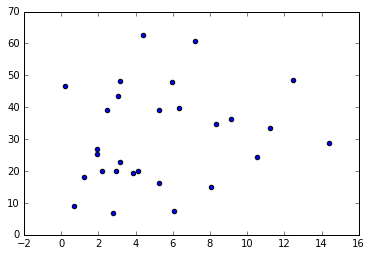

In [78]:
plt.scatter(envs,geos)

### what about for envs which we expect to be clinal?

In [341]:
envdf.index[2]

'Ann-ppt'

In [345]:
#get pairwise environmental distances
precipDict = OrderedDict()
for i,popi in enumerate(envdf.columns):
    precipDict[popi] = OrderedDict()
    for j,popj in enumerate(envdf.columns):
        if i < j: #lower tri - reverse logic when put into dataframe
            sqdif = []
            for env in [envdf.index[2]]: #just for Ann-ppt
                xi = envdf.loc[env,popi]
                xj = envdf.loc[env,popj]
                difsq = (xi - xj)**2
                sqdif.append(difsq)
            sums = sum(sqdif)
            precipDict[popi][popj] = np.sqrt(sums)
        else:
            precipDict[popi][popj] = np.nan
precipdist = pd.DataFrame(precipDict)
precipdist

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Freel_Peak,2.241813,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Heavenly,3.038379,0.796566,NaN,NaN,NaN,NaN,NaN,NaN
Little_Round_Top,1.562883,0.678930,1.475496,NaN,NaN,NaN,NaN,NaN
Mt_Rose_Ophir,1.680520,0.561294,1.357860,0.117636,NaN,NaN,NaN,NaN
Rifle_Peak,1.361221,0.880592,1.677158,0.201662,0.319299,NaN,NaN,NaN
Snow_Valley_Peak,2.745969,0.504156,0.292410,1.183086,1.065449,1.384748,NaN,NaN
West_Shore_Peaks,0.341145,1.900668,2.697234,1.221738,1.339374,1.020075,2.404823,NaN


In [346]:
sqdif

[5.7831757599677251]

In [347]:
precips = []
for i,popi in enumerate(precipdist.index):
    for j,popj in enumerate(precipdist.index):
        if i > j:
            precips.append(precipdist.loc[popi,popj])
precips

[2.241813042681267,
 3.038379296227685,
 0.79656625354641752,
 1.5628831556923377,
 0.67892988698892964,
 1.4754961405353471,
 1.6805195222498255,
 0.56129352043144187,
 1.3578597739778593,
 0.1176363665574878,
 1.3612208130223586,
 0.88059222965890871,
 1.6771584832053263,
 0.20166234266997907,
 0.31929870922746689,
 2.7459688993562148,
 0.50415585667494778,
 0.29241039687146975,
 1.1830857436638773,
 1.0654493771063895,
 1.3847480863338566,
 0.34114546301671433,
 1.9006675796645529,
 2.6972338332109702,
 1.2217376926756234,
 1.3393740592331111,
 1.0200753500056443,
 2.4048234363395009]

In [348]:
spearmanr(precips,geos)

SpearmanrResult(correlation=-0.12534209085933223, pvalue=0.52508727300762481)

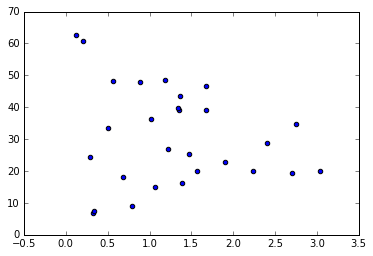

In [351]:
plt.scatter(precips,geos)

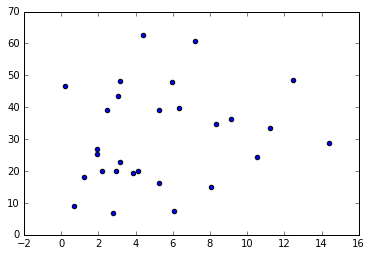

In [349]:
plt.scatter(envs,geos)

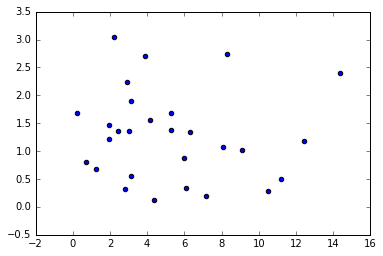

In [350]:
plt.scatter(envs,precips)

# get harmonic mean of BFs across chains

In [228]:
envDict['Ann-ppt']

[6, 7, 8]

In [229]:
#get a dictionary to name columns in bf_environfile.ENVIRONFILE
orderDict = {}
orderDict[0] = 'BF'
orderDict[1] = 'rho'
orderDict[2] = 'pearson'
colDict = OrderedDict()
for env,cols in envDict.items():
    #print env,cols
    colCount = 0
    for col in cols:
        sub = '_'.join([str(env), orderDict[colCount]]) 
        colDict[col] = sub
        colCount += 1

In [223]:
chains = sorted([chain for chain in ls('/home/lindb/wbp/bayenv2/') if 'chain' in chain])
chains

['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

In [233]:
#load and transform the outfile to have indices and column names
#put df into a dictionary based on chain ID
outDict = OrderedDict()
for chain in chains:
    print chain
    bff = '/home/lindb/wbp/bayenv2/%s/%s_outfile.bf' % (chain,chain)
    bfdf = pd.read_csv(bff,header=None,sep='\t')
    loci = []
    for row in bfdf.index:
        locus = bfdf.loc[row,0].split("/")[-1]
        loci.append(locus)
    outdf = bfdf.loc[:,[x for x in bfdf.columns[1:-1]]]
    outdf.columns = [col for col in range(len(outdf.columns))]
    outdf.columns = [colDict[col] for col in outdf.columns]
    outdf.index = [locus for locus in loci]
    outDict[chain] = outdf

chain_1
chain_2
chain_3
chain_4
chain_5


In [234]:
outDict['chain_5'].head()

,AWS0-25_BF,AWS0-25_rho,AWS0-25_pearson,AWS0-50_BF,AWS0-50_rho,AWS0-50_pearson,Ann-ppt_BF,Ann-ppt_rho,Ann-ppt_pearson,CEC_BF,...,Tmax-July_pearson,Tmin-Jan_BF,Tmin-Jan_rho,Tmin-Jan_pearson,WC15Bar_BF,WC15Bar_rho,WC15Bar_pearson,WC3rdbar_BF,WC3rdbar_rho,WC3rdbar_pearson
NODE_1036368_length_96_cov_1.020833_47,0.056231,-0.032080,-0.020458,0.044800,-0.001880,-0.014711,0.056757,-0.062657,0.035734,0.061337,...,-0.106980,0.046545,-0.060652,-0.021957,0.051016,0.076065,-0.000273,0.059631,0.089724,0.013691
NODE_633968_length_94_cov_2.180851_60,0.035449,-0.103760,-0.127020,0.031721,-0.119300,-0.145560,0.073386,-0.040226,0.049459,0.031354,...,-0.070451,0.032969,0.037469,0.038057,0.032028,-0.018421,-0.133430,0.034490,-0.004135,-0.090576
NODE_1723898_length_90_cov_1.000000_8,0.093310,0.072180,0.070103,0.113040,0.106390,0.083650,0.040558,-0.014912,0.071651,0.046979,...,-0.189350,0.046109,-0.122810,-0.041368,0.085912,0.152760,0.077514,0.066530,0.126570,0.064366
NODE_1133958_length_69_cov_1.115942_71,0.039416,-0.029699,-0.016861,0.040083,-0.003509,-0.003157,0.041846,-0.104510,-0.048550,0.054085,...,-0.073048,0.059618,-0.130950,-0.092294,0.040907,0.034712,0.008664,0.037679,0.050501,0.012843
NODE_741285_length_93_cov_5.580645_96,0.080252,-0.060526,-0.070561,0.089360,-0.066541,-0.079490,0.103210,0.002130,-0.040539,0.037644,...,0.036313,0.049323,0.022055,-0.015028,0.112940,-0.085213,-0.085708,0.138220,-0.077820,-0.073480


In [235]:
outDict['chain_5'].shape

(116231, 54)

In [251]:
#create a dictionary which has BFs separated by environment
bfDict = OrderedDict() #bfDict[env] = dataframe, cols = chain1-5 for a single env
for env in envDict.keys():
    print env
    for c,chain in enumerate(outDict.keys()):
        if c == 0:
            df = outDict[chain].loc[:,[col for col in outDict[chain].columns if ('%s_BF' % env) in col]]
            df.columns = ['%s_BF_%s' % (env,chain)]
        else:
            new = outDict[chain].loc[:,[col for col in outDict[chain].columns if ('%s_BF' % env) in col]]
            new.columns = ['%s_BF_%s' % (env,chain)]
            df = pd.merge(df,new,left_index=True,right_index=True)
    bfDict[env] = df

AWS0-25
AWS0-50
Ann-ppt
CEC
Clay
Elev
GDD-Aug
GDD-May
Lat
Lon
Max-rad-input
Rock-cov
Sand
Silt
Tmax-July
Tmin-Jan
WC15Bar
WC3rdbar


In [267]:
from scipy.stats import variation as spvar

In [303]:
statsDict = OrderedDict()
for env in bfDict.keys():
    print env
    statsDict[env] = OrderedDict() #keys = coef (std/mean), |max - min|
    statsDict[env]['coef'] = []
    statsDict[env]['abs_diff'] = []
    
    for locus in bfDict[env].index:
        data = bfDict[env].loc[locus,:].tolist()
        coef = spvar(data)
        absdiff = abs(max(data) - min(data))
        statsDict[env]['coef'].append(coef)
        statsDict[env]['abs_diff'].append(absdiff)
    #print pd.Series(statsDict[env]['abs_diff']).describe()
    #plt.hist(statsDict[env]['abs_diff'],bins = np.arange(0,max(statsDict[env]['abs_diff']),10))[2]
    
    #print pd.Series(statsDict[env]['coef']).describe()
    #plt.hist(statsDict[env]['coef'],bins = np.arange(0,max(statsDict[env]['coef']),0.05))

AWS0-25
AWS0-50
Ann-ppt
CEC
Clay
Elev
GDD-Aug
GDD-May
Lat
Lon
Max-rad-input
Rock-cov
Sand
Silt
Tmax-July
Tmin-Jan
WC15Bar
WC3rdbar


<a list of 40 Patch objects>

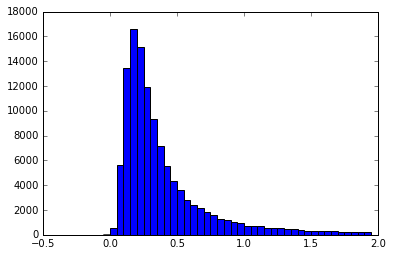

In [1351]:
plt.hist(statsDict['AWS0-25']['coef'],bins = np.arange(-0.05,max(statsDict['AWS0-25']['coef']),0.05))[2]

(array([  1.16039000e+05,   1.00000000e+02,   2.90000000e+01,
          1.40000000e+01,   7.00000000e+00,   3.00000000e+00,
          1.00000000e+01,   5.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

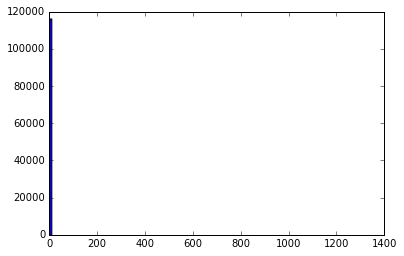

In [280]:
plt.hist(statsDict['AWS0-25']['abs_diff'],bins = np.arange(0,1400,10))

In [295]:
pd.Series(statsDict['AWS0-25']['abs_diff']).describe()

count    116231.000000
mean          0.220621
std           6.545510
min           0.000942
25%           0.023989
50%           0.041458
75%           0.083695
max        1322.957369
dtype: float64

In [312]:
idx = []
for i,x in enumerate(statsDict['AWS0-25']['abs_diff']):
    if x > 18:
        idx.append(i)

In [313]:
bfDict['AWS0-25'].loc[bfDict['AWS0-25'].index[[x for x in idx]],:]
#NODE_280450_length_96_cov_2.343750_15

,AWS0-25_BF_chain_1,AWS0-25_BF_chain_2,AWS0-25_BF_chain_3,AWS0-25_BF_chain_4,AWS0-25_BF_chain_5
NODE_1906138_length_95_cov_1.000000_47,0.042532,91.645000,0.067094,0.054037,0.130730
NODE_797791_length_62_cov_1.112903_37,0.055633,79.929000,0.034275,0.125900,0.157650
NODE_1869763_length_92_cov_1.010870_15,0.045646,0.048322,117.820000,0.032635,0.045380
NODE_1055156_length_92_cov_1.032609_32,0.041927,0.038573,0.039565,0.075760,21.061000
NODE_1746387_length_95_cov_1.010526_95,0.037170,0.036075,0.049154,25.523000,0.046220
NODE_572848_length_90_cov_1.000000_86,0.036868,0.039488,0.049957,0.065854,36.641000
NODE_1183589_length_93_cov_2.032258_31,0.041578,0.032372,0.140680,0.043475,131.580000
NODE_1210238_length_72_cov_1.069444_66,0.048176,0.068921,0.077588,0.054508,89.642000
NODE_1951481_length_91_cov_1.000000_96,0.060473,0.043850,102.330000,0.052802,0.061277
NODE_942534_length_98_cov_4.877551_111,69.422000,0.039528,0.039960,0.026923,0.064810


In [329]:
hmean([450,580,400,425,0.1]),hmean([450,580,400,425]),np.mean([450,580,400,425,0.1]),np.mean([450,580,400,425])

(0.49956042173167775, 371.01999999999998, 463.75)

In [ ]:
hmean([.045,.0580,.0400,.0425,0.1]),hmean([.0450,.0580,.0400,.0425]),np.mean([.0450,.0580,.0400,.0425,0.1]),
np.mean([.0450,.0580,.0400,.0425])

In [323]:
hmean([62.197,0.083,.362,.054,.078]),np.mean([62.197,0.083,.362,.054,.078])

(0.10830543945911754, 12.554800000000002)

In [352]:
#calculate harmonic mean, flag SNPs with >=2 chains with BF>1
harmDict= OrderedDict()
for env in bfDict.keys():
    print env
    harmDict[env] = OrderedDict()
    for locus in bfDict[env].index:
        data = bfDict[env].loc[locus,:].tolist()
        bigs = [x for x in data if x>1]
        if len(bigs) >2:
            print bigs
            harmDict[env][locus] = hmean(bigs)
        else:
            good = [x for x in data if x not in bigs]
            harmDict[env][locus] = hmean(good)
    print sorted(harmDict[env].values())[-10:]

AWS0-25
[0.14232998453001294, 0.14500957177209337, 0.14918709395416041, 0.15000910477030721, 0.15010260306177009, 0.15056053916316911, 0.15125933508740866, 0.15389800637493675, 0.15430183707698183, 0.15788214225166133]
AWS0-50
[0.15726746849831802, 0.16133913253355689, 0.16146345259727288, 0.1629687210442396, 0.16345616756305903, 0.16426827867382363, 0.17229848415008206, 0.19533771894566282, 0.19897871651632806, 0.21588856703727377]
Ann-ppt
[0.12635743645004355, 0.1280364044035894, 0.1285289291585465, 0.13100827456619302, 0.13141122299875102, 0.13179928150228756, 0.13273300835632837, 0.13574338498985861, 0.14716885188128762, 0.17316372507947805]
CEC
[0.13258091558714261, 0.13293148018640194, 0.13453201160411529, 0.13669513332025038, 0.13703687041632903, 0.13926605543732812, 0.14078651867302089, 0.14104448310923415, 0.15156294439446119, 0.15238674664436769]
Clay
[0.13345714459312577, 0.13757834934527655, 0.1398621861985016, 0.14255492427328872, 0.1464593567315568, 0.15475840047821016, 0

In [354]:
#write out hmean for each snp to file
for env in harmDict.keys():
    print env
    filE = '/home/lindb/wbp/bayenv2/results/%s_all_BFs.txt' % env
    with open(filE,'w') as o:
        line = '\t'.join(['locus','BF']) + '\n'
        o.write("%s" % line)
        for locus in harmDict[env].keys():
            line = '\t'.join([str(locus),str(harmDict[env][locus])])+'\n'
            o.write("%s" % line)
harmdfDict = OrderedDict()
for env in harmDict.keys():
    filE = '/home/lindb/wbp/bayenv2/results/%s_BFs.txt' % env
    harmdfDict[env] = pd.read_csv(filE,header=0,sep='\t')
harmdfDict[env]

AWS0-25
AWS0-50
Ann-ppt
CEC
Clay
Elev
GDD-Aug
GDD-May
Lat
Lon
Max-rad-input
Rock-cov
Sand
Silt
Tmax-July
Tmin-Jan
WC15Bar
WC3rdbar


,locus,BF
0,NODE_1036368_length_96_cov_1.020833_47,0.050134
1,NODE_633968_length_94_cov_2.180851_60,0.037862
2,NODE_1723898_length_90_cov_1.000000_8,0.059770
3,NODE_1133958_length_69_cov_1.115942_71,0.049691
4,NODE_741285_length_93_cov_5.580645_96,0.058152
5,NODE_626544_length_93_cov_1.064516_11,0.049638
6,NODE_737136_length_90_cov_2.000000_94,0.062565
7,NODE_1272846_length_91_cov_1.000000_99,0.050578
8,NODE_647468_length_95_cov_3.473684_39,0.046079
9,NODE_1646431_length_91_cov_2.000000_24,0.070122


In [390]:
#do some sorting, rewrite the file
for env in harmdfDict.keys():
    harmdfDict[env].sort_values(by='BF',inplace=True)
    filE = '/home/lindb/wbp/bayenv2/results/%s_BFs.txt' % env
    harmdfDict[env].to_csv(filE,header=True,index=False,sep='\t')

In [394]:
#in case I have to restart my notebook
harmdfDict = OrderedDict()
for env in harmDict.keys():
    filE = '/home/lindb/wbp/bayenv2/results/%s_BFs.txt' % env
    harmdfDict[env] = pd.read_csv(filE,header=0,sep='\t')

In [393]:
harmdfDict[env]

,locus,BF
0,NODE_590307_length_94_cov_3.138298_61,0.025860
1,NODE_1077806_length_103_cov_1.854369_132,0.026560
2,NODE_1869194_length_91_cov_1.000000_52,0.027423
3,NODE_1048361_length_96_cov_1.000000_18,0.027586
4,NODE_829823_length_46_cov_1.782609_43,0.027653
5,NODE_386469_length_97_cov_1.072165_25,0.028332
6,NODE_901165_length_100_cov_2.150000_101,0.028491
7,NODE_200412_length_98_cov_1.867347_111,0.028577
8,NODE_1461978_length_90_cov_1.044444_95,0.028618
9,NODE_1099551_length_98_cov_3.000000_123,0.028633


# get harmonic mean of abs rho across chains

In [369]:
#create a dictionary which has Rho's separated by environment
rhoDict = OrderedDict() #rhoDict[env] = dataframe, cols = chain1-5 for a single env
for env in envDict.keys():
    print env
    for c,chain in enumerate(outDict.keys()):
        if c == 0:
            df = outDict[chain].loc[:,[col for col in outDict[chain].columns if ('%s_rho' % env) in col]]
            df.columns = ['%s_rho_%s' % (env,chain)]
        else:
            new = outDict[chain].loc[:,[col for col in outDict[chain].columns if ('%s_rho' % env) in col]]
            new.columns = ['%s_rho_%s' % (env,chain)]
            df = pd.merge(df,new,left_index=True,right_index=True)
    rhoDict[env] = df

AWS0-25
AWS0-50
Ann-ppt
CEC
Clay
Elev
GDD-Aug
GDD-May
Lat
Lon
Max-rad-input
Rock-cov
Sand
Silt
Tmax-July
Tmin-Jan
WC15Bar
WC3rdbar


In [376]:
#get harmonic means of the absolute value of rho
hrhoDict= OrderedDict()
for env in rhoDict.keys():
    print env
    hrhoDict[env] = OrderedDict()
    for locus in rhoDict[env].index:
        data = rhoDict[env].loc[locus,:].tolist()
        data = [abs(x) for x in data if x != 0] #harmonic mean can't use 0s
        hrhoDict[env][locus] = hmean(data)
    print sorted(hrhoDict[env].values())[-10:]

AWS0-25
[0.25668714881403853, 0.25706163177768382, 0.25956273170043981, 0.26073846216323671, 0.26130861936796679, 0.26258542992709755, 0.26388600895543146, 0.26581776201436025, 0.26704063624840896, 0.26733609824413551]
AWS0-50
[0.25953359261695741, 0.25990208328204989, 0.26012673395869501, 0.26161065256362925, 0.2618629711862569, 0.26267140427089142, 0.26707199082169741, 0.26813943851097011, 0.26962083765952893, 0.27553604627087502]
Ann-ppt
[0.27801144384110843, 0.27818852976049901, 0.28051756591440874, 0.28430378797968164, 0.28494094384700541, 0.28819296241969128, 0.28874434399908377, 0.28882082686459004, 0.29812429242652244, 0.31109254634875722]
CEC
[0.32148795483690834, 0.32202107827244547, 0.32556148330325541, 0.32830337151606404, 0.3287138536962369, 0.33192609096709519, 0.33310396483661647, 0.33962432961682865, 0.34193122180339697, 0.3454294953047381]
Clay
[0.28162162474952801, 0.28275110445075052, 0.28333632950993332, 0.28455412047997125, 0.28500591262260727, 0.28629995124052088,

In [377]:
#write to file
for env in hrhoDict.keys():
    print env
    filE = '/home/lindb/wbp/bayenv2/results/%s_all_rhos.txt' % env
    with open(filE,'w') as o:
        line = '\t'.join(['locus','rho']) + '\n'
        o.write("%s" % line)
        for locus in hrhoDict[env].keys():
            line = '\t'.join([str(locus),str(hrhoDict[env][locus])])+'\n'
            o.write("%s" % line)

AWS0-25
AWS0-50
Ann-ppt
CEC
Clay
Elev
GDD-Aug
GDD-May
Lat
Lon
Max-rad-input
Rock-cov
Sand
Silt
Tmax-July
Tmin-Jan
WC15Bar
WC3rdbar


In [386]:
#sort and rewrite to file
hrhodfDict = OrderedDict()
for env in hrhoDict.keys():
    filE = '/home/lindb/wbp/bayenv2/results/%s_all_rhos.txt' % env
    hrhodfDict[env] = pd.read_csv(filE,header=0,sep='\t')
    hrhodfDict[env].sort_values(by='rho',inplace=True)
    hrhodfDict[env].to_csv(filE,header=True,index=False,sep='\t')

## get loci in intersection of top BFs and top rhos

### top 0.5% BF (n=582), top 1%rho (n=1,163)

In [412]:
#get top rhos and BFs from dataframes for each env - since sorted by value, just the top % using index
topBFs  = OrderedDict()
topRhos = OrderedDict()
for env in harmdfDict.keys():
    topbfs = pd.DataFrame(harmdfDict[env].loc[harmdfDict[env].index[-582:],:])
    topBFs[env] = topbfs['locus'].tolist()
    
    toprhos = pd.DataFrame(hrhodfDict[env].loc[hrhodfDict[env].index[-1163:],:])
    topRhos[env] = toprhos['locus'].tolist()

In [1357]:
#look at min and max values
minrho = 1
maxrho = -1
for env in harmdfDict.keys():
    topbfs = pd.DataFrame(harmdfDict[env].loc[harmdfDict[env].index[-582:],:])
    print env
    print 'BF =',round(min(topbfs['BF']),3),",",round(max(topbfs['BF']),3)
    
    toprhos = pd.DataFrame(hrhodfDict[env].loc[hrhodfDict[env].index[-1163:],:])
    print 'rho =',round(min(toprhos['rho']),3),",",round(max(toprhos['rho']),3)
    print '\n'
    if min(toprhos['rho']) < minrho:
        minrho = min(toprhos['rho'])
    if max(toprhos['rho']) > maxrho:
        maxrho = max(toprhos['rho'])
print 'min=',minrho
print 'max=',maxrho

AWS0-25
BF = 0.088 , 0.158
rho = 0.159 , 0.267


AWS0-50
BF = 0.089 , 0.216
rho = 0.162 , 0.276


Ann-ppt
BF = 0.086 , 0.173
rho = 0.159 , 0.311


CEC
BF = 0.086 , 0.152
rho = 0.228 , 0.345


Clay
BF = 0.086 , 0.186
rho = 0.224 , 0.296


Elev
BF = 0.096 , 0.325
rho = 0.173 , 0.269


GDD-Aug
BF = 0.096 , 0.286
rho = 0.19 , 0.283


GDD-May
BF = 0.096 , 0.344
rho = 0.172 , 0.282


Lat
BF = 0.091 , 0.193
rho = 0.161 , 0.246


Lon
BF = 0.087 , 0.175
rho = 0.138 , 0.255


Max-rad-input
BF = 0.09 , 0.361
rho = 0.246 , 0.318


Rock-cov
BF = 0.089 , 0.186
rho = 0.173 , 0.313


Sand
BF = 0.09 , 0.206
rho = 0.167 , 0.254


Silt
BF = 0.091 , 0.249
rho = 0.162 , 0.248


Tmax-July
BF = 0.088 , 0.178
rho = 0.222 , 0.328


Tmin-Jan
BF = 0.092 , 0.289
rho = 0.177 , 0.28


WC15Bar
BF = 0.089 , 0.297
rho = 0.15 , 0.242


WC3rdbar
BF = 0.088 , 0.247
rho = 0.147 , 0.251


min= 0.138393249638
max= 0.345429495305


In [610]:
#look at min and max values
minrho = 1
maxrho = -1
for env in harmdfDict.keys():
    topbfs = pd.DataFrame(harmdfDict[env].loc[harmdfDict[env].index[-582:],:])
    print env
    print 'BF =',min(topbfs['BF']),max(topbfs['BF'])
    
    toprhos = pd.DataFrame(hrhodfDict[env].loc[hrhodfDict[env].index[-1163:],:])
    print 'rho =',min(toprhos['rho']),max(toprhos['rho'])
    print '\n'
    if min(toprhos['rho']) < minrho:
        minrho = min(toprhos['rho'])
    if max(toprhos['rho']) > maxrho:
        maxrho = max(toprhos['rho'])
print 'min=',minrho
print 'max=',maxrho

AWS0-25
BF = 0.0878490049158 0.157882142252
rho = 0.159222893498 0.267336098244


AWS0-50
BF = 0.0890116013 0.215888567037
rho = 0.16157032742 0.275536046271


Ann-ppt
BF = 0.0862550191097 0.173163725079
rho = 0.159493290482 0.311092546349


CEC
BF = 0.0862549591843 0.152386746644
rho = 0.227773971971 0.345429495305


Clay
BF = 0.0862481708645 0.185582745927
rho = 0.223814947928 0.295901283392


Elev
BF = 0.0961263378097 0.325246417194
rho = 0.173082146649 0.269042251627


GDD-Aug
BF = 0.0957533720008 0.286173785817
rho = 0.18956019285 0.282622793897


GDD-May
BF = 0.0963109018435 0.343691491231
rho = 0.171641545734 0.28228569483


Lat
BF = 0.0913925311909 0.192553413551
rho = 0.160878930818 0.245516028255


Lon
BF = 0.0868591769892 0.175477630102
rho = 0.138393249638 0.254897951362


Max-rad-input
BF = 0.0904795229244 0.361113973592
rho = 0.246460461212 0.3179881085


Rock-cov
BF = 0.089233672012 0.18568494187
rho = 0.173408554339 0.313138479567


Sand
BF = 0.0895420454082 0.206398745

In [606]:
toprhos.head()

,locus,rho
115068,NODE_1244245_length_97_cov_1.000000_18,0.146583
115069,NODE_1993747_length_95_cov_1.000000_96,0.146589
115070,NODE_716385_length_98_cov_1.061224_34,0.146632
115071,NODE_1274336_length_109_cov_1.165138_70,0.146661
115072,NODE_1613864_length_92_cov_1.000000_15,0.146679


In [420]:
#get robust SNPs via intersection of top BFs and top rhos
intset = OrderedDict()
for env in topRhos.keys():
    intset[env] = list(set(topBFs[env]).intersection(set(topRhos[env])))
    print env, len(intset[env])

AWS0-25 95
AWS0-50 147
Ann-ppt 49
CEC 14
Clay 22
Elev 143
GDD-Aug 157
GDD-May 80
Lat 119
Lon 67
Max-rad-input 144
Rock-cov 143
Sand 111
Silt 140
Tmax-July 50
Tmin-Jan 116
WC15Bar 86
WC3rdbar 97


In [421]:
lens = [len(intset[env]) for env in intset.keys()]
max(lens),min(lens),np.mean(lens)

(157, 14, 98.888888888888886)

In [424]:
#write list of robust SNPs to file
for env in intset.keys():
    df = pd.DataFrame(intset[env])
    df.columns = [str(env)]
    filE = '/home/lindb/wbp/bayenv2/results/sigsnps/%s_top_p05%%BF_1%%rho.txt' % env
    df.to_csv(filE,header=True,index=False,sep='\t')

In [111]:
#when I restart my notebook
DIR = '/home/lindb/wbp/bayenv2/results/sigsnps/'
files = [op.join(DIR,f) for f in ls(DIR)]
intset = {}
for f in files:
    env = op.basename(f).split("_")[0]
    df = pd.read_csv(f,header=0,sep='\t')
    intset[env] = df[env].tolist()

In [113]:
#check against previous
for env in sorted(intset):
    print env,len(intset[env])

AWS0-25 95
AWS0-50 147
Ann-ppt 49
CEC 14
Clay 22
Elev 143
GDD-Aug 157
GDD-May 80
Lat 119
Lon 67
Max-rad-input 144
Rock-cov 143
Sand 111
Silt 140
Tmax-July 50
Tmin-Jan 116
WC15Bar 86
WC3rdbar 97


# covariances

In [105]:
#file made in 09_OutFLANK.ipynb
impMAF = pd.read_csv('/home/lindb/wbp/OutFLANK/imputed_MAF.txt',header=0,index_col=0,sep="\t")
impMAF.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
NODE_1000013_length_91_cov_1.802198_37,0.14,0.052083,0.14,0.16,0.112245,0.1250,0.145833,0.166667
NODE_1000031_length_98_cov_2.000000_30,0.26,0.104167,0.18,0.20,0.081633,0.1250,0.145833,0.229167
NODE_1000037_length_93_cov_2.043011_33,0.08,0.114583,0.14,0.16,0.102041,0.1250,0.166667,0.125000
NODE_1000042_length_93_cov_1.118280_100,0.06,0.020833,0.08,0.02,0.051020,0.0000,0.041667,0.062500
NODE_1000053_length_94_cov_1.744681_25,0.02,0.020833,0.04,0.02,0.010204,0.0625,0.020833,0.020833


In [172]:
#count > 0.5
for pop in impMAF:
    df = pd.DataFrame(impMAF[pop][impMAF[pop]>0.5])
    print pop,len(df.index)

Dicks_Pass 2252
Freel_Peak 1576
Heavenly 2381
Little_Round_Top 1879
Mt_Rose_Ophir 1504
Rifle_Peak 1897
Snow_Valley_Peak 1912
West_Shore_Peaks 1862


In [170]:
#check to make sure impMAF doesn't just have MAFs - impMAF = freq of global minor allele
for pop in impMAF:
    print pop,max(impMAF[pop])

 Dicks_Pass 0.74
Freel_Peak 0.65625
Heavenly 0.8
Little_Round_Top 0.74
Mt_Rose_Ophir 0.663265306122
Rifle_Peak 0.6875
Snow_Valley_Peak 0.75
West_Shore_Peaks 0.729166666667


In [101]:
#file made in 09_OutFLANK.ipynb
globmafs = pd.read_csv('/home/lindb/wbp/OutFLANK/global_mafs.txt',header=0,sep='\t')
globmafs.head()

,locus,maf
0,NODE_1000013_length_91_cov_1.802198_37,0.120902
1,NODE_1000031_length_98_cov_2.000000_30,0.151639
2,NODE_1000037_length_93_cov_2.043011_33,0.122951
3,NODE_1000042_length_93_cov_1.118280_100,0.040984
4,NODE_1000053_length_94_cov_1.744681_25,0.024590


In [431]:
len(globmafs.index)

116231

In [102]:
#create dictionary, key = SNP, val = maf
glob = OrderedDict()
for row in globmafs.index:
    locus = globmafs.loc[row,'locus']
    glob[locus] = globmafs.loc[row,'maf']

In [433]:
from __future__ import division

In [103]:
#population sizes
popDict = {'Dicks_Pass':25,
'Freel_Peak':48,
'Little_Round_Top':25,
'Heavenly':25,
'Mt_Rose_Ophir':49,
'Rifle_Peak':24,
'Snow_Valley_Peak':24,
'West_Shore_Peaks':24}

In [104]:
sum(popDict.values())

244

In [114]:
#do pairwise to get Dij
dijDict = OrderedDict() 
for env in intset.keys():
    outliersnps = intset[env]
    
    dijDict[env] = OrderedDict() 
    icount = 0
    for i,locusi in enumerate(outliersnps):
        dijDict[env][locusi] = OrderedDict()
        qi = glob[locusi] #global maf

        for j,locusj in enumerate(outliersnps):
            if i > j: #i=row, j=col : lower triangle 
                qj = glob[locusj] #global maf

                sums = 0
                for pop in impMAF.columns:
                    qik = impMAF.loc[locusi,pop] #get pop af
                    qjk = impMAF.loc[locusj,pop] #get pop af
                    nk = popDict[pop]

                    sums += (nk/sum(popDict.values()))*((qik*qjk)-(qi*qj))

                dijDict[env][locusi][locusj] = sums
            else:
                dijDict[env][locusi][locusj] = np.nan
        icount += 1
        if icount % 10 == 0:
            print env,icount

Tmin-Jan 10
Tmin-Jan 20
Tmin-Jan 30
Tmin-Jan 40
Tmin-Jan 50
Tmin-Jan 60
Tmin-Jan 70
Tmin-Jan 80
Tmin-Jan 90
Tmin-Jan 100
Tmin-Jan 110
Ann-ppt 10
Ann-ppt 20
Ann-ppt 30
Ann-ppt 40
CEC 10
AWS0-25 10
AWS0-25 20
AWS0-25 30
AWS0-25 40
AWS0-25 50
AWS0-25 60
AWS0-25 70
AWS0-25 80
AWS0-25 90
AWS0-50 10
AWS0-50 20
AWS0-50 30
AWS0-50 40
AWS0-50 50
AWS0-50 60
AWS0-50 70
AWS0-50 80
AWS0-50 90
AWS0-50 100
AWS0-50 110
AWS0-50 120
AWS0-50 130
AWS0-50 140
Rock-cov 10
Rock-cov 20
Rock-cov 30
Rock-cov 40
Rock-cov 50
Rock-cov 60
Rock-cov 70
Rock-cov 80
Rock-cov 90
Rock-cov 100
Rock-cov 110
Rock-cov 120
Rock-cov 130
Rock-cov 140
Tmax-July 10
Tmax-July 20
Tmax-July 30
Tmax-July 40
Tmax-July 50
WC3rdbar 10
WC3rdbar 20
WC3rdbar 30
WC3rdbar 40
WC3rdbar 50
WC3rdbar 60
WC3rdbar 70
WC3rdbar 80
WC3rdbar 90
Silt 10
Silt 20
Silt 30
Silt 40
Silt 50
Silt 60
Silt 70
Silt 80
Silt 90
Silt 100
Silt 110
Silt 120
Silt 130
Silt 140
Lon 10
Lon 20
Lon 30
Lon 40
Lon 50
Lon 60
Sand 10
Sand 20
Sand 30
Sand 40
Sand 50
Sand 60
Sand

In [115]:
#write out the file
for env in dijDict.keys():
    filE = '/home/lindb/wbp/bayenv2/covariances/dvals/%s_dvals.txt' % env
    with open(filE,'w') as o:
        key0 = dijDict[env].keys()[0]
        line = '\t'.join(dijDict[env][key0].keys()) + str('\n')
        o.write("%s" % line)
        for locusi in dijDict[env].keys():
            line = str(locusi)+'\t'+'\t'.join([str(x) for x in dijDict[env][locusi].values()]) + str('\n')
            o.write("%s" % line)

In [116]:
#check out a file
dvals = pd.read_csv(filE,header=0,index_col=0,sep="\t")
dvals.head()

,NODE_250118_length_94_cov_1.542553_99,NODE_1976969_length_93_cov_1.000000_67,NODE_1474858_length_91_cov_1.065934_93,NODE_1264108_length_94_cov_1.010638_33,NODE_1441063_length_95_cov_1.000000_24,NODE_1055527_length_48_cov_1.208333_39,NODE_1935545_length_98_cov_2.000000_16,NODE_860493_length_66_cov_1.106061_50,NODE_773201_length_50_cov_2.640000_41,NODE_770126_length_102_cov_1.098039_97,...,NODE_941846_length_90_cov_1.677778_27,NODE_785067_length_93_cov_1.107527_13,NODE_1237271_length_97_cov_2.000000_8,NODE_871521_length_98_cov_1.163265_25,NODE_775384_length_94_cov_2.000000_109,NODE_1400146_length_98_cov_3.520408_37,NODE_827226_length_55_cov_1.909091_72,NODE_1420641_length_45_cov_1.088889_45,NODE_951579_length_73_cov_1.506849_46,NODE_1919924_length_84_cov_1.011905_29
NODE_250118_length_94_cov_1.542553_99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1976969_length_93_cov_1.000000_67,0.000726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1474858_length_91_cov_1.065934_93,-0.000313,-0.000153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1264108_length_94_cov_1.010638_33,-0.000044,0.000091,0.000303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1441063_length_95_cov_1.000000_24,0.000045,0.000183,0.000221,0.000322,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
1+1

2

In [451]:
#get H_exp for each snp
#file made in 09_OutFLANK.ipynb
filE = '/home/lindb/wbp/OutFLANK/Hexp_by_snp_withbins.txt'
H = pd.read_csv(filE,header=0,index_col=0,sep='\t')
H = pd.DataFrame(H.loc[:,['h_exp','bin']])
H.head()

,h_exp,bin
NODE_1274178_length_97_cov_1.030928_97,0.020282,1
NODE_694898_length_99_cov_1.676768_19,0.020282,1
NODE_544568_length_93_cov_4.064516_12,0.020282,1
NODE_1278450_length_97_cov_2.000000_111,0.020282,1
NODE_1913585_length_92_cov_1.750000_37,0.020282,1


<a list of 50 Patch objects>

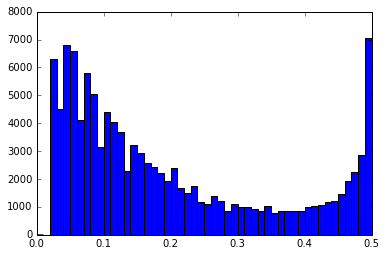

In [443]:
#Hexp for the complete set of SNPs
plt.hist(H['h_exp'],bins = [x for x in np.arange(0,.51,0.01)])[2]

In [456]:
#get a dataframe with the outlier loci and their bins
outlierdata = OrderedDict()
for env in dijDict.keys():
    outliersnps = intset[env]

    outlierdata[env] = pd.DataFrame(H[H.index.isin(outliersnps)])

In [459]:
dijDict.keys()

['AWS0-25',
 'AWS0-50',
 'Ann-ppt',
 'CEC',
 'Clay',
 'Elev',
 'GDD-Aug',
 'GDD-May',
 'Lat',
 'Lon',
 'Max-rad-input',
 'Rock-cov',
 'Sand',
 'Silt',
 'Tmax-July',
 'Tmin-Jan',
 'WC15Bar',
 'WC3rdbar']

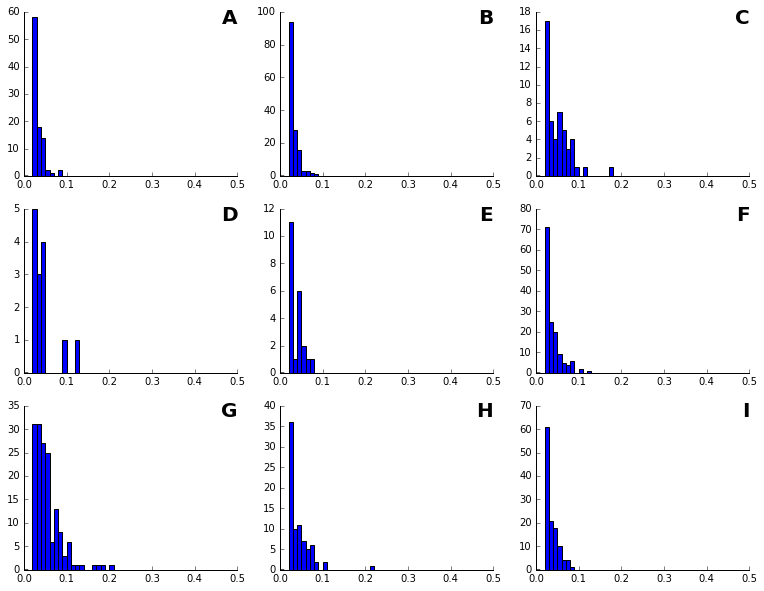

In [936]:
with PdfPages('/home/lindb/wbp/figures/grid_imp_hexp_hist_by_env_AWSO-Lat.pdf') as pdf:
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6),(a7,a8,a9)) = plt.subplots(3, 3, figsize=(5,5),dpi=400)

    a1 = plt.subplot(331)
    a1.hist(outlierdata['AWS0-25']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a1.set_title('A',y=.9,loc='right',fontsize=20,fontweight='bold')
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    
    a2 = plt.subplot(332)
    a2.hist(outlierdata['AWS0-50']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a2.set_title('B',y=.9,loc='right',fontsize=20,fontweight='bold')
    a2.spines['right'].set_visible(False)
    a2.spines['top'].set_visible(False)
    a2.yaxis.set_ticks_position('left')
    a2.xaxis.set_ticks_position('bottom')
    
    a3 = plt.subplot(333)
    a3.hist(outlierdata['Ann-ppt']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a3.set_title('C',y=.9,loc='right',fontsize=20,fontweight='bold')
    a3.spines['right'].set_visible(False)
    a3.spines['top'].set_visible(False)
    a3.yaxis.set_ticks_position('left')
    a3.xaxis.set_ticks_position('bottom')
    
    a4 = plt.subplot(334)
    a4.hist(outlierdata['CEC']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a4.set_title('D',y=.9,loc='right',fontsize=20,fontweight='bold')
    a4.spines['right'].set_visible(False)
    a4.spines['top'].set_visible(False)
    a4.yaxis.set_ticks_position('left')
    a4.xaxis.set_ticks_position('bottom')
    
    a5 = plt.subplot(335)
    a5.hist(outlierdata['Clay']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a5.set_title('E',y=.9,loc='right',fontsize=20,fontweight='bold')
    a5.spines['right'].set_visible(False)
    a5.spines['top'].set_visible(False)
    a5.yaxis.set_ticks_position('left')
    a5.xaxis.set_ticks_position('bottom')
    
    a6 = plt.subplot(336)
    a6.hist(outlierdata['Elev']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a6.set_title('F',y=.9,loc='right',fontsize=20,fontweight='bold')
    a6.spines['right'].set_visible(False)
    a6.spines['top'].set_visible(False)
    a6.yaxis.set_ticks_position('left')
    a6.xaxis.set_ticks_position('bottom')
    
    a7 = plt.subplot(337)
    a7.hist(outlierdata['GDD-Aug']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a7.set_title('G',y=.9,loc='right',fontsize=20,fontweight='bold')
    a7.spines['right'].set_visible(False)
    a7.spines['top'].set_visible(False)
    a7.yaxis.set_ticks_position('left')
    a7.xaxis.set_ticks_position('bottom')
    
    a8 = plt.subplot(338)
    a8.hist(outlierdata['GDD-May']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a8.set_title('H',y=.9,loc='right',fontsize=20,fontweight='bold')
    a8.spines['right'].set_visible(False)
    a8.spines['top'].set_visible(False)
    a8.yaxis.set_ticks_position('left')
    a8.xaxis.set_ticks_position('bottom')
    
    a9 = plt.subplot(339)
    a9.hist(outlierdata['Lat']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a9.set_title('I',y=.9,loc='right',fontsize=20,fontweight='bold')
    a9.spines['right'].set_visible(False)
    a9.spines['top'].set_visible(False)
    a9.yaxis.set_ticks_position('left')
    a9.xaxis.set_ticks_position('bottom')
    
    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

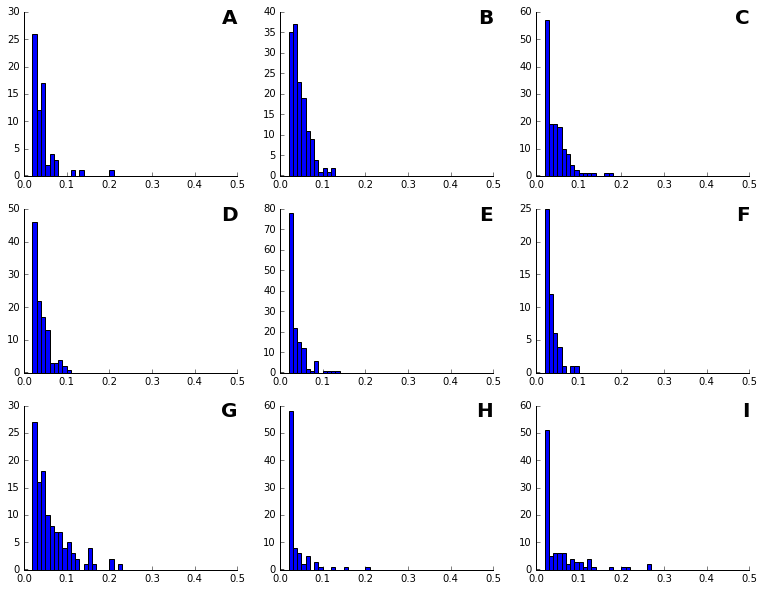

In [935]:
with PdfPages('/home/lindb/wbp/figures/grid_imp_hexp_hist_by_env_lon-WC3rdbar.pdf') as pdf:
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6),(a7,a8,a9)) = plt.subplots(3, 3, figsize=(5,5),dpi=400)

    a1 = plt.subplot(331)
    a1.hist(outlierdata['Lon']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a1.set_title('A',y=.9,loc='right',fontsize=20,fontweight='bold')
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    
    a2 = plt.subplot(332)
    a2.hist(outlierdata['Max-rad-input']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a2.set_title('B',y=.9,loc='right',fontsize=20,fontweight='bold')
    a2.spines['right'].set_visible(False)
    a2.spines['top'].set_visible(False)
    a2.yaxis.set_ticks_position('left')
    a2.xaxis.set_ticks_position('bottom')
    
    a3 = plt.subplot(333)
    a3.hist(outlierdata['Rock-cov']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a3.set_title('C',y=.9,loc='right',fontsize=20,fontweight='bold')
    a3.spines['right'].set_visible(False)
    a3.spines['top'].set_visible(False)
    a3.yaxis.set_ticks_position('left')
    a3.xaxis.set_ticks_position('bottom')
    
    a4 = plt.subplot(334)
    a4.hist(outlierdata['Sand']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a4.set_title('D',y=.9,loc='right',fontsize=20,fontweight='bold')
    a4.spines['right'].set_visible(False)
    a4.spines['top'].set_visible(False)
    a4.yaxis.set_ticks_position('left')
    a4.xaxis.set_ticks_position('bottom')
    
    a5 = plt.subplot(335)
    a5.hist(outlierdata['Silt']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a5.set_title('E',y=.9,loc='right',fontsize=20,fontweight='bold')
    a5.spines['right'].set_visible(False)
    a5.spines['top'].set_visible(False)
    a5.yaxis.set_ticks_position('left')
    a5.xaxis.set_ticks_position('bottom')
    
    a6 = plt.subplot(336)
    a6.hist(outlierdata['Tmax-July']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a6.set_title('F',y=.9,loc='right',fontsize=20,fontweight='bold')
    a6.spines['right'].set_visible(False)
    a6.spines['top'].set_visible(False)
    a6.yaxis.set_ticks_position('left')
    a6.xaxis.set_ticks_position('bottom')
    
    a7 = plt.subplot(337)
    a7.hist(outlierdata['Tmin-Jan']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a7.set_title('G',y=.9,loc='right',fontsize=20,fontweight='bold')
    a7.spines['right'].set_visible(False)
    a7.spines['top'].set_visible(False)
    a7.yaxis.set_ticks_position('left')
    a7.xaxis.set_ticks_position('bottom')
    
    a8 = plt.subplot(338)
    a8.hist(outlierdata['WC15Bar']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a8.set_title('H',y=.9,loc='right',fontsize=20,fontweight='bold')
    a8.spines['right'].set_visible(False)
    a8.spines['top'].set_visible(False)
    a8.yaxis.set_ticks_position('left')
    a8.xaxis.set_ticks_position('bottom')
    
    a9 = plt.subplot(339)
    a9.hist(outlierdata['WC3rdbar']['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    a9.set_title('I',y=.9,loc='right',fontsize=20,fontweight='bold')
    a9.spines['right'].set_visible(False)
    a9.spines['top'].set_visible(False)
    a9.yaxis.set_ticks_position('left')
    a9.xaxis.set_ticks_position('bottom')
    
    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

In [486]:
#get sets of SNPs to make random draws
nonsigsnps = OrderedDict()
for env in outlierdata.keys():
    nonsigs = list(set(H.index.tolist()) - set(outlierdata[env].index.tolist()))
    nonsigsnps[env] = pd.DataFrame(H[H.index.isin(nonsigs)])
    print len(outlierdata[env].index.tolist())+len(nonsigsnps[env].index)

116231
116231
116231
116231
116231
116231
116231
116231
116231
116231
116231
116231
116231
116231
116231
116231
116231
116231


In [491]:
#how many random snps to draw from each bin?
binCounter = OrderedDict()
for env in outlierdata.keys():
    binCounter[env] = Counter()
    for row in outlierdata[env].index:
        binCounter[env][outlierdata[env].loc[row,'bin']] += 1
    for b in binCounter[env].keys():
        print env,b,binCounter[env][b]

AWS0-25 1.0 27
AWS0-25 2.0 31
AWS0-25 3.0 25
AWS0-25 4.0 7
AWS0-25 5.0 2
AWS0-25 6.0 1
AWS0-25 8.0 2
AWS0-50 1.0 38
AWS0-50 2.0 56
AWS0-50 3.0 35
AWS0-50 4.0 9
AWS0-50 5.0 3
AWS0-50 6.0 3
AWS0-50 7.0 2
AWS0-50 8.0 1
Ann-ppt 1.0 7
Ann-ppt 2.0 10
Ann-ppt 3.0 10
Ann-ppt 5.0 7
Ann-ppt 6.0 5
Ann-ppt 7.0 3
Ann-ppt 8.0 4
Ann-ppt 9.0 1
Ann-ppt 11.0 1
Ann-ppt 17.0 1
CEC 1.0 1
CEC 2.0 4
CEC 3.0 4
CEC 4.0 3
CEC 9.0 1
CEC 12.0 1
Clay 1.0 3
Clay 2.0 8
Clay 3.0 4
Clay 4.0 3
Clay 5.0 2
Clay 6.0 1
Clay 7.0 1
Elev 1.0 26
Elev 2.0 45
Elev 3.0 32
Elev 4.0 13
Elev 5.0 9
Elev 6.0 5
Elev 7.0 4
Elev 8.0 6
Elev 10.0 2
Elev 12.0 1
GDD-Aug 1.0 6
GDD-Aug 2.0 25
GDD-Aug 3.0 42
GDD-Aug 4.0 16
GDD-Aug 5.0 25
GDD-Aug 6.0 6
GDD-Aug 7.0 13
GDD-Aug 8.0 8
GDD-Aug 9.0 3
GDD-Aug 10.0 6
GDD-Aug 11.0 1
GDD-Aug 12.0 1
GDD-Aug 13.0 1
GDD-Aug 16.0 1
GDD-Aug 17.0 1
GDD-Aug 18.0 1
GDD-Aug 20.0 1
GDD-May 1.0 15
GDD-May 2.0 21
GDD-May 3.0 15
GDD-May 4.0 6
GDD-May 5.0 7
GDD-May 6.0 5
GDD-May 7.0 6
GDD-May 8.0 2
GDD-May 10.0 2
GDD-M

In [492]:
binCounter['AWS0-25']

Counter({1.0: 27, 2.0: 31, 3.0: 25, 4.0: 7, 5.0: 2, 6.0: 1, 8.0: 2})

In [495]:
os.makedirs('/home/lindb/wbp/bayenv2/covariances/randmatrices')
os.makedirs('/home/lindb/wbp/bayenv2/covariances/randmatrices/randsnps')

In [518]:
#for each env make 1000 dataframes with a set of snps == len(outliersnps[env])
for env in outlierdata.keys():
    print env
    for i in range(1000):  
        snps = []        
        for binn in binCounter[env].keys():
            data = nonsigsnps[env][nonsigsnps[env]['bin'] == binn]
                
            [snps.append(snp) for snp in random.sample(data.index,binCounter[env][binn])]
        
        assert len(np.unique(snps).tolist()) == sum(binCounter[env].values())

        DIR = '/home/lindb/wbp/bayenv2/covariances/randmatrices/randsnps/%s' % env
        if not op.exists(DIR):
            os.makedirs(DIR)
        filE = op.join(DIR,"%s_%s_randsnps.txt" % (env,str(i).zfill(3)))
        df = pd.DataFrame(snps)
        df.to_csv(filE,header=False,index=False,sep="\t")

AWS0-25
AWS0-50
Ann-ppt
CEC
Clay
Elev
GDD-Aug
GDD-May
Lat
Lon
Max-rad-input
Rock-cov
Sand
Silt
Tmax-July
Tmin-Jan
WC15Bar
WC3rdbar


In [526]:
#quicker to do it this way
#get dvals for the sets of random snps for each env
for env in outlierdata.keys():
    for i in range(1000):
        text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import random
import math
from os import path as op
from os import listdir as ls

#get pop assignment for each samp
filE = '/home/lindb/wbp/sampsTOpop.txt'
stp = pd.read_csv(filE,header=0,sep="\t")


#pops matched to samps
ptsDict = OrderedDict() #pop to samp dictionary
for row in stp.index:
    pop = stp.loc[row,'pop']
    if not pop in ptsDict.keys():
        ptsDict[pop] = []
    ptsDict[pop].append(stp.loc[row,'sampID'])


#get a dict with num indiv in pop
popDict = OrderedDict()
total = 0
for pop in ptsDict.keys():
    popDict[pop] = len(ptsDict[pop])
    print pop,popDict[pop]
    total += popDict[pop]


filE = '/home/lindb/wbp/OutFLANK/global_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

impMAF = pd.read_csv('/home/lindb/wbp/OutFLANK/imputed_MAF.txt',header=0,index_col=0,sep="\\t")

filE= '/home/lindb/wbp/bayenv2/covariances/randmatrices/randsnps/%s/%s_%s_randsnps.txt' 
df = pd.read_csv(filE,header=None,sep="\\t")
randomsnps = df[0].tolist()

dijDict = OrderedDict() 
for i,locusi in enumerate(randomsnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global af

    for j,locusj in enumerate(randomsnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global af

            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop af
                qjk = impMAF.loc[locusj,pop] #get pop af
                nk = popDict[pop]

                sums += (nk/sum(popDict.values()))*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan

filE = '/home/lindb/wbp/bayenv2/covariances/randmatrices/randDVALS/%s/%s_%s_randDVALS.txt'
if not op.exists('/home/lindb/wbp/bayenv2/covariances/randmatrices/randDVALS/'):
    os.makedirs('/home/lindb/wbp/bayenv2/covariances/randmatrices/randDVALS/')
DIR = op.dirname(filE)
if not op.exists(DIR):
    os.makedirs(DIR)

with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\\t'.join(dijDict[key0].keys()) + str('\\n')
    o.write("%%s" %% line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\\t'+'\\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)


''' % (env,env,str(i).zfill(3),
       env,env,str(i).zfill(3))
        filE = '/home/lindb/wbp/bayenv2/covariances/randmatrices/randpyfiles/get_rand_dvals_%s_%s.py' % (env,
                                                                                                      str(i).zfill(3)
                                                                                                     )
        if not op.exists(op.dirname(filE)):
            os.makedirs(op.dirname(filE))
        with open(filE,'w') as o:
            o.write("%s" % text)

In [119]:
DIR = '/home/lindb/wbp/bayenv2/covariances/randmatrices/randpyfiles/'
pyfiles = [op.join(DIR,py) for py in ls(DIR)]
len(pyfiles)

18000

In [123]:
#spread out the jobs across 25 files
#18000/200=90
count = 0
fcount = 0
for f in sorted(pyfiles):
    if count == 0:
        text = '''#!/bin/bash
#$ -N pyfile%s
#$ -V
#$ -j y
#$ -cwd

python %s\n''' % (str(fcount),
                  f)
    else:
        newtext = 'python %s\n' % f
        text = text + newtext
    count += 1
    if count == 90:
        count = 0
        fcount += 1
        filE = '/home/lindb/wbp/bayenv2/covariances/randmatrices/runpyfiles/%s_cmds.sh' % str(fcount).zfill(3)
        if not op.exists('/home/lindb/wbp/bayenv2/covariances/randmatrices/runpyfiles/'):
            os.makedirs('/home/lindb/wbp/bayenv2/covariances/randmatrices/runpyfiles/')
        with open(filE,'w') as o:
            o.write("%s" % text)

In [1352]:
#qsub the qsub files

In [160]:
#check on progress godzilla
DIR = '/home/lindb/wbp/bayenv2/covariances/randmatrices/randDVALS/'
ds = [op.join(DIR,d) for d in ls(DIR)]
count = 0
for DIR in ds:
    count = count + len(ls(DIR))
count

18000

In [575]:
DF = pd.read_csv('/home/lindb/wbp/bayenv2/covariances/dvals/Ann-ppt_dvals.txt',
                 header=0,index_col=0,sep='\t')
len(DF.index)

49

# get observed dvals
dvals = OrderedDict()
medvals = OrderedDict()
for env in get:
    print env
    DF = pd.read_csv('/home/lindb/wbp/bayenv2/covariances/dvals/%s_dvals.txt' % env,
                     header=0,index_col=0,sep="\t")
    dvals[env] = []
    for i,row in enumerate(DF.index):
        for j,col in enumerate(DF.columns):
            if i > j:
                dvals[env].append(abs(DF.loc[row,col]))

    DIR = '/home/lindb/wbp/bayenv2/covariances/randmatrices/randDVALS/%s/' % env
    files = [op.join(DIR,f) for f in ls(DIR)]

    fcount = 0
    medvals[env] = []
    for f in files:
        df = pd.read_csv(f,header=0,index_col=0,sep="\t")
        rvals = [] #random dij values
        for lst in df.values.tolist():
            for x in lst:
                if math.isnan(x) == False:
                    rvals.append(x)


        medvals[env].append(np.median([abs(val) for val in rvals]))

        fcount += 1
        if fcount % 100 == 0:
            print fcount

    filE = '/home/lindb/wbp/bayenv2/covariances/randmatrices/randmedvals/%s_randmedvalues.txt' % env
    if not op.exists(op.dirname(filE)):
        os.makedirs(op.dirname(filE))
    medvaldf = pd.DataFrame(medvals[env])
    medvaldf.to_csv(filE,header=False,index=False,sep="\t")

In [233]:
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for env in sorted(get):
    print env,'has',len(intset[env]),'associated SNPs'
    sorts        = sorted(medvals[env])
    n5th[env]    = sorts[949]
    gt_hth[env]  = np.median(dvals[env])/max(medvals[env])
    print 'emp median is %sx greater than 100th percentile of random'%str(round(gt_hth[env],3))
    gt_n5th[env] = np.median(dvals[env])/n5th[env]
    print 'emp median is %sx greater than 95th percentile of random'%str(round(gt_n5th[env],3))
    for i,dval in enumerate(sorted(dvals[env])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[env]=(i+1,(i+1)/len(dvals[env]))
            break
    for i,dval in enumerate(sorted(dvals[env])):
        if not dval < sorts[949]:
            bn5th[env]=(i+1,(i+1)/len(dvals[env]))
            break
    print 'the max random value corresponds to the %s precentile' % str(round(bmax[env][1],3)*100),"(%s/%s)" % (bmax[env][0],len(dvals[env])),'of emp values'
    print 'the 95th perc rand val corresponds to the %s percentile',str(round(bn5th[env][1],3)*100),"(%s/%s)" % (bn5th[env][0],len(dvals[env])),'of emp values'
    print 'emp med dval =',"{:.4}".format(np.median(dvals[env]))
    print 'max rand dval =',"{:.4}".format(max(medvals[env]))
    print '95th rand dval =',"{:.4}".format(n5th[env])
    print '\n' 

AWS0-25 has 95 associated SNPs
emp median is 3.003x greater than 100th percentile of random
emp median is 3.219x greater than 95th percentile of random
the max random value corresponds to the 11.9 precentile (533/4465) of emp values
the 95th perc rand val corresponds to the %s percentile 10.8 (484/4465) of emp values
emp med dval = 0.0002053
max rand dval = 6.837e-05
95th rand dval = 6.377e-05


AWS0-50 has 147 associated SNPs
emp median is 2.949x greater than 100th percentile of random
emp median is 3.126x greater than 95th percentile of random
the max random value corresponds to the 12.6 precentile (1350/10731) of emp values
the 95th perc rand val corresponds to the %s percentile 11.6 (1248/10731) of emp values
emp med dval = 0.0001974
max rand dval = 6.696e-05
95th rand dval = 6.316e-05


Ann-ppt has 49 associated SNPs
emp median is 5.097x greater than 100th percentile of random
emp median is 5.882x greater than 95th percentile of random
the max random value corresponds to the 1.4 p

In [601]:
#this is old- from when I calculated Dij using the maf of either allele within pops
n5th = OrderedDict()    #get 95th percentile
gt_hth = OrderedDict()  #how much greater is the empirical median dvalue than the 100th percentile of random SNPs?
gt_n5th = OrderedDict() #how much greater is the empirical median dvalue than the 95th percentile of random SNPs?
bmax=OrderedDict()      #below what percentile of the observed dvals are the values less than the maximum randdvals
bn5th = OrderedDict()   #below what percentile of the observed dvals are the values less than the 95th perc randdvals
for env in outlierdata.keys():
    print env,len(intset[env])
    sorts        = sorted(medvals[env])
    n5th[env]    = sorts[949]
    gt_hth[env]  = np.median(dvals[env])/max(medvals[env])
    print 'gt_hth',round(gt_hth[env],3)
    gt_n5th[env] = np.median(dvals[env])/n5th[env]
    print 'gt_n5th',round(gt_n5th[env],3)
    for i,dval in enumerate(sorted(dvals[env])):
        if not dval < max(sorts): #the max(randDval) corresponds to the xth percentile of empirical d-values
            bmax[env]=(i+1,i/len(dvals[env]))
            break
    for i,dval in enumerate(sorted(dvals[env])):
        if not dval < sorts[949]:
            bn5th[env]=(i+1,i/len(dvals[env]))
            break
    print 'bmax',round(bmax[env][1],3),"(%s/%s)" % (bmax[env][0],len(dvals[env]))
    print 'bn5th',round(bn5th[env][1],3),"(%s/%s)" % (bn5th[env][0],len(dvals[env]))
    print 'med dval',"{:.2}".format(np.median(dvals[env]))
    print 'max rand dval',"{:.4}".format(max(medvals[env]))
    print '\n'

AWS0-25 95
gt_hth 3.003
gt_n5th 3.219
bmax 0.119 (533/4465)
bn5th 0.108 (484/4465)
med dval 0.00021
max rand dval 6.837e-05


AWS0-50 147
gt_hth 2.949
gt_n5th 3.126
bmax 0.126 (1350/10731)
bn5th 0.116 (1248/10731)
med dval 0.0002
max rand dval 6.696e-05


Ann-ppt 49
gt_hth 5.097
gt_n5th 5.882
bmax 0.013 (16/1176)
bn5th 0.008 (10/1176)
med dval 0.00059
max rand dval 0.0001167


CEC 14
gt_hth 2.297
gt_n5th 3.416
bmax 0.077 (8/91)
bn5th 0.0 (1/91)
med dval 0.00037
max rand dval 0.0001631


Clay 22
gt_hth 1.171
gt_n5th 1.729
bmax 0.433 (101/231)
bn5th 0.242 (57/231)
med dval 0.00015
max rand dval 0.0001272


Elev 143
gt_hth 3.204
gt_n5th 3.426
bmax 0.073 (740/10153)
bn5th 0.064 (650/10153)
med dval 0.00026
max rand dval 8.118e-05


GDD-Aug 157
gt_hth 4.163
gt_n5th 4.516
bmax 0.059 (719/12246)
bn5th 0.053 (648/12246)
med dval 0.00047
max rand dval 0.0001134


GDD-May 80
gt_hth 2.498
gt_n5th 2.878
bmax 0.156 (494/3160)
bn5th 0.123 (391/3160)
med dval 0.00024
max rand dval 9.603e-05


Lat 119

In [167]:
df = pd.read_csv('/home/lindb/wbp/OutFLANK/imputed_MAF.txt',header=0,index_col=0,sep='\t')
df.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
NODE_1000013_length_91_cov_1.802198_37,0.14,0.052083,0.14,0.16,0.112245,0.1250,0.145833,0.166667
NODE_1000031_length_98_cov_2.000000_30,0.26,0.104167,0.18,0.20,0.081633,0.1250,0.145833,0.229167
NODE_1000037_length_93_cov_2.043011_33,0.08,0.114583,0.14,0.16,0.102041,0.1250,0.166667,0.125000
NODE_1000042_length_93_cov_1.118280_100,0.06,0.020833,0.08,0.02,0.051020,0.0000,0.041667,0.062500
NODE_1000053_length_94_cov_1.744681_25,0.02,0.020833,0.04,0.02,0.010204,0.0625,0.020833,0.020833


In [168]:
for pop in df:
    print pop,max(df[pop])

Dicks_Pass 0.74
Freel_Peak 0.65625
Heavenly 0.8
Little_Round_Top 0.74
Mt_Rose_Ophir 0.663265306122
Rifle_Peak 0.6875
Snow_Valley_Peak 0.75
West_Shore_Peaks 0.729166666667


In [173]:
gtmin = 1000000000

gtmax = 0
for env in gt_hth.keys():
    if gt_hth[env] < gtmin:
        gtmin = gt_hth[env]
        minenv = env
    if gt_hth[env] > gtmax:
        gtmax = gt_hth[env]
        maxenv = env
print minenv,gtmin
print maxenv,gtmax

Clay 1.17090321277
Ann-ppt 5.09713153737


In [174]:
len(dvals[env]),len(dvals['Ann-ppt'])

(4656, 1176)

# allele frequency shifts

In [175]:
for env in intset.keys():
    print env,len(intset[env])

Tmin-Jan 116
Ann-ppt 49
CEC 14
AWS0-25 95
AWS0-50 147
Rock-cov 143
Tmax-July 50
WC3rdbar 97
Silt 140
Lon 67
Sand 111
Max-rad-input 144
Elev 143
Clay 22
Lat 119
GDD-May 80
GDD-Aug 157
WC15Bar 86


In [176]:
#dataframe to get population MAF across 8 pops using all n=244 samples (can't use this for GEMMA since pop sizes r diff
impMAF.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
NODE_1000013_length_91_cov_1.802198_37,0.14,0.052083,0.14,0.16,0.112245,0.1250,0.145833,0.166667
NODE_1000031_length_98_cov_2.000000_30,0.26,0.104167,0.18,0.20,0.081633,0.1250,0.145833,0.229167
NODE_1000037_length_93_cov_2.043011_33,0.08,0.114583,0.14,0.16,0.102041,0.1250,0.166667,0.125000
NODE_1000042_length_93_cov_1.118280_100,0.06,0.020833,0.08,0.02,0.051020,0.0000,0.041667,0.062500
NODE_1000053_length_94_cov_1.744681_25,0.02,0.020833,0.04,0.02,0.010204,0.0625,0.020833,0.020833


In [177]:
for pop in impMAF:
    print pop,max(impMAF[pop])

Dicks_Pass 0.74
Freel_Peak 0.65625
Heavenly 0.8
Little_Round_Top 0.74
Mt_Rose_Ophir 0.663265306122
Rifle_Peak 0.6875
Snow_Valley_Peak 0.75
West_Shore_Peaks 0.729166666667


In [178]:
#population sizes
popDict

{'Dicks_Pass': 25,
 'Freel_Peak': 48,
 'Heavenly': 25,
 'Little_Round_Top': 25,
 'Mt_Rose_Ophir': 49,
 'Rifle_Peak': 24,
 'Snow_Valley_Peak': 24,
 'West_Shore_Peaks': 24}

In [179]:
rc = Client(profile="xmn")  
dview = rc[:]
lview = rc.load_balanced_view()
len(lview)

50

In [181]:
#do pairwise pops for empirical SNPs IDed by bayenv2 and calculate median Dij for each pop pair
def getshiftDict(tokens):
    import pandas as pd
    import numpy as np
    import os
    from collections import OrderedDict
    
    env,impMAF,popDict = tokens
    
    shiftDict = OrderedDict() 
    kcount = 0
    print env
    filE = '/home/lindb/wbp/bayenv2/results/sigsnps/%s_top_p05%%BF_1%%rho.txt' % env
    df = pd.read_csv(filE,header=0,sep='\t')
    outliersnps = df[env].tolist()
    for m,popm in enumerate(impMAF.columns):
        print popm
        shiftDict[popm] = OrderedDict()
        for l,popl in enumerate(impMAF.columns):
            if m>l: #only need to do the lower triangle - can reflect across diagonal later more quickly
                dijlist = []
                for i,locusi in enumerate(outliersnps):
                    for j,locusj in enumerate(outliersnps):
                        if i > j: #i=row, j=col : lower triangle 
                            sums =0 #Dij
                            kcount += 1
                            for popk in [popm,popl]:
                                qik = impMAF.loc[locusi,popk]        #get locusi maf for pop k
                                qjk = impMAF.loc[locusj,popk]        #get locusj maf for pop k
                                nk = popDict[popk]                   #N  individuals  in pop k

                                globN = 2*(popDict[popm]+popDict[popl]) # number of alleles across 2 pops

                                #get global mafs
                                fqim = impMAF.loc[locusi,popm]        #allele locusi freq  in popm
                                nqim = round(fqim*2*popDict[popm])    #allele locusi count in popm
                                fqil = impMAF.loc[locusi,popl]        #allele locusi freq  in popl
                                nqil = round(fqil*2*popDict[popl])    #allele locusi count in popl

                                fqjm = impMAF.loc[locusj,popm]        #allele locusj freq  in popm
                                nqjm = round(fqjm*2*popDict[popm])    #allele locusj count in popm
                                fqjl = impMAF.loc[locusj,popl]        #allele locusj freq  in popl
                                nqjl = round(fqjl*2*popDict[popl])    #allele locusj count in popl

                                qi = float(nqim+nqil)/float(globN) #global af locusi
                                qj = float(nqjm+nqjl)/float(globN) #global af locusj

                                sums += (float(nk)/float(popDict[popm]+popDict[popl]))*((qik*qjk)-(qi*qj))

                            dijlist.append(sums) #each pairwise pop comparison has a matrix of Dij
                        else:
                            pass #no redundancies, no diagonal. 
                shiftDict[popm][popl] = np.median([abs(d) for d in dijlist])
            else:
                shiftDict[popm][popl] = np.nan #no redundancies,no diagonal. will be faster to reflect across diag later
    #    if kcount > 1:
    #        break
    filE = '/home/lindb/wbp/bayenv2/freqshifts/%s_pop_pairwise_median_dij.txt' % env 
    with open(filE,'w') as o:
        key0 = shiftDict.keys()[0]
        line = '\t'.join(shiftDict[key0].keys()) + str('\n')
        o.write("%s" % line)
        for popk in shiftDict.keys():
            text = str(popk)+'\t'+'\t'.join([str(d) for d in shiftDict[popk].values()])+'\n'
            o.write("%s" % text)
    return "done"

In [182]:
len(files)

1000

In [184]:
jobs = []
for env in sorted(intset):
    jobs.append(lview.apply_async(getshiftDict,[env,impMAF,popDict]))

In [212]:
count =0
for j in jobs:
    if j.ready():
        count +=1
count

18

In [213]:
#get pDij matrices, make them symmetric
shiftDF = OrderedDict()
for env in intset:
    filE = '/home/lindb/wbp/bayenv2/freqshifts/%s_pop_pairwise_median_dij.txt' % env
    shiftDF[env] = pd.read_csv(filE,header=0,index_col=0,sep='\t')
    for i,row in enumerate(shiftDF[env].index):
        for j,col in enumerate(shiftDF[env].columns):
            if i == j:
                shiftDF[env].loc[row,col] = 0
            elif math.isnan(shiftDF[env].loc[row,col]) == True:
                shiftDF[env].loc[row,col] = shiftDF[env].loc[col,row]
    filE = filE.split(".")[0]
    filE =  "%s_symm.txt" % filE
    print filE
    shiftDF[env].to_csv(filE,header=True,index=True,sep='\t')

/home/lindb/wbp/bayenv2/freqshifts/Tmin-Jan_pop_pairwise_median_dij_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Ann-ppt_pop_pairwise_median_dij_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/CEC_pop_pairwise_median_dij_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/AWS0-25_pop_pairwise_median_dij_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/AWS0-50_pop_pairwise_median_dij_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Rock-cov_pop_pairwise_median_dij_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Tmax-July_pop_pairwise_median_dij_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/WC3rdbar_pop_pairwise_median_dij_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Silt_pop_pairwise_median_dij_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Lon_pop_pairwise_median_dij_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Sand_pop_pairwise_median_dij_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Max-rad-input_pop_pairwise_median_dij_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Elev_pop_pairwise_median_dij_symm.txt
/home/lindb/wbp/ba

In [214]:
shiftDF[env]

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,0.000000,2.702196e-04,2.000000e-04,0.000200,0.000267,0.000308,0.000204,0.000300
Freel_Peak,0.000270,0.000000e+00,4.691312e-07,0.000000,0.000000,0.000000,0.000289,0.000000
Heavenly,0.000200,4.691312e-07,0.000000e+00,0.000100,0.000088,0.000096,0.000122,0.000000
Little_Round_Top,0.000200,0.000000e+00,1.000000e-04,0.000000,0.000000,0.000000,0.000208,0.000000
Mt_Rose_Ophir,0.000267,0.000000e+00,8.765522e-05,0.000000,0.000000,0.000000,0.000145,0.000000
Rifle_Peak,0.000308,0.000000e+00,9.579342e-05,0.000000,0.000000,0.000000,0.000109,0.000000
Snow_Valley_Peak,0.000204,2.893519e-04,1.218242e-04,0.000208,0.000145,0.000109,0.000000,0.000326
West_Shore_Peaks,0.000300,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000326,0.000000


In [863]:
filE = '/home/lindb/wbp/bayenv2/distance_matrices/geographic_distances.txt'
geodist = pd.read_csv(filE,header=0,index_col=0,sep='\t')
geodist

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Freel_Peak,20.1046659014 km,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Heavenly,19.9206004782 km,8.94230087044 km,NaN,NaN,NaN,NaN,NaN,NaN
Little_Round_Top,20.1545287409 km,18.0129250266 km,25.4837716869 km,NaN,NaN,NaN,NaN,NaN
Mt_Rose_Ophir,46.7218748267 km,48.1678733082 km,39.2334874288 km,62.6141671206 km,NaN,NaN,NaN,NaN
Rifle_Peak,43.6449945051 km,47.8707422561 km,39.1019961949 km,60.8969866932 km,6.72981591153 km,NaN,NaN,NaN
Snow_Valley_Peak,34.8722373326 km,33.4360031728 km,24.4951976412 km,48.6888955618 km,14.8881909827 km,16.3786621103 km,NaN,NaN
West_Shore_Peaks,7.36011081034 km,22.6965649652 km,19.3988180526 km,26.9725182381 km,39.8461629238 km,36.4661479415 km,28.8990375208 km,NaN


In [871]:
#get rid of the km
for i,popi in enumerate(geodist.index):
    for j,popj in enumerate(geodist.columns):
        if i>j:
            geodist.loc[popi,popj] = float(geodist.loc[popi,popj].split()[0])
geodist

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Freel_Peak,20.1047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Heavenly,19.9206,8.9423,NaN,NaN,NaN,NaN,NaN,NaN
Little_Round_Top,20.1545,18.0129,25.4838,NaN,NaN,NaN,NaN,NaN
Mt_Rose_Ophir,46.7219,48.1679,39.2335,62.6142,NaN,NaN,NaN,NaN
Rifle_Peak,43.645,47.8707,39.102,60.897,6.72982,NaN,NaN,NaN
Snow_Valley_Peak,34.8722,33.436,24.4952,48.6889,14.8882,16.3787,NaN,NaN
West_Shore_Peaks,7.36011,22.6966,19.3988,26.9725,39.8462,36.4661,28.899,NaN


In [872]:
for i,popi in enumerate(geodist.index):
    for j,popj in enumerate(geodist.columns):
        if i == j:
            geodist.loc[popi,popj] = 0
        elif math.isnan(geodist.loc[popi,popj]) == True:
            geodist.loc[popi,popj] = geodist.loc[popj,popi]
geodist

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,0,20.1047,19.9206,20.1545,46.7219,43.645,34.8722,7.360111
Freel_Peak,20.1047,0,8.9423,18.0129,48.1679,47.8707,33.436,22.696565
Heavenly,19.9206,8.9423,0,25.4838,39.2335,39.102,24.4952,19.398818
Little_Round_Top,20.1545,18.0129,25.4838,0,62.6142,60.897,48.6889,26.972518
Mt_Rose_Ophir,46.7219,48.1679,39.2335,62.6142,0,6.72982,14.8882,39.846163
Rifle_Peak,43.645,47.8707,39.102,60.897,6.72982,0,16.3787,36.466148
Snow_Valley_Peak,34.8722,33.436,24.4952,48.6889,14.8882,16.3787,0,28.899038
West_Shore_Peaks,7.36011,22.6966,19.3988,26.9725,39.8462,36.4661,28.899,0.000000


In [218]:
#are pairwise population LD distances correlated to pairwise population geographic distances?
#corrected for pop freq
for env in sorted(shiftDF.keys()):
    print env, mantel(shiftDF[env],geodist,permutations=9999)

 AWS0-25 (-0.18788940033701229, 0.28570000000000001, 8)
AWS0-50 (-0.28597872107498384, 0.11219999999999999, 8)
Ann-ppt (-0.052837571851205634, 0.87470000000000003, 8)
CEC (-0.15771038989708713, 0.35659999999999997, 8)
Clay (-0.12868898919235314, 0.49270000000000003, 8)
Elev (-0.062734066723416887, 0.77839999999999998, 8)
GDD-Aug (-0.17213415348624325, 0.34110000000000001, 8)
GDD-May (0.11452371771793468, 0.53069999999999995, 8)
Lat (0.24838916112377729, 0.16980000000000001, 8)
Lon (-0.2120897476854206, 0.23480000000000001, 8)
Max-rad-input (0.02269116824025191, 0.90600000000000003, 8)
Rock-cov (-0.026608133759182397, 0.89690000000000003, 8)
Sand (-0.10864333518459819, 0.57199999999999995, 8)
Silt (-0.1833633389381541, 0.3352, 8)
Tmax-July (-0.26196673405201348, 0.1183, 8)
Tmin-Jan (-0.092999145442591163, 0.66120000000000001, 8)
WC15Bar (-0.099167026884596401, 0.62439999999999996, 8)
WC3rdbar (0.057376214436061182, 0.77569999999999995, 8)


In [1405]:
#are pairwise population LD distances correlated to pairwise population geographic distances?
#old
for env in shiftDF.keys():
    print env, mantel(shiftDF[env],geodist,permutations=9999)

AWS0-25 (-0.18788940033701229, 0.28370000000000001, 8)
AWS0-50 (-0.28597872107498384, 0.1116, 8)
Ann-ppt (-0.052837571851205675, 0.86929999999999996, 8)
CEC (-0.15771038989708722, 0.3513, 8)
Clay (-0.12868898919235314, 0.47960000000000003, 8)
Elev (-0.062734066723416873, 0.78100000000000003, 8)
GDD-Aug (-0.17213415348624322, 0.35370000000000001, 8)
GDD-May (0.11452371771793474, 0.51690000000000003, 8)
Lat (0.24838916112377735, 0.16980000000000001, 8)
Lon (-0.21208974768542066, 0.22850000000000001, 8)
Max-rad-input (0.022691168240251879, 0.90969999999999995, 8)
Rock-cov (-0.026608133759182449, 0.90149999999999997, 8)
Sand (-0.10864333518459821, 0.57569999999999999, 8)
Silt (-0.18336333893815412, 0.33350000000000002, 8)
Tmax-July (-0.26196673405201348, 0.12130000000000001, 8)
Tmin-Jan (-0.09299914544259115, 0.66339999999999999, 8)
WC15Bar (-0.099167026884596401, 0.62539999999999996, 8)
WC3rdbar (0.057376214436061196, 0.76919999999999999, 8)


In [219]:
#get environmental distance data
#files made in 09_OutFLANK
envdDict = OrderedDict()
for env in shiftDF.keys():
    filE = '/home/lindb/wbp/distance_matrices/%s_dist_symm.txt' % env
    envdDict[env] = pd.read_csv(filE,header=0,index_col=0,sep='\t')

In [220]:
#get data for scatter plots
shiftlst = OrderedDict()
for env in shiftDF.keys():
    shiftlst[env] = []
    for i,row in enumerate(shiftDF[env].index):
        for j,col in enumerate(shiftDF[env].columns):
            if i >j:
                shiftlst[env].append(shiftDF[env].loc[row,col])

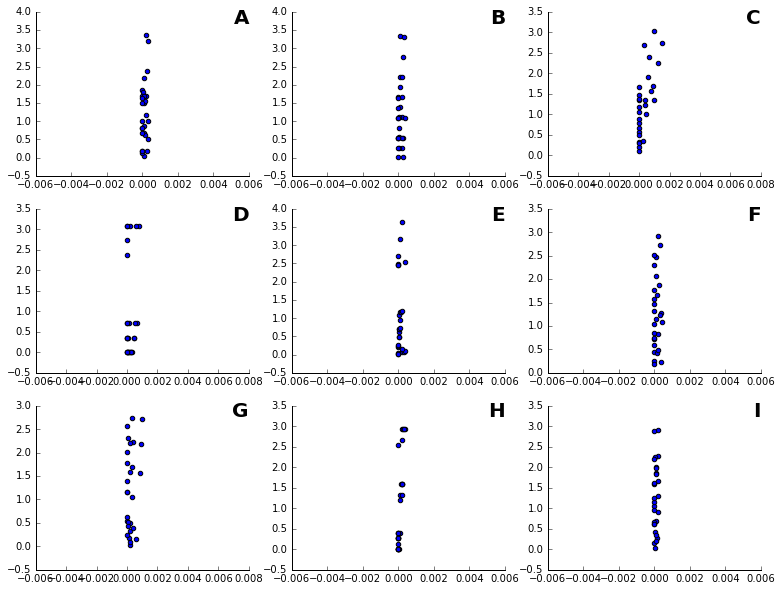

In [223]:
with PdfPages('/home/lindb/wbp/figures/abs_dij_v_envdist_sameenv_AWSO-Lat.pdf') as pdf:
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6),(a7,a8,a9)) = plt.subplots(3, 3, figsize=(5,5),dpi=400)

    a1 = plt.subplot(331)
    a1.scatter(shiftlst['AWS0-25'],distlst['AWS0-25'])
    a1.set_title('A',y=.9,loc='right',fontsize=20,fontweight='bold')
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    
    a2 = plt.subplot(332)
    a2.scatter(shiftlst['AWS0-50'],distlst['AWS0-50'])
    a2.set_title('B',y=.9,loc='right',fontsize=20,fontweight='bold')
    a2.spines['right'].set_visible(False)
    a2.spines['top'].set_visible(False)
    a2.yaxis.set_ticks_position('left')
    a2.xaxis.set_ticks_position('bottom')
    
    a3 = plt.subplot(333)
    a3.scatter(shiftlst['Ann-ppt'],distlst['Ann-ppt'])
    a3.set_title('C',y=.9,loc='right',fontsize=20,fontweight='bold')
    a3.spines['right'].set_visible(False)
    a3.spines['top'].set_visible(False)
    a3.yaxis.set_ticks_position('left')
    a3.xaxis.set_ticks_position('bottom')
    
    a4 = plt.subplot(334)
    a4.scatter(shiftlst['CEC'],distlst['CEC'])
    a4.set_title('D',y=.9,loc='right',fontsize=20,fontweight='bold')
    a4.spines['right'].set_visible(False)
    a4.spines['top'].set_visible(False)
    a4.yaxis.set_ticks_position('left')
    a4.xaxis.set_ticks_position('bottom')
    
    a5 = plt.subplot(335)
    a5.scatter(shiftlst['Clay'],distlst['Clay'])
    a5.set_title('E',y=.9,loc='right',fontsize=20,fontweight='bold')
    a5.spines['right'].set_visible(False)
    a5.spines['top'].set_visible(False)
    a5.yaxis.set_ticks_position('left')
    a5.xaxis.set_ticks_position('bottom')
    
    a6 = plt.subplot(336)
    a6.scatter(shiftlst['Elev'],distlst['Elev'])
    a6.set_title('F',y=.9,loc='right',fontsize=20,fontweight='bold')
    a6.spines['right'].set_visible(False)
    a6.spines['top'].set_visible(False)
    a6.yaxis.set_ticks_position('left')
    a6.xaxis.set_ticks_position('bottom')
    
    a7 = plt.subplot(337)
    a7.scatter(shiftlst['GDD-Aug'],distlst['GDD-Aug'])
    a7.set_title('G',y=.9,loc='right',fontsize=20,fontweight='bold')
    a7.spines['right'].set_visible(False)
    a7.spines['top'].set_visible(False)
    a7.yaxis.set_ticks_position('left')
    a7.xaxis.set_ticks_position('bottom')
    
    a8 = plt.subplot(338)
    a8.scatter(shiftlst['GDD-May'],distlst['GDD-May'])
    a8.set_title('H',y=.9,loc='right',fontsize=20,fontweight='bold')
    a8.spines['right'].set_visible(False)
    a8.spines['top'].set_visible(False)
    a8.yaxis.set_ticks_position('left')
    a8.xaxis.set_ticks_position('bottom')
    
    a9 = plt.subplot(339)
    a9.scatter(shiftlst['Lat'],distlst['Lat'])
    a9.set_title('I',y=.9,loc='right',fontsize=20,fontweight='bold')
    a9.spines['right'].set_visible(False)
    a9.spines['top'].set_visible(False)
    a9.yaxis.set_ticks_position('left')
    a9.xaxis.set_ticks_position('bottom')
    
    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

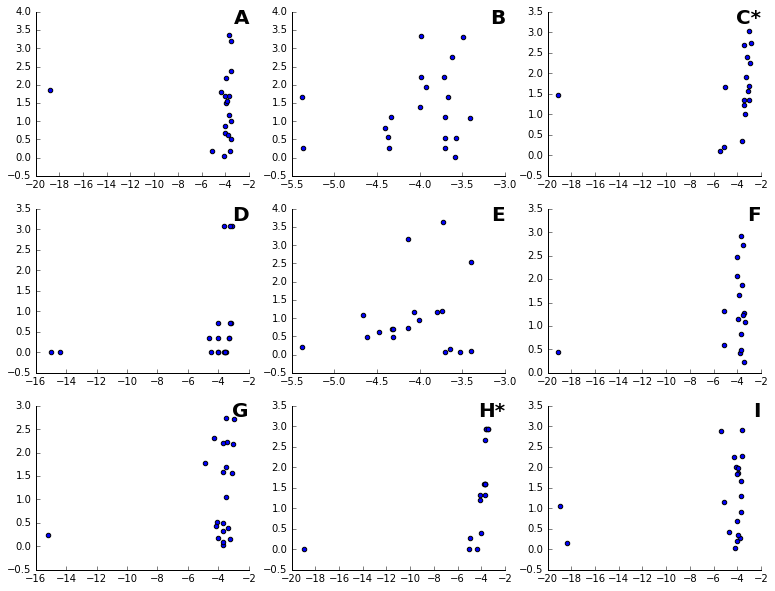

In [225]:
with PdfPages('/home/lindb/wbp/figures/log_abs_dij_v_envdist_sameenv_AWSO-Lat.pdf') as pdf:
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6),(a7,a8,a9)) = plt.subplots(3, 3, figsize=(5,5),dpi=400)

    a1 = plt.subplot(331)
    a1.scatter([math.log(x,10) for x in shiftlst['AWS0-25'] if x != 0],[x for i,x in enumerate(distlst['AWS0-25']) if shiftlst['AWS0-25'][i] !=0])
    a1.set_title('A',y=.9,loc='right',fontsize=20,fontweight='bold')
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    
    a2 = plt.subplot(332)
    a2.scatter([math.log(x,10) for x in shiftlst['AWS0-50'] if x != 0],[x for i,x in enumerate(distlst['AWS0-50']) if shiftlst['AWS0-50'][i] !=0])
    a2.set_title('B',y=.9,loc='right',fontsize=20,fontweight='bold')
    a2.spines['right'].set_visible(False)
    a2.spines['top'].set_visible(False)
    a2.yaxis.set_ticks_position('left')
    a2.xaxis.set_ticks_position('bottom')
    
    a3 = plt.subplot(333)
    a3.scatter([math.log(x,10) for x in shiftlst['Ann-ppt'] if x != 0],[x for i,x in enumerate(distlst['Ann-ppt']) if shiftlst['Ann-ppt'][i] !=0])
    a3.set_title('C*',y=.9,loc='right',fontsize=20,fontweight='bold')
    a3.spines['right'].set_visible(False)
    a3.spines['top'].set_visible(False)
    a3.yaxis.set_ticks_position('left')
    a3.xaxis.set_ticks_position('bottom')
    
    a4 = plt.subplot(334)
    a4.scatter([math.log(x,10) for x in shiftlst['CEC'] if x != 0],[x for i,x in enumerate(distlst['CEC']) if shiftlst['CEC'][i] !=0])
    a4.set_title('D',y=.9,loc='right',fontsize=20,fontweight='bold')
    a4.spines['right'].set_visible(False)
    a4.spines['top'].set_visible(False)
    a4.yaxis.set_ticks_position('left')
    a4.xaxis.set_ticks_position('bottom')
    
    a5 = plt.subplot(335)
    a5.scatter([math.log(x,10) for x in shiftlst['Clay'] if x != 0],[x for i,x in enumerate(distlst['Clay']) if shiftlst['Clay'][i] !=0])
    a5.set_title('E',y=.9,loc='right',fontsize=20,fontweight='bold')
    a5.spines['right'].set_visible(False)
    a5.spines['top'].set_visible(False)
    a5.yaxis.set_ticks_position('left')
    a5.xaxis.set_ticks_position('bottom')
    
    a6 = plt.subplot(336)
    a6.scatter([math.log(x,10) for x in shiftlst['Elev'] if x != 0],[x for i,x in enumerate(distlst['Elev']) if shiftlst['Elev'][i] !=0])
    a6.set_title('F',y=.9,loc='right',fontsize=20,fontweight='bold')
    a6.spines['right'].set_visible(False)
    a6.spines['top'].set_visible(False)
    a6.yaxis.set_ticks_position('left')
    a6.xaxis.set_ticks_position('bottom')
    
    a7 = plt.subplot(337)
    a7.scatter([math.log(x,10) for x in shiftlst['GDD-Aug'] if x != 0],[x for i,x in enumerate(distlst['GDD-Aug']) if shiftlst['GDD-Aug'][i] !=0])
    a7.set_title('G',y=.9,loc='right',fontsize=20,fontweight='bold')
    a7.spines['right'].set_visible(False)
    a7.spines['top'].set_visible(False)
    a7.yaxis.set_ticks_position('left')
    a7.xaxis.set_ticks_position('bottom')
    
    a8 = plt.subplot(338)
    a8.scatter([math.log(x,10) for x in shiftlst['GDD-May'] if x != 0],[x for i,x in enumerate(distlst['GDD-May']) if shiftlst['GDD-May'][i] !=0])
    a8.set_title('H*',y=.9,loc='right',fontsize=20,fontweight='bold')
    a8.spines['right'].set_visible(False)
    a8.spines['top'].set_visible(False)
    a8.yaxis.set_ticks_position('left')
    a8.xaxis.set_ticks_position('bottom')
    
    a9 = plt.subplot(339)
    a9.scatter([math.log(x,10) for x in shiftlst['Lat'] if x != 0],[x for i,x in enumerate(distlst['Lat']) if shiftlst['Lat'][i] !=0])
    a9.set_title('I',y=.9,loc='right',fontsize=20,fontweight='bold')
    a9.spines['right'].set_visible(False)
    a9.spines['top'].set_visible(False)
    a9.yaxis.set_ticks_position('left')
    a9.xaxis.set_ticks_position('bottom')
    
    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

In [227]:
#distance correlations for env Dij among outliers against the same env Euclidian distance 
#corrected
for env in sorted(shiftDF.keys()):
    mant = mantel(shiftDF[env],envdDict[env],permutations=9999)
    if mant[1] <= 0.05:
        print env, mant

Ann-ppt (0.71348170791623622, 0.0022000000000000001, 8)
GDD-May (0.84802319756761879, 0.0014, 8)
Lon (0.65221920594519789, 0.0011999999999999999, 8)
Rock-cov (0.51236410693757539, 0.016400000000000001, 8)
Sand (0.55740051976094096, 0.0050000000000000001, 8)
Tmin-Jan (0.57914543232407012, 0.014500000000000001, 8)
WC3rdbar (0.48059138657053446, 0.036299999999999999, 8)


In [1410]:
#distance correlations for env Dij among outliers against the same env Euclidian distance 
#old
for env in shiftDF.keys():
    mant = mantel(shiftDF[env],envdDict[env],permutations=9999)
    if mant[1] <= 0.05:
        print env, mant

Ann-ppt (0.71348170791623622, 0.0027000000000000001, 8)
GDD-May (0.84802319756761879, 0.0012999999999999999, 8)
Lon (0.65221920594519789, 0.0023999999999999998, 8)
Rock-cov (0.51236410693757539, 0.014500000000000001, 8)
Sand (0.55740051976094096, 0.0045999999999999999, 8)
Tmin-Jan (0.57914543232407012, 0.0137, 8)
WC3rdbar (0.48059138657053446, 0.0361, 8)


In [228]:
#distance correlations for env Dij among outliers against other env Euclidian distances - deleted print to comment
#corrected
mant = OrderedDict()
for i,envi in enumerate(sorted(shiftDF.keys())):
    mant[envi] = OrderedDict()
    for j,envj in enumerate(sorted(envdDict.keys())):
        if i > j:
            mant[envi][envj] = mantel(shiftDF[envi],envdDict[envj],permutations=9999) # ,permutations=9999
            #print envi,envj, mant[1]
            if mant[envi][envj][1] <= 0.05:
                print envi,'loci Dij vs ',envj,'Euclidian distances\n',mant[envi][envj],'\n' 

Lon loci Dij vs  Ann-ppt Euclidian distances
(0.7716010350739726, 0.0016000000000000001, 8) 

Lon loci Dij vs  Lat Euclidian distances
(-0.42566652606664973, 0.035400000000000001, 8) 

Rock-cov loci Dij vs  Ann-ppt Euclidian distances
(0.55424357362000032, 0.020500000000000001, 8) 

Rock-cov loci Dij vs  Lon Euclidian distances
(0.55685544364774331, 0.024799999999999999, 8) 

Sand loci Dij vs  Clay Euclidian distances
(0.53454002690746905, 0.022200000000000001, 8) 

Silt loci Dij vs  Sand Euclidian distances
(0.44079182582652993, 0.023400000000000001, 8) 

Tmin-Jan loci Dij vs  Ann-ppt Euclidian distances
(0.57650137127397227, 0.010699999999999999, 8) 

Tmin-Jan loci Dij vs  Lon Euclidian distances
(0.48221840890815115, 0.030499999999999999, 8) 

WC15Bar loci Dij vs  Tmax-July Euclidian distances
(0.34904867738608325, 0.032000000000000001, 8) 

WC3rdbar loci Dij vs  AWS0-25 Euclidian distances
(0.43294142988706169, 0.043999999999999997, 8) 

WC3rdbar loci Dij vs  AWS0-50 Euclidian dist

In [1412]:
#distance correlations for env Dij among outliers against other env Euclidian distances - deleted print to comment
#old
mant = OrderedDict()
for i,envi in enumerate(shiftDF.keys()):
    mant[envi] = OrderedDict()
    for j,envj in enumerate(envdDict.keys()):
        if i > j:
            mant[envi][envj] = mantel(shiftDF[envi],envdDict[envj],permutations=9999) # ,permutations=9999
            #print envi,envj, mant[1]
            if mant[envi][envj][1] <= 0.05:
                print envi,'loci Dij vs ',envj,'Euclidian distances\n',mant[envi][envj],'\n' 
#Lon loci Dij vs  Ann-ppt Euclidian distances
#(0.7716010350739726, 0.0016000000000000001, 8) 
#
#Lon loci Dij vs  Lat Euclidian distances
#(-0.42566652606664973, 0.0332, 8) 
#
#Rock-cov loci Dij vs  Ann-ppt Euclidian distances
#(0.55424357362000032, 0.022200000000000001, 8) 
#
#Rock-cov loci Dij vs  Lon Euclidian distances
#(0.55685544364774331, 0.0252, 8) 
#
#Sand loci Dij vs  Clay Euclidian distances
#(0.53454002690746905, 0.0207, 8) 
#
#Silt loci Dij vs  Sand Euclidian distances
#(0.44079182582652993, 0.023699999999999999, 8) 
#
#Tmin-Jan loci Dij vs  Ann-ppt Euclidian distances
#(0.57650137127397227, 0.0135, 8) 
#
#Tmin-Jan loci Dij vs  Lon Euclidian distances
#(0.48221840890815115, 0.028799999999999999, 8) 
#
#WC15Bar loci Dij vs  Tmax-July Euclidian distances
#(0.34904867738608325, 0.028500000000000001, 8) 
#
#WC3rdbar loci Dij vs  AWS0-25 Euclidian distances
#(0.43294142988706169, 0.036600000000000001, 8) 
#
#WC3rdbar loci Dij vs  AWS0-50 Euclidian distances
#(0.45379228695092727, 0.046699999999999998, 8) 
#
#WC3rdbar loci Dij vs  Tmax-July Euclidian distances
#(0.45389697231068271, 0.0030999999999999999, 8) 
#
#WC3rdbar loci Dij vs  WC15Bar Euclidian distances
#(0.51257777427440188, 0.029499999999999998, 8) 

Lon loci Dij vs  Ann-ppt Euclidian distances
(0.7716010350739726, 0.0016000000000000001, 8) 

Lon loci Dij vs  Lat Euclidian distances
(-0.42566652606664973, 0.034700000000000002, 8) 

Rock-cov loci Dij vs  Ann-ppt Euclidian distances
(0.55424357362000032, 0.022100000000000002, 8) 

Rock-cov loci Dij vs  Lon Euclidian distances
(0.55685544364774331, 0.028400000000000002, 8) 

Sand loci Dij vs  Clay Euclidian distances
(0.53454002690746905, 0.023199999999999998, 8) 

Silt loci Dij vs  Sand Euclidian distances
(0.44079182582652993, 0.023800000000000002, 8) 

Tmin-Jan loci Dij vs  Ann-ppt Euclidian distances
(0.57650137127397227, 0.0132, 8) 

Tmin-Jan loci Dij vs  Lon Euclidian distances
(0.48221840890815115, 0.027300000000000001, 8) 

WC15Bar loci Dij vs  Tmax-July Euclidian distances
(0.34904867738608325, 0.0309, 8) 

WC3rdbar loci Dij vs  AWS0-25 Euclidian distances
(0.43294142988706169, 0.037100000000000001, 8) 

WC3rdbar loci Dij vs  AWS0-50 Euclidian distances
(0.45379228695092727, 

In [1413]:
len(sigenvs)

15

In [230]:
#look for patters from euclidian dists
#corrected
eucs = OrderedDict()
for i,envi in enumerate(sorted(envdDict.keys())):
    eucs[envi] = OrderedDict()
    for j,envj in enumerate(sorted(envdDict.keys())):
        if i > j:
            eucs[envi][envj] = mantel(envdDict[envi],envdDict[envj],permutations = 9999)
            if eucs[envi][envj][1] <=0.05:
                print envi,envj,eucs[envi][envj]

AWS0-50 AWS0-25 (0.92563195780663798, 0.00089999999999999998, 8)
Clay CEC (0.94243026430775967, 0.0018, 8)
Lon Ann-ppt (0.7145343340679835, 0.0018, 8)
Max-rad-input Lat (0.46285891784178229, 0.030700000000000002, 8)
Sand AWS0-50 (0.43931703114531706, 0.019400000000000001, 8)
Sand Clay (0.3723300732412157, 0.0361, 8)
Silt AWS0-25 (0.56910810657784439, 0.021600000000000001, 8)
Silt AWS0-50 (0.75523793270279638, 0.0045999999999999999, 8)
Silt Sand (0.83954421938148982, 0.00029999999999999997, 8)
Tmin-Jan GDD-Aug (0.45450267193847571, 0.040099999999999997, 8)
WC15Bar AWS0-25 (0.67219012746044704, 0.0109, 8)
WC15Bar AWS0-50 (0.8511126463087334, 0.0023999999999999998, 8)
WC15Bar Silt (0.68065119836969423, 0.0138, 8)
WC3rdbar AWS0-25 (0.60929292004599522, 0.017999999999999999, 8)
WC3rdbar AWS0-50 (0.77608813807768406, 0.0053, 8)
WC3rdbar Silt (0.55818888588782412, 0.0327, 8)
WC3rdbar WC15Bar (0.94230567933893883, 0.00029999999999999997, 8)


In [1414]:
#look for patters from euclidian dists
#old
eucs = OrderedDict()
for i,envi in enumerate(envdDict.keys()):
    eucs[envi] = OrderedDict()
    for j,envj in enumerate(envdDict.keys()):
        if i > j:
            eucs[envi][envj] = mantel(envdDict[envi],envdDict[envj],permutations = 9999)
            if eucs[envi][envj][1] <=0.05:
                print envi,envj,eucs[envi][envj]
#AWS0-50 AWS0-25 (0.92563195780663798, 0.00059999999999999995, 8)
#Clay CEC (0.94243026430775967, 0.0015, 8)
#Lat Elev (0.39876994024295709, 0.045199999999999997, 8)
#Lon Ann-ppt (0.7145343340679835, 0.0022000000000000001, 8)
#Max-rad-input Lat (0.46285891784178229, 0.033000000000000002, 8)
#Sand AWS0-50 (0.43931703114531706, 0.018800000000000001, 8)
#Sand Clay (0.3723300732412157, 0.032500000000000001, 8)
#Silt AWS0-25 (0.56910810657784439, 0.020500000000000001, 8)
#Silt AWS0-50 (0.75523793270279638, 0.0057000000000000002, 8)
#Silt Sand (0.83954421938148982, 0.0001, 8)
#Tmin-Jan GDD-Aug (0.45450267193847571, 0.0361, 8)
#WC15Bar AWS0-25 (0.67219012746044704, 0.01, 8)
#WC15Bar AWS0-50 (0.8511126463087334, 0.002, 8)
#WC15Bar Silt (0.68065119836969423, 0.0152, 8)
#WC3rdbar AWS0-25 (0.60929292004599522, 0.0177, 8)
#WC3rdbar AWS0-50 (0.77608813807768406, 0.0057000000000000002, 8)
#WC3rdbar Silt (0.55818888588782412, 0.030099999999999998, 8)
#WC3rdbar WC15Bar (0.94230567933893883, 0.00020000000000000001, 8)

AWS0-50 AWS0-25 (0.92563195780663798, 0.00059999999999999995, 8)
Clay CEC (0.94243026430775967, 0.0015, 8)
Lat Elev (0.39876994024295709, 0.045199999999999997, 8)
Lon Ann-ppt (0.7145343340679835, 0.0022000000000000001, 8)
Max-rad-input Lat (0.46285891784178229, 0.033000000000000002, 8)
Sand AWS0-50 (0.43931703114531706, 0.018800000000000001, 8)
Sand Clay (0.3723300732412157, 0.032500000000000001, 8)
Silt AWS0-25 (0.56910810657784439, 0.020500000000000001, 8)
Silt AWS0-50 (0.75523793270279638, 0.0057000000000000002, 8)
Silt Sand (0.83954421938148982, 0.0001, 8)
Tmin-Jan GDD-Aug (0.45450267193847571, 0.0361, 8)
WC15Bar AWS0-25 (0.67219012746044704, 0.01, 8)
WC15Bar AWS0-50 (0.8511126463087334, 0.002, 8)
WC15Bar Silt (0.68065119836969423, 0.0152, 8)
WC3rdbar AWS0-25 (0.60929292004599522, 0.0177, 8)
WC3rdbar AWS0-50 (0.77608813807768406, 0.0057000000000000002, 8)
WC3rdbar Silt (0.55818888588782412, 0.030099999999999998, 8)
WC3rdbar WC15Bar (0.94230567933893883, 0.00020000000000000001, 8)


In [232]:
#patterns of environmental distance to geographic distance
#corrected
for env in sorted(envdDict.keys()):
    mant = mantel(envdDict[env],geodist,permutations=9999)
    #if mant[1] <= 0.05:
        #print env,mant
    print env,mant

AWS0-25 (-0.1060861171006412, 0.62560000000000004, 8)
AWS0-50 (-0.106624148767756, 0.70599999999999996, 8)
Ann-ppt (-0.18252905307040002, 0.29060000000000002, 8)
CEC (0.24308086638413515, 0.14510000000000001, 8)
Clay (0.27161756617669397, 0.091999999999999998, 8)
Elev (0.40617770554536686, 0.044200000000000003, 8)
GDD-Aug (0.060192865042875139, 0.74729999999999996, 8)
GDD-May (0.09155988138796603, 0.74570000000000003, 8)
Lat (0.9630665050112448, 0.0001, 8)
Lon (0.1159424822488944, 0.52280000000000004, 8)
Max-rad-input (0.39916883319044999, 0.047, 8)
Rock-cov (-0.0013653758034187298, 0.99419999999999997, 8)
Sand (-0.065400320530522429, 0.71909999999999996, 8)
Silt (-0.11938536549339875, 0.58240000000000003, 8)
Tmax-July (0.36685027020170113, 0.073599999999999999, 8)
Tmin-Jan (-0.0085023744946686759, 0.96399999999999997, 8)
WC15Bar (0.080797777802775472, 0.79749999999999999, 8)
WC3rdbar (0.19001363716445102, 0.3216, 8)


In [1415]:
#patterns of environmental distance to geographic distance
#old
for env in envdDict.keys():
    mant = mantel(envdDict[env],geodist,permutations=9999)
    #if mant[1] <= 0.05:
        #print env,mant
    print env,mant
#AWS0-25 (-0.10608611710064117, 0.6159, 8)
#AWS0-50 (-0.10662414876775597, 0.69989999999999997, 8)
#Ann-ppt (-0.1825290530704001, 0.28789999999999999, 8)
#CEC (0.24308086638413512, 0.15240000000000001, 8)
#Clay (0.27161756617669391, 0.091499999999999998, 8)
#Elev (0.40617770554536675, 0.044400000000000002, 8)
#GDD-Aug (0.060192865042875195, 0.73899999999999999, 8)
#GDD-May (0.091559881387966044, 0.74639999999999995, 8)
#Lat (0.96306650501124502, 0.00020000000000000001, 8)
#Lon (0.11594248224889436, 0.51459999999999995, 8)
#Max-rad-input (0.39916883319045005, 0.044600000000000001, 8)
#Rock-cov (-0.0013653758034187704, 0.99319999999999997, 8)
#Sand (-0.065400320530522443, 0.70289999999999997, 8)
#Silt (-0.11938536549339876, 0.5847, 8)
#Tmax-July (0.36685027020170108, 0.0717, 8)
#Tmin-Jan (-0.008502374494668636, 0.96970000000000001, 8)
#WC15Bar (0.080797777802775472, 0.79679999999999995, 8)
#WC3rdbar (0.19001363716445102, 0.30890000000000001, 8)

AWS0-25 (-0.10608611710064117, 0.6159, 8)
AWS0-50 (-0.10662414876775597, 0.69989999999999997, 8)
Ann-ppt (-0.1825290530704001, 0.28789999999999999, 8)
CEC (0.24308086638413512, 0.15240000000000001, 8)
Clay (0.27161756617669391, 0.091499999999999998, 8)
Elev (0.40617770554536675, 0.044400000000000002, 8)
GDD-Aug (0.060192865042875195, 0.73899999999999999, 8)
GDD-May (0.091559881387966044, 0.74639999999999995, 8)
Lat (0.96306650501124502, 0.00020000000000000001, 8)
Lon (0.11594248224889436, 0.51459999999999995, 8)
Max-rad-input (0.39916883319045005, 0.044600000000000001, 8)
Rock-cov (-0.0013653758034187704, 0.99319999999999997, 8)
Sand (-0.065400320530522443, 0.70289999999999997, 8)
Silt (-0.11938536549339876, 0.5847, 8)
Tmax-July (0.36685027020170108, 0.0717, 8)
Tmin-Jan (-0.008502374494668636, 0.96970000000000001, 8)
WC15Bar (0.080797777802775472, 0.79679999999999995, 8)
WC3rdbar (0.19001363716445102, 0.30890000000000001, 8)


# split positive and negative Dij and run mantel tests

In [1416]:
#do pairwise pops for empirical SNPs IDed by bayenv2 and calculate median Dij for each pop pair
def getrawshiftDict(tokens):
    import pandas as pd
    import numpy as np
    import os
    from collections import OrderedDict
    
    env,impMAF,popDict = tokens
    
    shiftDictpos = OrderedDict() 
    shiftDictneg = OrderedDict()
    kcount = 0
    print env
    filE = '/home/lindb/wbp/bayenv2/results/sigsnps/%s_top_p05%%BF_1%%rho.txt' % env
    df = pd.read_csv(filE,header=0,sep='\t')
    outliersnps = df[env].tolist()
    for m,popm in enumerate(impMAF.columns):
        print popm
        shiftDictpos[popm] = OrderedDict()
        shiftDictneg[popm] = OrderedDict()
        for l,popl in enumerate(impMAF.columns):
            if m>l: #only need to do the lower triangle - can reflect across diagonal later more quickly
                dijlist = []
                for i,locusi in enumerate(outliersnps):
                    for j,locusj in enumerate(outliersnps):
                        if i > j: #i=row, j=col : lower triangle 
                            sums =0 #Dij
                            kcount += 1
                            for popk in [popm,popl]:
                                qik = impMAF.loc[locusi,popk]        #get locusi maf for pop k
                                qjk = impMAF.loc[locusj,popk]        #get locusj maf for pop k
                                nk = popDict[popk]                   #N  individuals  in pop k

                                globN = 2*(popDict[popm]+popDict[popl]) # number of alleles across 2 pops

                                #get global mafs
                                fqim = impMAF.loc[locusi,popm]        #minor allele locusi freq  in popm
                                nqim = round(fqim*2*popDict[popm])    #minor allele locusi count in popm
                                fqil = impMAF.loc[locusi,popl]        #minor allele locusi freq  in popl
                                nqil = round(fqil*2*popDict[popl])    #minor allele locusi count in popl

                                fqjm = impMAF.loc[locusj,popm]        #minor allele locusj freq  in popm
                                nqjm = round(fqjm*2*popDict[popm])    #minor allele locusj count in popm
                                fqjl = impMAF.loc[locusj,popl]        #minor allele locusj freq  in popl
                                nqjl = round(fqjl*2*popDict[popl])    #minor allele locusj count in popl

                                qi = float(nqim+nqil)/float((2*popDict[popm])+(2*popDict[popl])) #global maf locusi
                                qj = float(nqjm+nqjl)/float((2*popDict[popm])+(2*popDict[popl])) #global maf locusj

                                sums += (float(nk)/float(popDict[popm]+popDict[popl]))*((qik*qjk)-(qi*qj))

                            dijlist.append(sums) #each pairwise pop comparison has a matrix of Dij
                        else:
                            pass #no redundancies, no diagonal. 
                pos = [x for x in dijlist if x >= 0]
                neg = [x for x in dijlist if x <=  0]
                shiftDictpos[popm][popl] = np.median([d for d in pos])
                shiftDictneg[popm][popl] = np.median([d for d in neg])
                
            else:
                shiftDictpos[popm][popl] = np.nan #no redundancies,no diagonal. will be faster to reflect across diag later
                shiftDictneg[popm][popl] = np.nan #no redundancies,no diagonal. will be faster to reflect across diag later
    #    if kcount > 1:
    #        break
    filE = '/home/lindb/wbp/bayenv2/freqshifts/%s_pop_pairwise_median_positive_dij_withzeros.txt' % env 
    with open(filE,'w') as o:
        key0 = shiftDictpos.keys()[0]
        line = '\t'.join(shiftDictpos[key0].keys()) + str('\n')
        o.write("%s" % line)
        for popk in shiftDictpos.keys():
            text = str(popk)+'\t'+'\t'.join([str(d) for d in shiftDictpos[popk].values()])+'\n'
            o.write("%s" % text)
            
    filE = '/home/lindb/wbp/bayenv2/freqshifts/%s_pop_pairwise_median_negative_dij_withzeros.txt' % env 
    with open(filE,'w') as o:
        key0 = shiftDictneg.keys()[0]
        line = '\t'.join(shiftDictneg[key0].keys()) + str('\n')
        o.write("%s" % line)
        for popk in shiftDictneg.keys():
            text = str(popk)+'\t'+'\t'.join([str(d) for d in shiftDictneg[popk].values()])+'\n'
            o.write("%s" % text)
    return "done"

In [1417]:
jobs = []
for env in outlierdata.keys():
    jobs.append(lview.apply_async(getrawshiftDict,[env,impMAF,popDict]))

In [1446]:
count = 0
for j in jobs:
    if j.ready():
        count += 1
count

13

In [1273]:
nozeroposDF = OrderedDict()
for env in outlierdata.keys():
    filE = '/home/lindb/wbp/bayenv2/freqshifts/%s_pop_pairwise_median_positive_dij_nozeros.txt' % env
    nozeroposDF[env] = pd.read_csv(filE,header=0,index_col=0,sep='\t')
    for i,row in enumerate(nozeroposDF[env].index):
        for j,col in enumerate(nozeroposDF[env].columns):
            if i == j:
                nozeroposDF[env].loc[row,col] = 0
            elif math.isnan(float(nozeroposDF[env].loc[row,col])) == True:
                nozeroposDF[env].loc[row,col] = nozeroposDF[env].loc[col,row]
    filE = filE.split(".")[0]
    filE =  "%s_symm.txt" % filE
    print filE
    nozeroposDF[env].to_csv(filE,header=True,index=True,sep='\t')

/home/lindb/wbp/bayenv2/freqshifts/AWS0-25_pop_pairwise_median_positive_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/AWS0-50_pop_pairwise_median_positive_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Ann-ppt_pop_pairwise_median_positive_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/CEC_pop_pairwise_median_positive_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Clay_pop_pairwise_median_positive_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Elev_pop_pairwise_median_positive_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/GDD-Aug_pop_pairwise_median_positive_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/GDD-May_pop_pairwise_median_positive_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Lat_pop_pairwise_median_positive_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Lon_pop_pairwise_median_positive_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Max-rad-input_pop_pairwise_median_positive_dij_nozero

In [1274]:
nozeroposDF['Ann-ppt']

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,0.000000,0.001918,0.002400,0.002400,0.001622,2.448980e-03,3.061224e-03,1.650701e-03
Freel_Peak,0.001918,0.000000,0.000086,0.000086,0.000028,9.645062e-05,1.205633e-04,2.893519e-04
Heavenly,0.002400,0.000086,0.000000,0.000400,0.000177,2.040816e-04,4.081633e-04,2.603082e-05
Little_Round_Top,0.002400,0.000086,0.000400,0.000000,0.000270,2.040816e-04,4.081633e-04,2.603082e-05
Mt_Rose_Ophir,0.001622,0.000028,0.000177,0.000270,0.000000,1.637970e-04,3.494549e-04,2.932070e-04
Rifle_Peak,0.002449,0.000096,0.000204,0.000204,0.000164,0.000000e+00,4.340278e-04,1.388863e-15
Snow_Valley_Peak,0.003061,0.000121,0.000408,0.000408,0.000349,4.340278e-04,0.000000e+00,1.041701e-15
West_Shore_Peaks,0.001651,0.000289,0.000026,0.000026,0.000293,1.388863e-15,1.041701e-15,0.000000e+00


In [1275]:
nozeronegDF = OrderedDict()
for env in outlierdata.keys():
    filE = '/home/lindb/wbp/bayenv2/freqshifts/%s_pop_pairwise_median_negative_dij_nozeros.txt' % env
    nozeronegDF[env] = pd.read_csv(filE,header=0,index_col=0,sep='\t')
    for i,row in enumerate(nozeronegDF[env].index):
        for j,col in enumerate(nozeronegDF[env].columns):
            if i == j:
                nozeronegDF[env].loc[row,col] = 0
            elif nozeronegDF[env].loc[row,col] == 'zero':
                print 'zero',nozeronegDF[env].loc[row,col]
                nozeronegDF[env].loc[row,col] = float(0)
                print 'changed',nozeronegDF[env].loc[row,col]
            elif math.isnan(float(nozeronegDF[env].loc[row,col])) == True:
                nozeronegDF[env].loc[row,col] = nozeronegDF[env].loc[col,row]
    filE = filE.split(".")[0]
    filE =  "%s_symm.txt" % filE
    print filE
    nozeronegDF[env].to_csv(filE,header=True,index=True,sep='\t')

/home/lindb/wbp/bayenv2/freqshifts/AWS0-25_pop_pairwise_median_negative_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/AWS0-50_pop_pairwise_median_negative_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Ann-ppt_pop_pairwise_median_negative_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/CEC_pop_pairwise_median_negative_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Clay_pop_pairwise_median_negative_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Elev_pop_pairwise_median_negative_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/GDD-Aug_pop_pairwise_median_negative_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/GDD-May_pop_pairwise_median_negative_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Lat_pop_pairwise_median_negative_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Lon_pop_pairwise_median_negative_dij_nozeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Max-rad-input_pop_pairwise_median_negative_dij_nozero

In [1276]:
nozeronegDF['Ann-ppt']

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,0.000000e+00,NaN,NaN,-1.626303e-19,NaN,-4.201374e-04,NaN,-7.928988e-04
Freel_Peak,NaN,0.000000,-0.000116,-1.013323e-04,-0.000004,-9.645062e-05,-7.233796e-05,-1.205633e-04
Heavenly,NaN,-0.000116,0.000000,-4.000000e-04,-0.000273,-2.124115e-04,-4.164931e-06,-5.896849e-04
Little_Round_Top,-1.626303e-19,-0.000101,-0.000400,0.000000e+00,-0.000272,-4.071220e-04,-4.164931e-06,-7.982785e-04
Mt_Rose_Ophir,NaN,-0.000004,-0.000273,-2.720592e-04,0.000000,-1.688234e-04,NaN,-2.775693e-04
Rifle_Peak,-4.201374e-04,-0.000096,-0.000212,-4.071220e-04,-0.000169,0.000000e+00,-1.041701e-15,-4.340278e-04
Snow_Valley_Peak,NaN,-0.000072,-0.000004,-4.164931e-06,NaN,-1.041701e-15,0.000000e+00,-1.736025e-15
West_Shore_Peaks,-7.928988e-04,-0.000121,-0.000590,-7.982785e-04,-0.000278,-4.340278e-04,-1.736025e-15,0.000000e+00


In [1303]:
withzeroposDF = OrderedDict()
for env in outlierdata.keys():
    filE = '/home/lindb/wbp/bayenv2/freqshifts/%s_pop_pairwise_median_positive_dij_withzeros.txt' % env
    withzeroposDF[env] = pd.read_csv(filE,header=0,index_col=0,sep='\t')
    for i,row in enumerate(withzeroposDF[env].index):
        for j,col in enumerate(withzeroposDF[env].columns):
            if i == j:
                withzeroposDF[env].loc[row,col] = 0
            elif math.isnan(float(withzeroposDF[env].loc[row,col])) == True:
                withzeroposDF[env].loc[row,col] = withzeroposDF[env].loc[col,row]
    filE = filE.split(".")[0]
    filE =  "%s_symm.txt" % filE
    print filE
    withzeroposDF[env].to_csv(filE,header=True,index=True,sep='\t')

/home/lindb/wbp/bayenv2/freqshifts/AWS0-25_pop_pairwise_median_positive_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/AWS0-50_pop_pairwise_median_positive_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Ann-ppt_pop_pairwise_median_positive_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/CEC_pop_pairwise_median_positive_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Clay_pop_pairwise_median_positive_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Elev_pop_pairwise_median_positive_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/GDD-Aug_pop_pairwise_median_positive_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/GDD-May_pop_pairwise_median_positive_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Lat_pop_pairwise_median_positive_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Lon_pop_pairwise_median_positive_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Max-rad-input_pop_pairwise_median

In [1304]:
withzeronegDF = OrderedDict()
for env in outlierdata.keys():
    filE = '/home/lindb/wbp/bayenv2/freqshifts/%s_pop_pairwise_median_negative_dij_withzeros.txt' % env
    withzeronegDF[env] = pd.read_csv(filE,header=0,index_col=0,sep='\t')
    for i,row in enumerate(withzeronegDF[env].index):
        for j,col in enumerate(withzeronegDF[env].columns):
            if i == j:
                withzeronegDF[env].loc[row,col] = 0
            elif math.isnan(float(withzeronegDF[env].loc[row,col])) == True:
                withzeronegDF[env].loc[row,col] = withzeronegDF[env].loc[col,row]
    filE = filE.split(".")[0]
    filE =  "%s_symm.txt" % filE
    print filE
    withzeronegDF[env].to_csv(filE,header=True,index=True,sep='\t')

/home/lindb/wbp/bayenv2/freqshifts/AWS0-25_pop_pairwise_median_negative_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/AWS0-50_pop_pairwise_median_negative_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Ann-ppt_pop_pairwise_median_negative_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/CEC_pop_pairwise_median_negative_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Clay_pop_pairwise_median_negative_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Elev_pop_pairwise_median_negative_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/GDD-Aug_pop_pairwise_median_negative_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/GDD-May_pop_pairwise_median_negative_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Lat_pop_pairwise_median_negative_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Lon_pop_pairwise_median_negative_dij_withzeros_symm.txt
/home/lindb/wbp/bayenv2/freqshifts/Max-rad-input_pop_pairwise_median

In [1282]:
outlierdata.keys()

['AWS0-25',
 'AWS0-50',
 'Ann-ppt',
 'CEC',
 'Clay',
 'Elev',
 'GDD-Aug',
 'GDD-May',
 'Lat',
 'Lon',
 'Max-rad-input',
 'Rock-cov',
 'Sand',
 'Silt',
 'Tmax-July',
 'Tmin-Jan',
 'WC15Bar',
 'WC3rdbar']

In [1278]:
def setup_r(): 
    os.environ['R_HOME'] = '/home/lindb/g/R3/lib64/R/' 
    os.environ['LD_LIBRARY_PATH'] = "%s/lib:%s" % (os.environ['R_HOME'], 
                                                   os.environ['LD_LIBRARY_PATH'])

In [1279]:
setup_r()
import readline
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri as pd2ri
pd2ri.activate()
r = robjects.r

In [1280]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext rpy2.ipython
%matplotlib inline

In [1281]:
%%R
sessionInfo()

R version 3.2.2 (2015-08-14)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS release 6.7 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     


In [1283]:
%%R
envs = c('AWS0-25',
 'AWS0-50',
 'Ann-ppt',
 'CEC',
 'Clay',
 'Elev',
 'GDD-Aug',
 'GDD-May',
 'Lat',
 'Lon',
 'Max-rad-input',
 'Rock-cov',
 'Sand',
 'Silt',
 'Tmax-July',
 'Tmin-Jan',
 'WC15Bar',
 'WC3rdbar')

In [1333]:
%%R
#read in the Dij files
library(stringr)
nozerosneg = list()
for (env in envs){
    i = which(envs == env)
    f = "/home/lindb/wbp/bayenv2/freqshifts/%s_pop_pairwise_median_negative_dij_nozeros_symm.txt"
    filE = str_replace(f,"%s",env)
    nozerosneg[[i]] = read.table(filE,sep='\t',header=TRUE,row.names=1)
    names(nozerosneg)[i] = env
}
wzerosneg = list()
for (env in envs){
    i = which(envs == env)
    f = "/home/lindb/wbp/bayenv2/freqshifts/%s_pop_pairwise_median_negative_dij_withzeros_symm.txt"
    filE = str_replace(f,"%s",env)
    wzerosneg[[i]] = read.table(filE,sep='\t',header=TRUE,row.names=1)
    names(wzerosneg)[i] = env
}
nozerospos = list()
for (env in envs){
    i = which(envs == env)
    f = "/home/lindb/wbp/bayenv2/freqshifts/%s_pop_pairwise_median_positive_dij_nozeros_symm.txt"
    filE = str_replace(f,"%s",env)
    nozerospos[[i]] = read.table(filE,sep='\t',header=TRUE,row.names=1)
    names(nozerospos)[i] = env
}
wzerospos = list()
for (env in envs){
    i = which(envs == env)
    f = "/home/lindb/wbp/bayenv2/freqshifts/%s_pop_pairwise_median_positive_dij_withzeros_symm.txt"
    filE = str_replace(f,"%s",env)
    wzerospos[[i]] = read.table(filE,sep='\t',header=TRUE,row.names=1)
    names(wzerospos)[i] = env
}

In [1334]:
%%R
#get the environmental distance matrices
envdist = list()
for (env in envs){
    i = which(envs==env)
    f = "/home/lindb/wbp/distance_matrices/%s_dist_symm.txt"
    filE = str_replace(f,"%s",env)
    envdist[[i]] = read.table(filE,sep='\t',header=TRUE,row.names=1)
    names(envdist)[i] = env
}

In [1335]:
%%R
library(vegan)

In [1343]:
%%R
nozerosneg

$`AWS0-25`
                    Dicks_Pass    Freel_Peak      Heavenly Little_Round_Top
Dicks_Pass        0.0000000000 -2.814787e-04 -6.000000e-04    -4.000000e-04
Freel_Peak       -0.0002814787  0.000000e+00 -9.382623e-05    -1.013323e-04
Heavenly         -0.0006000000 -9.382623e-05  0.000000e+00    -4.000000e-04
Little_Round_Top -0.0004000000 -1.013323e-04 -4.000000e-04     0.000000e+00
Mt_Rose_Ophir    -0.0001826150 -1.084502e-06 -9.130752e-05    -1.136685e-04
Rifle_Peak       -0.0004164931 -9.645062e-05 -2.082466e-04    -1.249479e-05
Snow_Valley_Peak -0.0006115507 -4.822531e-05 -4.161461e-04    -4.078162e-04
West_Shore_Peaks -0.0037484382 -4.822531e-05 -2.082466e-04    -8.329863e-06
                 Mt_Rose_Ophir    Rifle_Peak Snow_Valley_Peak West_Shore_Peaks
Dicks_Pass       -1.826150e-04 -4.164931e-04    -6.115507e-04    -3.748438e-03
Freel_Peak       -1.084502e-06 -9.645062e-05    -4.822531e-05    -4.822531e-05
Heavenly         -9.130752e-05 -2.082466e-04    -4.161461e-04    -2.

In [1336]:
%%R
#run mantel tests for neg Dijs calculated without zeros
for(env in envs){
    i = which(envs==env)
    mant = mantel(nozerosneg[[env]],envdist[[env]],method="pearson",permutations=999,na.rm=TRUE)
    if (mant$signif <= 0.05){
        print(env)
        print(mant)        
    }
}

[1] "Max-rad-input"

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = nozerosneg[[env]], ydis = envdist[[env]], method = "pearson",      permutations = 999, na.rm = TRUE) 

Mantel statistic r: 0.5212 
      Significance: 0.048 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.393 0.513 0.584 0.658 
Permutation: free
Number of permutations: 999



In [1337]:
%%R
#run mantel tests for neg Dijs calculated with zeros
for(env in envs){
    i = which(envs==env)
    mant = mantel(wzerosneg[[env]],envdist[[env]],method="pearson",permutations=999,na.rm=TRUE)
    if (mant$signif <= 0.05){
        print(env)
        print(mant)        
    }
}

In [1340]:
%%R
#run mantel tests for pos Dijs calculated with zeros
for(env in envs){
    mant = mantel(wzerospos[[env]],envdist[[env]],method="pearson",permutations=999,na.rm=TRUE)
    if (mant$signif <= 0.05){
        print(env)
        print(mant)        
    }
}

[1] "Ann-ppt"

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = wzerospos[[env]], ydis = envdist[[env]], method = "pearson",      permutations = 999, na.rm = TRUE) 

Mantel statistic r: 0.4902 
      Significance: 0.008 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.349 0.434 0.463 0.483 
Permutation: free
Number of permutations: 999



In [1341]:
%%R
#run mantel tests for pos Dijs calculated without zeros
for(env in envs){
    mant = mantel(nozerospos[[env]],envdist[[env]],method="pearson",permutations=999,na.rm=TRUE)
    if (mant$signif <= 0.05){
        print(env)
        print(mant)        
    }
}

[1] "Ann-ppt"

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = nozerospos[[env]], ydis = envdist[[env]], method = "pearson",      permutations = 999, na.rm = TRUE) 

Mantel statistic r: 0.4617 
      Significance: 0.02 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.337 0.413 0.447 0.482 
Permutation: free
Number of permutations: 999



In [1346]:
%%R
annpptnozeros = nozerospos[['Ann-ppt']][lower.tri(nozerospos[['Ann-ppt']])]
annpptnozeros

 [1] 1.917808e-03 2.400000e-03 2.400000e-03 1.621622e-03 2.448980e-03
 [6] 3.061224e-03 1.650701e-03 8.632014e-05 8.632014e-05 2.767740e-05
[11] 9.645062e-05 1.205633e-04 2.893519e-04 4.000000e-04 1.772484e-04
[16] 2.040816e-04 4.081633e-04 2.603082e-05 2.702703e-04 2.040816e-04
[21] 4.081633e-04 2.603082e-05 1.637970e-04 3.494549e-04 2.932070e-04
[26] 4.340278e-04 1.388863e-15 1.041701e-15


In [1349]:
%%R
apptenvdist = envdist[['Ann-ppt']][lower.tri(envdist[['Ann-ppt']])]
apptenvdist

 [1] 2.2418130 3.0383793 1.5628832 1.6805195 1.3612208 2.7459689 0.3411455
 [8] 0.7965663 0.6789299 0.5612935 0.8805922 0.5041559 1.9006676 1.4754961
[15] 1.3578598 1.6771585 0.2924104 2.6972338 0.1176364 0.2016623 1.1830857
[22] 1.2217377 0.3192987 1.0654494 1.3393741 1.3847481 1.0200754 2.4048234


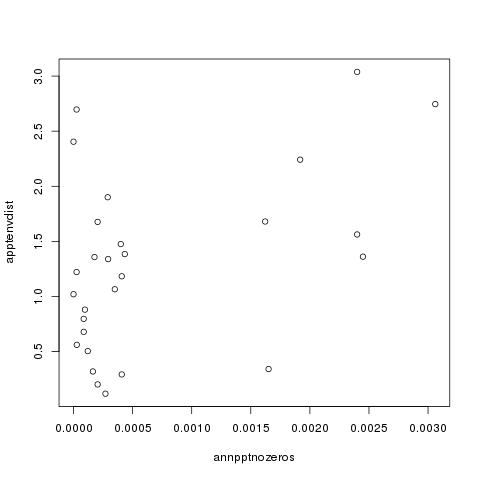

In [1350]:
%%R
plot(annpptnozeros,apptenvdist)

In [1245]:
#distance correlations for env Dij among outliers against the same env Euclidian distance - deleted print to comment
for env in posshiftDF.keys():
    mant = mantel(posshiftDF[env],envdDict[env],permutations=9999)
    if mant[1] <= 0.05:
        print env, mant

Ann-ppt (0.46167150576318017, 0.012999999999999999, 8)


In [1246]:
#distance correlations for env Dij among outliers against other env Euclidian distances - deleted print to comment
posmant= OrderedDict()
for i,envi in enumerate(posshiftDF.keys()):
    posmant[envi] = OrderedDict()
    for j,envj in enumerate(posshiftDF.keys()):
        if i > j:
            posmant[envi][envj] = mantel(posshiftDF[envi],envdDict[envj],permutations=999) # ,permutations=9999
            #print envi,envj, posmant[1]
            if posmant[envi][envj][1] <= 0.05:
                print envi,'loci Dij vs ',envj,'Euclidian distances\n',posmant[envi][envj],'\n' 

WC15Bar loci Dij vs  Ann-ppt Euclidian distances
(0.58248748185441168, 0.001, 8) 

WC15Bar loci Dij vs  Lon Euclidian distances
(0.38891675541982645, 0.031, 8) 



In [1200]:
#distance correlations for env Dij among outliers against the same env Euclidian distance - deleted print to comment
for env in negshiftDF.keys():
    mant = mantel(negshiftDF[env],envdDict[env],permutations=999)
    if mant[1] <= 0.05:
        print env, mant
#AWS0-50 (-0.5187120808294664, 0.048000000000000001, 8)
#Elev (-0.38386332885151592, 0.035999999999999997, 8)
#GDD-May (-0.49436024387658395, 0.025999999999999999, 8)
#Lat (-0.38351080073888355, 0.047, 8)
#Lon (-0.39247528366555717, 0.017000000000000001, 8)
#Silt (-0.50109539481141629, 0.035000000000000003, 8)
#WC15Bar (-0.55864761263082974, 0.050000000000000003, 8)

AWS0-50 (-0.5187120808294664, 0.048000000000000001, 8)
Elev (-0.38386332885151592, 0.035999999999999997, 8)
GDD-May (-0.49436024387658395, 0.025999999999999999, 8)
Lat (-0.38351080073888355, 0.047, 8)
Lon (-0.39247528366555717, 0.017000000000000001, 8)
Silt (-0.50109539481141629, 0.035000000000000003, 8)
WC15Bar (-0.55864761263082974, 0.050000000000000003, 8)


In [1204]:
#distance correlations for env Dij among outliers against other env Euclidian distances - deleted print to comment
negmant= OrderedDict()
for i,envi in enumerate(negshiftDF.keys()):
    negmant[envi] = OrderedDict()
    for j,envj in enumerate(negshiftDF.keys()):
        if i > j:
            negmant[envi][envj] = mantel(negshiftDF[envi],envdDict[envj],permutations=999) # ,permutations=9999
            #print envi,envj, negmant[1]
            if negmant[envi][envj][1] <= 0.05:
                print envi,'loci Dij vs ',envj,'Euclidian distances\n',negmant[envi][envj],'\n' 
#AWS0-50 loci Dij vs  AWS0-25 Euclidian distances
#(-0.45711120411044837, 0.049000000000000002, 8) 
#
#CEC loci Dij vs  Ann-ppt Euclidian distances
#(-0.39739357529313168, 0.032000000000000001, 8) 
#
#GDD-Aug loci Dij vs  Elev Euclidian distances
#(-0.43586420866039266, 0.031, 8) 
#
#Lat loci Dij vs  CEC Euclidian distances
#(-0.54522328655821961, 0.033000000000000002, 8) 
#
#Lat loci Dij vs  Elev Euclidian distances
#(-0.42828652409270873, 0.032000000000000001, 8) 
#
#Lon loci Dij vs  Ann-ppt Euclidian distances
#(-0.44268477932420164, 0.017000000000000001, 8) 
#
#Max-rad-input loci Dij vs  Ann-ppt Euclidian distances
#(-0.49073697619324924, 0.014999999999999999, 8) 
#
#Max-rad-input loci Dij vs  Lon Euclidian distances
#(-0.36898951713648914, 0.045999999999999999, 8) 
#
#Sand loci Dij vs  Clay Euclidian distances
#(-0.50749772113017022, 0.021000000000000001, 8) 
#
#Silt loci Dij vs  AWS0-25 Euclidian distances
#(-0.45042297309726187, 0.047, 8) 
#
#Silt loci Dij vs  Sand Euclidian distances
#(-0.38456814005183487, 0.047, 8) 
#
#WC15Bar loci Dij vs  AWS0-25 Euclidian distances
#(-0.51462685560320931, 0.029000000000000001, 8) 
#
#WC15Bar loci Dij vs  AWS0-50 Euclidian distances
#(-0.5537241770139858, 0.037999999999999999, 8)

AWS0-50 loci Dij vs  AWS0-25 Euclidian distances
(-0.45711120411044837, 0.049000000000000002, 8) 

CEC loci Dij vs  Ann-ppt Euclidian distances
(-0.39739357529313168, 0.032000000000000001, 8) 

GDD-Aug loci Dij vs  Elev Euclidian distances
(-0.43586420866039266, 0.031, 8) 

Lat loci Dij vs  CEC Euclidian distances
(-0.54522328655821961, 0.033000000000000002, 8) 

Lat loci Dij vs  Elev Euclidian distances
(-0.42828652409270873, 0.032000000000000001, 8) 

Lon loci Dij vs  Ann-ppt Euclidian distances
(-0.44268477932420164, 0.017000000000000001, 8) 

Max-rad-input loci Dij vs  Ann-ppt Euclidian distances
(-0.49073697619324924, 0.014999999999999999, 8) 

Max-rad-input loci Dij vs  Lon Euclidian distances
(-0.36898951713648914, 0.045999999999999999, 8) 

Sand loci Dij vs  Clay Euclidian distances
(-0.50749772113017022, 0.021000000000000001, 8) 

Silt loci Dij vs  AWS0-25 Euclidian distances
(-0.45042297309726187, 0.047, 8) 

Silt loci Dij vs  Sand Euclidian distances
(-0.38456814005183487, 0

In [1207]:
neglst = OrderedDict()
for env in envdDict.keys():
    neglst[env] = []
    for i,row in enumerate(negshiftDF[env].index):
        for j,col in enumerate(negshiftDF[env].columns):
            if i > j:
                neglst[env].append(negshiftDF[env].loc[row,col])

In [1208]:
poslst = OrderedDict()
for env in envdDict.keys():
    poslst[env] = []
    for i,row in enumerate(posshiftDF[env].index):
        for j,col in enumerate(posshiftDF[env].columns):
            if i > j:
                poslst[env].append(posshiftDF[env].loc[row,col])

In [222]:
distlst = OrderedDict()
for env in envdDict.keys():
    distlst[env] = []
    for i,row in enumerate(envdDict[env].index):
        for j,col in enumerate(envdDict[env].columns):
            if i > j:
                distlst[env].append(envdDict[env].loc[row,col])

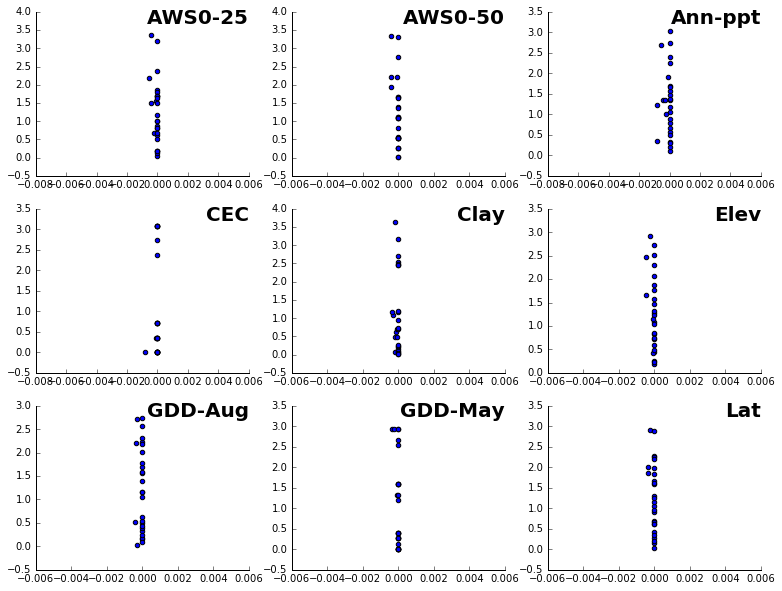

In [1212]:
#with PdfPages('/home/lindb/wbp/figures/neg_dij_v_envdist_sameenv_AWSO-Lat.pdf') as pdf:
plt.close('all')
fig, ((a1,a2,a3),(a4,a5,a6),(a7,a8,a9)) = plt.subplots(3, 3, figsize=(5,5),dpi=400)

a1 = plt.subplot(331)
a1.scatter(neglst['AWS0-25'],distlst['AWS0-25'])
a1.set_title('AWS0-25',y=.9,loc='right',fontsize=20,fontweight='bold')
a1.spines['right'].set_visible(False)
a1.spines['top'].set_visible(False)
a1.yaxis.set_ticks_position('left')
a1.xaxis.set_ticks_position('bottom')

a2 = plt.subplot(332)
a2.scatter(neglst['AWS0-50'],distlst['AWS0-50'])
a2.set_title('AWS0-50',y=.9,loc='right',fontsize=20,fontweight='bold')
a2.spines['right'].set_visible(False)
a2.spines['top'].set_visible(False)
a2.yaxis.set_ticks_position('left')
a2.xaxis.set_ticks_position('bottom')

a3 = plt.subplot(333)
a3.scatter(neglst['Ann-ppt'],distlst['Ann-ppt'])
a3.set_title('Ann-ppt',y=.9,loc='right',fontsize=20,fontweight='bold')
a3.spines['right'].set_visible(False)
a3.spines['top'].set_visible(False)
a3.yaxis.set_ticks_position('left')
a3.xaxis.set_ticks_position('bottom')

a4 = plt.subplot(334)
a4.scatter(neglst['CEC'],distlst['CEC'])
a4.set_title('CEC',y=.9,loc='right',fontsize=20,fontweight='bold')
a4.spines['right'].set_visible(False)
a4.spines['top'].set_visible(False)
a4.yaxis.set_ticks_position('left')
a4.xaxis.set_ticks_position('bottom')

a5 = plt.subplot(335)
a5.scatter(neglst['Clay'],distlst['Clay'])
a5.set_title('Clay',y=.9,loc='right',fontsize=20,fontweight='bold')
a5.spines['right'].set_visible(False)
a5.spines['top'].set_visible(False)
a5.yaxis.set_ticks_position('left')
a5.xaxis.set_ticks_position('bottom')

a6 = plt.subplot(336)
a6.scatter(neglst['Elev'],distlst['Elev'])
a6.set_title('Elev',y=.9,loc='right',fontsize=20,fontweight='bold')
a6.spines['right'].set_visible(False)
a6.spines['top'].set_visible(False)
a6.yaxis.set_ticks_position('left')
a6.xaxis.set_ticks_position('bottom')

a7 = plt.subplot(337)
a7.scatter(neglst['GDD-Aug'],distlst['GDD-Aug'])
a7.set_title('GDD-Aug',y=.9,loc='right',fontsize=20,fontweight='bold')
a7.spines['right'].set_visible(False)
a7.spines['top'].set_visible(False)
a7.yaxis.set_ticks_position('left')
a7.xaxis.set_ticks_position('bottom')

a8 = plt.subplot(338)
a8.scatter(neglst['GDD-May'],distlst['GDD-May'])
a8.set_title('GDD-May',y=.9,loc='right',fontsize=20,fontweight='bold')
a8.spines['right'].set_visible(False)
a8.spines['top'].set_visible(False)
a8.yaxis.set_ticks_position('left')
a8.xaxis.set_ticks_position('bottom')

a9 = plt.subplot(339)
a9.scatter(neglst['Lat'],distlst['Lat'])
a9.set_title('Lat',y=.9,loc='right',fontsize=20,fontweight='bold')
a9.spines['right'].set_visible(False)
a9.spines['top'].set_visible(False)
a9.yaxis.set_ticks_position('left')
a9.xaxis.set_ticks_position('bottom')

fig.set_size_inches(13,10)
#pdf.savefig(fig,bbox_inches='tight')

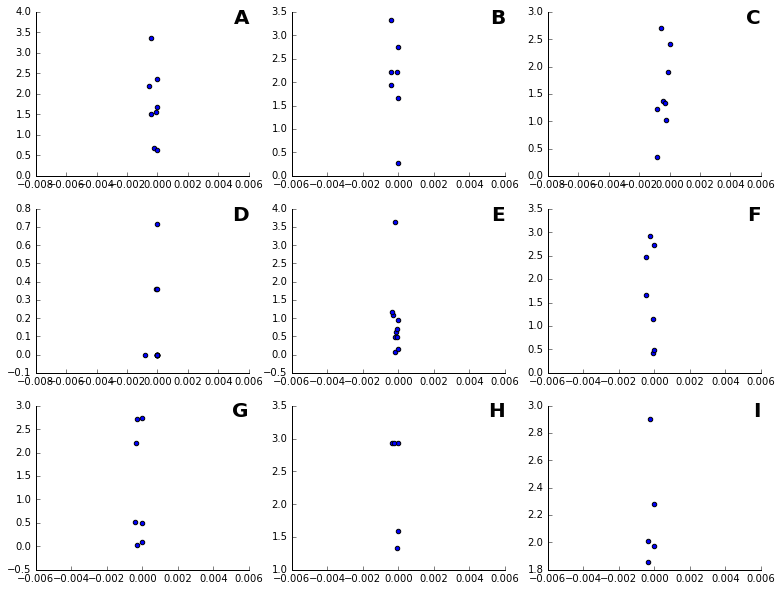

In [1211]:
#with PdfPages('/home/lindb/wbp/figures/log_neg_dij_v_envdist_sameenv_nozeros_AWSO-Lat.pdf') as pdf:
plt.close('all')
fig, ((a1,a2,a3),(a4,a5,a6),(a7,a8,a9)) = plt.subplots(3, 3, figsize=(5,5),dpi=400)

a1 = plt.subplot(331)
a1.scatter([x for x in neglst['AWS0-25'] if x != 0],[x for i,x in enumerate(distlst['AWS0-25']) if neglst['AWS0-25'][i] != 0])
a1.set_title('A',y=.9,loc='right',fontsize=20,fontweight='bold')
a1.spines['right'].set_visible(False)
a1.spines['top'].set_visible(False)
a1.yaxis.set_ticks_position('left')
a1.xaxis.set_ticks_position('bottom')

a2 = plt.subplot(332)
a2.scatter([x for x in neglst['AWS0-50'] if x != 0],[x for i,x in enumerate(distlst['AWS0-50']) if neglst['AWS0-50'][i] != 0])
a2.set_title('B',y=.9,loc='right',fontsize=20,fontweight='bold')
a2.spines['right'].set_visible(False)
a2.spines['top'].set_visible(False)
a2.yaxis.set_ticks_position('left')
a2.xaxis.set_ticks_position('bottom')

a3 = plt.subplot(333)
a3.scatter([x for x in neglst['Ann-ppt'] if x != 0],[x for i,x in enumerate(distlst['Ann-ppt']) if neglst['Ann-ppt'][i] != 0])
a3.set_title('C',y=.9,loc='right',fontsize=20,fontweight='bold')
a3.spines['right'].set_visible(False)
a3.spines['top'].set_visible(False)
a3.yaxis.set_ticks_position('left')
a3.xaxis.set_ticks_position('bottom')

a4 = plt.subplot(334)
a4.scatter([x for x in neglst['CEC'] if x != 0],[x for i,x in enumerate(distlst['CEC']) if neglst['CEC'][i] != 0])
a4.set_title('D',y=.9,loc='right',fontsize=20,fontweight='bold')
a4.spines['right'].set_visible(False)
a4.spines['top'].set_visible(False)
a4.yaxis.set_ticks_position('left')
a4.xaxis.set_ticks_position('bottom')

a5 = plt.subplot(335)
a5.scatter([x for x in neglst['Clay'] if x != 0],[x for i,x in enumerate(distlst['Clay']) if neglst['Clay'][i] != 0])
a5.set_title('E',y=.9,loc='right',fontsize=20,fontweight='bold')
a5.spines['right'].set_visible(False)
a5.spines['top'].set_visible(False)
a5.yaxis.set_ticks_position('left')
a5.xaxis.set_ticks_position('bottom')

a6 = plt.subplot(336)
a6.scatter([x for x in neglst['Elev'] if x != 0],[x for i,x in enumerate(distlst['Elev']) if neglst['Elev'][i] != 0])
a6.set_title('F',y=.9,loc='right',fontsize=20,fontweight='bold')
a6.spines['right'].set_visible(False)
a6.spines['top'].set_visible(False)
a6.yaxis.set_ticks_position('left')
a6.xaxis.set_ticks_position('bottom')

a7 = plt.subplot(337)
a7.scatter([x for x in neglst['GDD-Aug'] if x != 0],[x for i,x in enumerate(distlst['GDD-Aug']) if neglst['GDD-Aug'][i] != 0])
a7.set_title('G',y=.9,loc='right',fontsize=20,fontweight='bold')
a7.spines['right'].set_visible(False)
a7.spines['top'].set_visible(False)
a7.yaxis.set_ticks_position('left')
a7.xaxis.set_ticks_position('bottom')

a8 = plt.subplot(338)
a8.scatter([x for x in neglst['GDD-May'] if x != 0],[x for i,x in enumerate(distlst['GDD-May']) if neglst['GDD-May'][i] != 0])
a8.set_title('H',y=.9,loc='right',fontsize=20,fontweight='bold')
a8.spines['right'].set_visible(False)
a8.spines['top'].set_visible(False)
a8.yaxis.set_ticks_position('left')
a8.xaxis.set_ticks_position('bottom')

a9 = plt.subplot(339)
a9.scatter([x for x in neglst['Lat'] if x != 0],[x for i,x in enumerate(distlst['Lat']) if neglst['Lat'][i] != 0])
a9.set_title('I',y=.9,loc='right',fontsize=20,fontweight='bold')
a9.spines['right'].set_visible(False)
a9.spines['top'].set_visible(False)
a9.yaxis.set_ticks_position('left')
a9.xaxis.set_ticks_position('bottom')

fig.set_size_inches(13,10)
#pdf.savefig(fig,bbox_inches='tight')

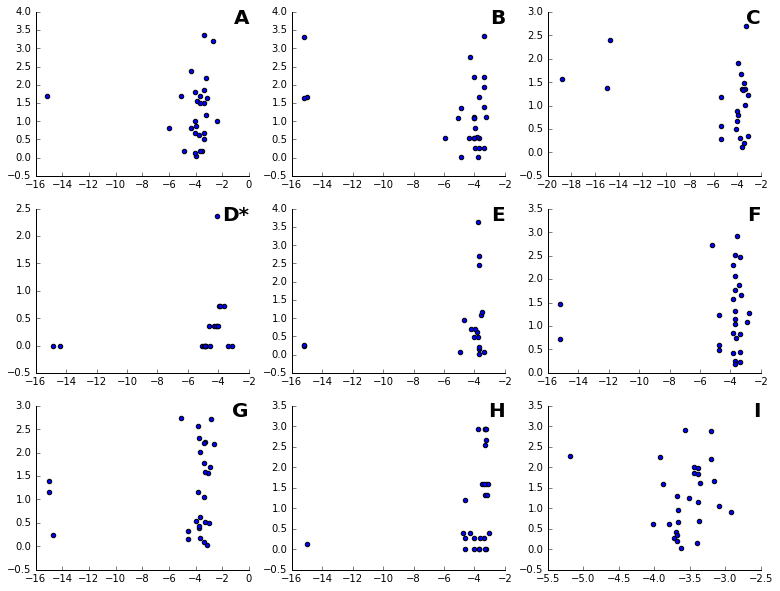

In [1032]:
with PdfPages('/home/lindb/wbp/figures/log_neg_dij_v_envdist_sameenv_nozeros_AWSO-Lat.pdf') as pdf:
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6),(a7,a8,a9)) = plt.subplots(3, 3, figsize=(5,5),dpi=400)

    a1 = plt.subplot(331)
    a1.scatter([math.log(-1*x,10) for x in neglst['AWS0-25'] if x != 0],[x for i,x in enumerate(distlst['AWS0-25']) if neglst['AWS0-25'][i] != 0])
    a1.set_title('A',y=.9,loc='right',fontsize=20,fontweight='bold')
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    
    a2 = plt.subplot(332)
    a2.scatter([math.log(-1*x,10) for x in neglst['AWS0-50'] if x != 0],[x for i,x in enumerate(distlst['AWS0-50']) if neglst['AWS0-50'][i] != 0])
    a2.set_title('B',y=.9,loc='right',fontsize=20,fontweight='bold')
    a2.spines['right'].set_visible(False)
    a2.spines['top'].set_visible(False)
    a2.yaxis.set_ticks_position('left')
    a2.xaxis.set_ticks_position('bottom')
    
    a3 = plt.subplot(333)
    a3.scatter([math.log(-1*x,10) for x in neglst['Ann-ppt'] if x != 0],[x for i,x in enumerate(distlst['Ann-ppt']) if neglst['Ann-ppt'][i] != 0])
    a3.set_title('C',y=.9,loc='right',fontsize=20,fontweight='bold')
    a3.spines['right'].set_visible(False)
    a3.spines['top'].set_visible(False)
    a3.yaxis.set_ticks_position('left')
    a3.xaxis.set_ticks_position('bottom')
    
    a4 = plt.subplot(334)
    a4.scatter([math.log(-1*x,10) for x in neglst['CEC'] if x != 0],[x for i,x in enumerate(distlst['CEC']) if neglst['CEC'][i] != 0])
    a4.set_title('D*',y=.9,loc='right',fontsize=20,fontweight='bold')
    a4.spines['right'].set_visible(False)
    a4.spines['top'].set_visible(False)
    a4.yaxis.set_ticks_position('left')
    a4.xaxis.set_ticks_position('bottom')
    
    a5 = plt.subplot(335)
    a5.scatter([math.log(-1*x,10) for x in neglst['Clay'] if x != 0],[x for i,x in enumerate(distlst['Clay']) if neglst['Clay'][i] != 0])
    a5.set_title('E',y=.9,loc='right',fontsize=20,fontweight='bold')
    a5.spines['right'].set_visible(False)
    a5.spines['top'].set_visible(False)
    a5.yaxis.set_ticks_position('left')
    a5.xaxis.set_ticks_position('bottom')
    
    a6 = plt.subplot(336)
    a6.scatter([math.log(-1*x,10) for x in neglst['Elev'] if x != 0],[x for i,x in enumerate(distlst['Elev']) if neglst['Elev'][i] != 0])
    a6.set_title('F',y=.9,loc='right',fontsize=20,fontweight='bold')
    a6.spines['right'].set_visible(False)
    a6.spines['top'].set_visible(False)
    a6.yaxis.set_ticks_position('left')
    a6.xaxis.set_ticks_position('bottom')
    
    a7 = plt.subplot(337)
    a7.scatter([math.log(-1*x,10) for x in neglst['GDD-Aug'] if x != 0],[x for i,x in enumerate(distlst['GDD-Aug']) if neglst['GDD-Aug'][i] != 0])
    a7.set_title('G',y=.9,loc='right',fontsize=20,fontweight='bold')
    a7.spines['right'].set_visible(False)
    a7.spines['top'].set_visible(False)
    a7.yaxis.set_ticks_position('left')
    a7.xaxis.set_ticks_position('bottom')
    
    a8 = plt.subplot(338)
    a8.scatter([math.log(-1*x,10) for x in neglst['GDD-May'] if x != 0],[x for i,x in enumerate(distlst['GDD-May']) if neglst['GDD-May'][i] != 0])
    a8.set_title('H',y=.9,loc='right',fontsize=20,fontweight='bold')
    a8.spines['right'].set_visible(False)
    a8.spines['top'].set_visible(False)
    a8.yaxis.set_ticks_position('left')
    a8.xaxis.set_ticks_position('bottom')
    
    a9 = plt.subplot(339)
    a9.scatter([math.log(-1*x,10) for x in neglst['Lat'] if x != 0],[x for i,x in enumerate(distlst['Lat']) if neglst['Lat'][i] != 0])
    a9.set_title('I',y=.9,loc='right',fontsize=20,fontweight='bold')
    a9.spines['right'].set_visible(False)
    a9.spines['top'].set_visible(False)
    a9.yaxis.set_ticks_position('left')
    a9.xaxis.set_ticks_position('bottom')
    
    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

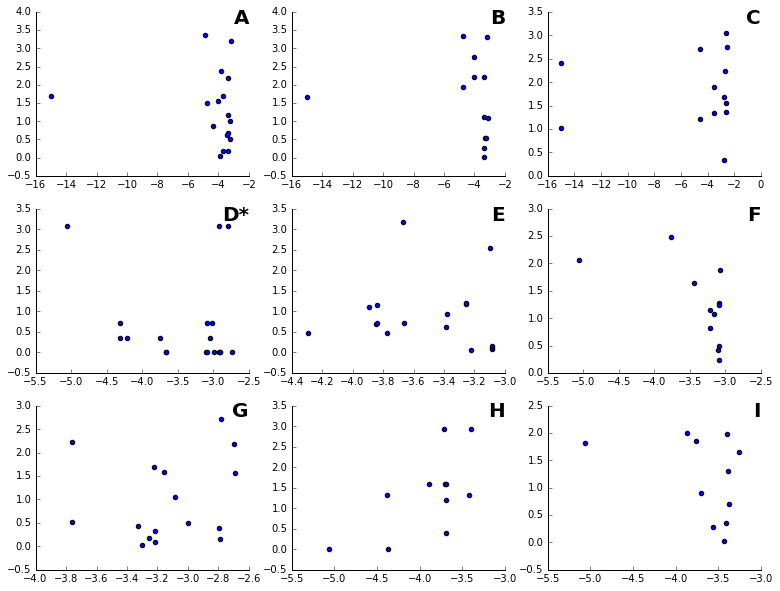

In [1038]:
with PdfPages('/home/lindb/wbp/figures/log_pos_dij_v_envdist_sameenv_nozeros_AWSO-Lat.pdf') as pdf:
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6),(a7,a8,a9)) = plt.subplots(3, 3, figsize=(5,5),dpi=400)

    a1 = plt.subplot(331)
    a1.scatter([math.log(x,10) for x in poslst['AWS0-25'] if x != 0],[x for i,x in enumerate(distlst['AWS0-25']) if poslst['AWS0-25'][i] != 0])
    a1.set_title('A',y=.9,loc='right',fontsize=20,fontweight='bold')
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    
    a2 = plt.subplot(332)
    a2.scatter([math.log(x,10) for x in poslst['AWS0-50'] if x != 0],[x for i,x in enumerate(distlst['AWS0-50']) if poslst['AWS0-50'][i] != 0])
    a2.set_title('B',y=.9,loc='right',fontsize=20,fontweight='bold')
    a2.spines['right'].set_visible(False)
    a2.spines['top'].set_visible(False)
    a2.yaxis.set_ticks_position('left')
    a2.xaxis.set_ticks_position('bottom')
    
    a3 = plt.subplot(333)
    a3.scatter([math.log(x,10) for x in poslst['Ann-ppt'] if x != 0],[x for i,x in enumerate(distlst['Ann-ppt']) if poslst['Ann-ppt'][i] != 0])
    a3.set_title('C',y=.9,loc='right',fontsize=20,fontweight='bold')
    a3.spines['right'].set_visible(False)
    a3.spines['top'].set_visible(False)
    a3.yaxis.set_ticks_position('left')
    a3.xaxis.set_ticks_position('bottom')
    
    a4 = plt.subplot(334)
    a4.scatter([math.log(x,10) for x in poslst['CEC'] if x != 0],[x for i,x in enumerate(distlst['CEC']) if poslst['CEC'][i] != 0])
    a4.set_title('D*',y=.9,loc='right',fontsize=20,fontweight='bold')
    a4.spines['right'].set_visible(False)
    a4.spines['top'].set_visible(False)
    a4.yaxis.set_ticks_position('left')
    a4.xaxis.set_ticks_position('bottom')
    
    a5 = plt.subplot(335)
    a5.scatter([math.log(x,10) for x in poslst['Clay'] if x != 0],[x for i,x in enumerate(distlst['Clay']) if poslst['Clay'][i] != 0])
    a5.set_title('E',y=.9,loc='right',fontsize=20,fontweight='bold')
    a5.spines['right'].set_visible(False)
    a5.spines['top'].set_visible(False)
    a5.yaxis.set_ticks_position('left')
    a5.xaxis.set_ticks_position('bottom')
    
    a6 = plt.subplot(336)
    a6.scatter([math.log(x,10) for x in poslst['Elev'] if x != 0],[x for i,x in enumerate(distlst['Elev']) if poslst['Elev'][i] != 0])
    a6.set_title('F',y=.9,loc='right',fontsize=20,fontweight='bold')
    a6.spines['right'].set_visible(False)
    a6.spines['top'].set_visible(False)
    a6.yaxis.set_ticks_position('left')
    a6.xaxis.set_ticks_position('bottom')
    
    a7 = plt.subplot(337)
    a7.scatter([math.log(x,10) for x in poslst['GDD-Aug'] if x != 0],[x for i,x in enumerate(distlst['GDD-Aug']) if poslst['GDD-Aug'][i] != 0])
    a7.set_title('G',y=.9,loc='right',fontsize=20,fontweight='bold')
    a7.spines['right'].set_visible(False)
    a7.spines['top'].set_visible(False)
    a7.yaxis.set_ticks_position('left')
    a7.xaxis.set_ticks_position('bottom')
    
    a8 = plt.subplot(338)
    a8.scatter([math.log(x,10) for x in poslst['GDD-May'] if x != 0],[x for i,x in enumerate(distlst['GDD-May']) if poslst['GDD-May'][i] != 0])
    a8.set_title('H',y=.9,loc='right',fontsize=20,fontweight='bold')
    a8.spines['right'].set_visible(False)
    a8.spines['top'].set_visible(False)
    a8.yaxis.set_ticks_position('left')
    a8.xaxis.set_ticks_position('bottom')
    
    a9 = plt.subplot(339)
    a9.scatter([math.log(x,10) for x in poslst['Lat'] if x != 0],[x for i,x in enumerate(distlst['Lat']) if poslst['Lat'][i] != 0])
    a9.set_title('I',y=.9,loc='right',fontsize=20,fontweight='bold')
    a9.spines['right'].set_visible(False)
    a9.spines['top'].set_visible(False)
    a9.yaxis.set_ticks_position('left')
    a9.xaxis.set_ticks_position('bottom')
    
    fig.set_size_inches(13,10)
    pdf.savefig(fig,bbox_inches='tight')

In [1050]:
for env in poslst.keys():
    spear = spearmanr([math.log(x,10) for x in poslst[env] if x != 0],[x for i,x in enumerate(distlst[env]) if poslst[env][i] != 0])
    if spear[1] <= 0.05:
        print env,spear

# effect size distributions

In [1449]:
#file made in 07_hierfstat.ipynb
filE = '/home/lindb/wbp/hierfstat/imputed/imputed_hierarchical_Fstats.txt'
df = pd.read_csv(filE,header=0,index_col=0,sep='\t')
df.head()

,pop_total,plot_total,plot_pop,perc data
NODE_1000013_length_91_cov_1.802198_37,-0.002797,-0.018565,-0.015723,1
NODE_1000031_length_98_cov_2.000000_30,0.014700,0.007232,-0.007579,1
NODE_1000037_length_93_cov_2.043011_33,-0.008883,-0.011011,-0.002109,1
NODE_1000042_length_93_cov_1.118280_100,-0.008273,0.018138,0.026194,1
NODE_1000053_length_94_cov_1.744681_25,-0.020574,0.024885,0.044543,1


In [1451]:
#get bayenv2 snps
DIR = '/home/lindb/wbp/bayenv2/results/sigsnps'
bayfs = [op.join(DIR,f) for f in ls(DIR)]
baydict = {}
for f in bayfs:
    env = op.basename(f).split("_")[0]
    df = pd.read_csv(f,header=0,sep='\t')
    baydict[env] = df[env].tolist()
    print env,len(baydict[env])

AWS0-25 95
AWS0-50 147
Ann-ppt 49
CEC 14
Clay 22
Elev 143
GDD-Aug 157
GDD-May 80
Lat 119
Lon 67
Max-rad-input 144
Rock-cov 143
Sand 111
Silt 140
Tmax-July 50
Tmin-Jan 116
WC15Bar 86
WC3rdbar 97


In [ ]:
for env in baydict:
    with PdfPages('/home/lindb/wbp/figures/multilocus_fst_distribution_bayenv_%s_overlay.pdf' % env) as pdf:
        plt.close('all')
        fig  = plt.figure(figsize=(5,5),dpi=400)
        a1 = plt.subplot(111)
        a1.hist(df['plot_total'],bins = [x for x in np.linspace(-0.1,0.2,30)])
        a1.spines['right'].set_visible(False)
        a1.spines['top'].set_visible(False)
        a1.yaxis.set_ticks_position('left')
        a1.xaxis.set_ticks_position('bottom')
        a1.set_xlabel(r'multilocus $F_{ST}$',fontsize=14)
        a1.set_ylabel('Count',fontsize=14)

        #[a1.axvline(x=dd[snp],c='red',linewidth=0.25,zorder=1) for snp in dd.keys()]
        #a1.axvline(x=dd[dd.keys()[0]],c='red',linewidth=0.25,zorder=1)

        fig.set_size_inches(4,4)
        pdf.savefig(fig,bbox_inches='tight')

In [1480]:
envdf

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
AWS0-25,-0.203570,-0.389380,-1.384005,0.474087,0.430367,0.299207,1.982420,-1.209126
AWS0-50,-0.035349,-0.578405,-1.156498,0.239933,-0.030344,0.510211,2.176919,-1.126467
Ann-ppt,1.621491,-0.620322,-1.416888,0.058608,-0.059028,0.260270,-1.124478,1.280346
CEC,-0.519958,-0.162005,-0.519958,2.565848,0.195949,-0.519958,-0.519958,-0.519958
Clay,-0.111761,-0.739189,-0.049018,2.429323,-1.209760,-0.033332,-0.017646,-0.268618
Elev,-0.003848,1.073662,0.821217,1.270692,-1.653978,0.223968,-1.235288,-0.496424
GDD-Aug,0.934437,-1.786280,0.442116,-1.242137,0.960348,-0.620259,0.778967,0.532807
GDD-May,-0.649369,-0.649369,0.949078,-0.649369,2.281117,-0.649369,-0.249757,-0.382961
Lat,-0.576210,-0.851775,-0.428441,-1.473446,1.431077,1.398217,0.729649,-0.229072
Lon,-1.511918,0.796321,0.849157,-0.682730,0.861823,0.054377,1.057400,-1.424429


In [1453]:
from scipy.stats import spearmanr

In [1481]:
from scipy.stats import pearsonr

In [1477]:
for i,envi in enumerate(envdf.index):
    for j,envj in enumerate(envdf.index):
        if i > j:
            corr,p = spearmanr(envdf.loc[envi,:],envdf.loc[envj,:])
            if p <= 0.05:
                print envi,envj,corr,p

AWS0-50 AWS0-25 0.928571428571 0.0008629681829
GDD-Aug Elev -0.880952380952 0.00385032046373
Lat Elev -0.809523809524 0.0149026676862
Lon Ann-ppt -0.857142857143 0.00653001725472
Rock-cov CEC -0.845594324664 0.00817017174491
Sand Clay -0.952380952381 0.000260400024387
Silt Clay 0.904761904762 0.00200827550543
Silt Sand -0.97619047619 3.3143960262e-05
Tmax-July Ann-ppt -0.714285714286 0.0465282322842
Tmax-July GDD-May 0.773703091384 0.0242771985772
Tmax-July Lon 0.857142857143 0.00653001725472
WC15Bar AWS0-50 0.809523809524 0.0149026676862
WC3rdbar WC15Bar 0.904761904762 0.00200827550543


In [1482]:
for i,envi in enumerate(envdf.index):
    for j,envj in enumerate(envdf.index):
        if i > j:
            corr,p = pearsonr(envdf.loc[envi,:],envdf.loc[envj,:])
            if p <= 0.05:
                print envi,envj,corr,p

AWS0-50 AWS0-25 0.970496544498 6.27912080084e-05
Clay CEC 0.795718669681 0.0181802491838
GDD-Aug Elev -0.761352104125 0.0281876629783
Lat Elev -0.747233130773 0.0331069228605
Lon Ann-ppt -0.904776799386 0.00200735660366
Sand AWS0-50 -0.746045170558 0.0335431261261
Sand Clay -0.723460160965 0.0425113568057
Silt AWS0-25 0.765431272394 0.0268561799279
Silt AWS0-50 0.876350891283 0.00429875483552
Silt Sand -0.950539759039 0.000291378513587
Tmax-July Ann-ppt -0.709227788845 0.0488369989052
Tmax-July Lon 0.761089052489 0.0282748925209
Tmin-Jan GDD-Aug 0.763060083612 0.0276253220998
WC15Bar AWS0-25 0.841958960167 0.00873572158335
WC15Bar AWS0-50 0.929337053419 0.000836006869256
WC15Bar Silt 0.812688872199 0.0142081036693
WC3rdbar AWS0-25 0.797149654076 0.0178214350215
WC3rdbar AWS0-50 0.875640754168 0.00437081259034
WC3rdbar Silt 0.718414059681 0.0446935634717
WC3rdbar WC15Bar 0.974442998137 4.0936229427e-05


In [1479]:
spearmanr(envdf.loc['Ann-ppt',:],envdf.loc['Elev',:])

SpearmanrResult(correlation=-0.095238095238095233, pvalue=0.82250543020361144)

In [1475]:
p

0.0020082755054294677

In [1476]:
corr

0.90476190476190477

# see if correlations are driven by larger exp het

In [2]:
#file made in 09_OutFLANK.ipynb
globmafs = pd.read_csv('/home/lindb/wbp/OutFLANK/global_mafs.txt',header=0,sep='\t')
globmafs.head()

,locus,maf
0,NODE_1000013_length_91_cov_1.802198_37,0.120902
1,NODE_1000031_length_98_cov_2.000000_30,0.151639
2,NODE_1000037_length_93_cov_2.043011_33,0.122951
3,NODE_1000042_length_93_cov_1.118280_100,0.040984
4,NODE_1000053_length_94_cov_1.744681_25,0.024590


In [7]:
popmafs = pd.read_csv('/home/lindb/wbp/OutFLANK/imputed_MAF.txt',header=0,index_col=0,sep='\t')
popmafs.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
NODE_1000013_length_91_cov_1.802198_37,0.14,0.052083,0.14,0.16,0.112245,0.1250,0.145833,0.166667
NODE_1000031_length_98_cov_2.000000_30,0.26,0.104167,0.18,0.20,0.081633,0.1250,0.145833,0.229167
NODE_1000037_length_93_cov_2.043011_33,0.08,0.114583,0.14,0.16,0.102041,0.1250,0.166667,0.125000
NODE_1000042_length_93_cov_1.118280_100,0.06,0.020833,0.08,0.02,0.051020,0.0000,0.041667,0.062500
NODE_1000053_length_94_cov_1.744681_25,0.02,0.020833,0.04,0.02,0.010204,0.0625,0.020833,0.020833


In [21]:
popmafs.loc['NODE_1000013_length_91_cov_1.802198_37',:].tolist()

[0.14000000000000001,
 0.052083333333300008,
 0.14000000000000001,
 0.16,
 0.112244897959,
 0.125,
 0.145833333333,
 0.166666666667]

In [5]:
envdf = pd.read_csv('/home/lindb/wbp/bayenv2/ENVIRONFILE_headerIDX.txt',header=0,index_col=0,sep='\t')
envdf.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
AWS0-25,-0.203570,-0.389380,-1.384005,0.474087,0.430367,0.299207,1.982420,-1.209126
AWS0-50,-0.035349,-0.578405,-1.156498,0.239933,-0.030344,0.510211,2.176919,-1.126467
Ann-ppt,1.621491,-0.620322,-1.416888,0.058608,-0.059028,0.260270,-1.124478,1.280346
CEC,-0.519958,-0.162005,-0.519958,2.565848,0.195949,-0.519958,-0.519958,-0.519958
Clay,-0.111761,-0.739189,-0.049018,2.429323,-1.209760,-0.033332,-0.017646,-0.268618


In [34]:
from scipy.stats import spearmanr

In [33]:
#get env correlations for each snp
#rows = snps, cols = envs
snpDict = OrderedDict()
snpcount = 0
for snp in popmafs.index:
    snpDict[snp] = OrderedDict()
    freqs = popmafs.loc[snp,:].tolist()
    for env in envdf.index:
        envval = envdf.loc[env,:].tolist()
        s = spearmanr(freqs,envval)
        snpDict[snp][env] = s[0]
    snpcount += 1
    if snpcount % 1000 == 0:
        print snpcount

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000


In [41]:
#write out the file
key0 = snpDict.keys()[0]
filE = '/home/lindb/wbp/bayenv2/uncorrected_correlations.txt'
with open(filE,'w') as o:
    text = '\t'.join(snpDict[key0].keys())+'\n'
    o.write("%s" % text)
    for snp in snpDict:
        text = snp+'\t'+'\t'.join([str(x) for x in snpDict[snp].values()])+'\n'
        o.write("%s" % text)

In [42]:
corr = pd.read_csv(filE,header=0,index_col=0,sep='\t')
corr.head()

,AWS0-25,AWS0-50,Ann-ppt,CEC,Clay,Elev,GDD-Aug,GDD-May,Lat,Lon,Max-rad-input,Rock-cov,Sand,Silt,Tmax-July,Tmin-Jan,WC15Bar,WC3rdbar
NODE_1000013_length_91_cov_1.802198_37,0.083834,0.011976,0.251502,-0.219529,0.538932,-0.023953,0.083834,0.006380,-0.203596,-0.347312,-0.538932,0.443122,-0.514979,0.419169,-0.047905,0.204819,-0.335335,-0.371264
NODE_1000031_length_98_cov_2.000000_30,-0.238095,-0.261905,0.523810,-0.381881,0.357143,0.166667,0.095238,-0.317091,-0.476190,-0.738095,-0.285714,0.642857,-0.380952,0.309524,-0.476190,0.455098,-0.309524,-0.428571
NODE_1000037_length_93_cov_2.043011_33,0.323359,0.323359,-0.514979,-0.054882,0.778457,0.215573,-0.335335,0.133978,-0.095810,0.383240,-0.574861,-0.071858,-0.682647,0.622766,0.491027,-0.524096,-0.023953,0.047905
NODE_1000042_length_93_cov_1.118280_100,-0.619048,-0.738095,-0.095238,-0.409159,-0.380952,-0.333333,0.500000,0.583448,0.047619,-0.047619,-0.452381,0.285714,0.380952,-0.404762,0.190476,0.455098,-0.500000,-0.261905
NODE_1000053_length_94_cov_1.744681_25,-0.405099,-0.098206,-0.257790,-0.632862,0.294617,0.270066,-0.478753,-0.130789,0.122757,0.098206,-0.184136,0.429650,-0.245514,0.380547,0.380547,-0.111145,0.012276,0.135033


In [44]:
#get number of bayenv sig SNPs
DIR = '/home/lindb/wbp/bayenv2/results/sigsnps'
bayDict = {}
for f in [op.join(DIR,f) for f in ls(DIR)]:
    env = op.basename(f).split("_")[0]
    df = pd.read_csv(f,header=0,sep='\t')
    bayDict[env] = len(df.index)
    print env,len(df.index)

AWS0-25 95
AWS0-50 147
Ann-ppt 49
CEC 14
Clay 22
Elev 143
GDD-Aug 157
GDD-May 80
Lat 119
Lon 67
Max-rad-input 144
Rock-cov 143
Sand 111
Silt 140
Tmax-July 50
Tmin-Jan 116
WC15Bar 86
WC3rdbar 97


In [47]:
#get absolute rhos
abscorr = pd.DataFrame(abs(corr))
abscorr.head()

,AWS0-25,AWS0-50,Ann-ppt,CEC,Clay,Elev,GDD-Aug,GDD-May,Lat,Lon,Max-rad-input,Rock-cov,Sand,Silt,Tmax-July,Tmin-Jan,WC15Bar,WC3rdbar
NODE_1000013_length_91_cov_1.802198_37,0.083834,0.011976,0.251502,0.219529,0.538932,0.023953,0.083834,0.006380,0.203596,0.347312,0.538932,0.443122,0.514979,0.419169,0.047905,0.204819,0.335335,0.371264
NODE_1000031_length_98_cov_2.000000_30,0.238095,0.261905,0.523810,0.381881,0.357143,0.166667,0.095238,0.317091,0.476190,0.738095,0.285714,0.642857,0.380952,0.309524,0.476190,0.455098,0.309524,0.428571
NODE_1000037_length_93_cov_2.043011_33,0.323359,0.323359,0.514979,0.054882,0.778457,0.215573,0.335335,0.133978,0.095810,0.383240,0.574861,0.071858,0.682647,0.622766,0.491027,0.524096,0.023953,0.047905
NODE_1000042_length_93_cov_1.118280_100,0.619048,0.738095,0.095238,0.409159,0.380952,0.333333,0.500000,0.583448,0.047619,0.047619,0.452381,0.285714,0.380952,0.404762,0.190476,0.455098,0.500000,0.261905
NODE_1000053_length_94_cov_1.744681_25,0.405099,0.098206,0.257790,0.632862,0.294617,0.270066,0.478753,0.130789,0.122757,0.098206,0.184136,0.429650,0.245514,0.380547,0.380547,0.111145,0.012276,0.135033


In [53]:
abscorr.sort_values(by='AWS0-25',inplace=True,ascending=0)
abscorr.head()

,AWS0-25,AWS0-50,Ann-ppt,CEC,Clay,Elev,GDD-Aug,GDD-May,Lat,Lon,Max-rad-input,Rock-cov,Sand,Silt,Tmax-July,Tmin-Jan,WC15Bar,WC3rdbar
NODE_768610_length_47_cov_4.042553_36,1.0,0.928571,0.02381,0.381881,0.452381,0.238095,0.190476,0.038051,0.190476,0.333333,0.142857,0.357143,0.547619,0.5,0.119048,0.251502,0.666667,0.52381
NODE_2087411_length_96_cov_1.000000_57,1.0,0.928571,0.02381,0.381881,0.452381,0.238095,0.190476,0.038051,0.190476,0.333333,0.142857,0.357143,0.547619,0.5,0.119048,0.251502,0.666667,0.52381
NODE_1987815_length_98_cov_2.000000_29,1.0,0.928571,0.02381,0.381881,0.452381,0.238095,0.190476,0.038051,0.190476,0.333333,0.142857,0.357143,0.547619,0.5,0.119048,0.251502,0.666667,0.52381
NODE_194688_length_98_cov_1.040816_77,1.0,0.928571,0.02381,0.381881,0.452381,0.238095,0.190476,0.038051,0.190476,0.333333,0.142857,0.357143,0.547619,0.5,0.119048,0.251502,0.666667,0.52381
NODE_1037484_length_94_cov_2.904255_18,1.0,0.928571,0.02381,0.381881,0.452381,0.238095,0.190476,0.038051,0.190476,0.333333,0.142857,0.357143,0.547619,0.5,0.119048,0.251502,0.666667,0.52381


In [57]:
abscorr.loc[abscorr.index[0:100],:]

,AWS0-25,AWS0-50,Ann-ppt,CEC,Clay,Elev,GDD-Aug,GDD-May,Lat,Lon,Max-rad-input,Rock-cov,Sand,Silt,Tmax-July,Tmin-Jan,WC15Bar,WC3rdbar
NODE_768610_length_47_cov_4.042553_36,1.000000,0.928571,0.023810,0.381881,0.452381,0.238095,0.190476,0.038051,0.190476,0.333333,0.142857,0.357143,0.547619,0.500000,0.119048,0.251502,0.666667,0.523810
NODE_2087411_length_96_cov_1.000000_57,1.000000,0.928571,0.023810,0.381881,0.452381,0.238095,0.190476,0.038051,0.190476,0.333333,0.142857,0.357143,0.547619,0.500000,0.119048,0.251502,0.666667,0.523810
NODE_1987815_length_98_cov_2.000000_29,1.000000,0.928571,0.023810,0.381881,0.452381,0.238095,0.190476,0.038051,0.190476,0.333333,0.142857,0.357143,0.547619,0.500000,0.119048,0.251502,0.666667,0.523810
NODE_194688_length_98_cov_1.040816_77,1.000000,0.928571,0.023810,0.381881,0.452381,0.238095,0.190476,0.038051,0.190476,0.333333,0.142857,0.357143,0.547619,0.500000,0.119048,0.251502,0.666667,0.523810
NODE_1037484_length_94_cov_2.904255_18,1.000000,0.928571,0.023810,0.381881,0.452381,0.238095,0.190476,0.038051,0.190476,0.333333,0.142857,0.357143,0.547619,0.500000,0.119048,0.251502,0.666667,0.523810
NODE_1598674_length_93_cov_2.086021_21,0.994030,0.922172,0.023953,0.343013,0.467074,0.287430,0.239525,0.006380,0.227549,0.299407,0.119763,0.299407,0.562884,0.514979,0.131739,0.180723,0.634742,0.503003
NODE_1412958_length_101_cov_1.039604_107,0.994030,0.922172,0.023953,0.343013,0.467074,0.287430,0.239525,0.006380,0.227549,0.299407,0.119763,0.299407,0.562884,0.514979,0.131739,0.180723,0.634742,0.503003
NODE_1028771_length_97_cov_1.989691_15,0.994030,0.922172,0.023953,0.343013,0.467074,0.287430,0.239525,0.006380,0.227549,0.299407,0.119763,0.299407,0.562884,0.514979,0.131739,0.180723,0.634742,0.503003
NODE_808419_length_97_cov_1.927835_18,0.994030,0.922172,0.023953,0.343013,0.467074,0.287430,0.239525,0.006380,0.227549,0.299407,0.119763,0.299407,0.562884,0.514979,0.131739,0.180723,0.634742,0.503003
NODE_1460690_length_98_cov_2.000000_81,0.994030,0.922172,0.023953,0.343013,0.467074,0.287430,0.239525,0.006380,0.227549,0.299407,0.119763,0.299407,0.562884,0.514979,0.131739,0.180723,0.634742,0.503003


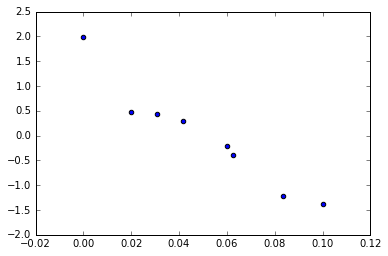

In [55]:
freqs = popmafs.loc['NODE_768610_length_47_cov_4.042553_36',:].tolist()
envval = envdf.loc['AWS0-25',:].tolist()
plt.scatter(freqs,envval)

In [68]:
corrdict = {}
for env in abscorr:
    abscorr.sort_values(by=env,inplace=True,ascending=0)
    corrdict[env] = list(abscorr.index[0:bayDict[env]])
    print len(corrdict[env]),bayDict[env]

95 95
147 147
49 49
14 14
22 22
143 143
157 157
80 80
119 119
67 67
144 144
143 143
111 111
140 140
50 50
116 116
86 86
97 97


In [67]:
#get expected heterozygosities
filE = '/home/lindb/wbp/OutFLANK/Hexp_by_snp_withbins.txt'
H = pd.read_csv(filE,header=0,index_col=0,sep='\t')
H.head()

,locus,h_exp,bin
NODE_1274178_length_97_cov_1.030928_97,NODE_1274178_length_97_cov_1.030928_97,0.020282,1
NODE_694898_length_99_cov_1.676768_19,NODE_694898_length_99_cov_1.676768_19,0.020282,1
NODE_544568_length_93_cov_4.064516_12,NODE_544568_length_93_cov_4.064516_12,0.020282,1
NODE_1278450_length_97_cov_2.000000_111,NODE_1278450_length_97_cov_2.000000_111,0.020282,1
NODE_1913585_length_92_cov_1.750000_37,NODE_1913585_length_92_cov_1.750000_37,0.020282,1


In [75]:
np.unique(H['bin'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [235]:
Habscorr = pd.merge(pd.DataFrame(H['bin']),abscorr,left_index=True,right_index=True)
Habscorr.head()

,bin,AWS0-25,AWS0-50,Ann-ppt,CEC,Clay,Elev,GDD-Aug,GDD-May,Lat,Lon,Max-rad-input,Rock-cov,Sand,Silt,Tmax-July,Tmin-Jan,WC15Bar,WC3rdbar
NODE_1603382_length_94_cov_1.000000_80,47,0.523810,0.666667,0.238095,0.300050,0.166667,0.500000,0.428571,0.240989,0.642857,0.571429,0.238095,0.047619,0.333333,0.452381,0.547619,0.083834,0.904762,1.00000
NODE_1578493_length_97_cov_1.000000_70,31,0.491027,0.634742,0.323359,0.301852,0.179644,0.479051,0.395217,0.299856,0.658694,0.634742,0.203596,0.083834,0.323359,0.443122,0.622766,0.036145,0.862291,0.99403
NODE_409365_length_96_cov_1.083333_16,8,0.491027,0.634742,0.323359,0.301852,0.179644,0.479051,0.395217,0.299856,0.658694,0.634742,0.203596,0.083834,0.323359,0.443122,0.622766,0.036145,0.862291,0.99403
NODE_1486164_length_95_cov_1.726316_38,11,0.491027,0.634742,0.323359,0.301852,0.179644,0.479051,0.395217,0.299856,0.658694,0.634742,0.203596,0.083834,0.323359,0.443122,0.622766,0.036145,0.862291,0.99403
NODE_1093767_length_117_cov_1.008547_119,17,0.491027,0.634742,0.323359,0.301852,0.179644,0.479051,0.395217,0.299856,0.658694,0.634742,0.203596,0.083834,0.323359,0.443122,0.622766,0.036145,0.862291,0.99403


In [240]:
abscorr.sort_values(by='AWS0-25',ascending=1,inplace=True)
abscorr.head()

,AWS0-25,AWS0-50,Ann-ppt,CEC,Clay,Elev,GDD-Aug,GDD-May,Lat,Lon,Max-rad-input,Rock-cov,Sand,Silt,Tmax-July,Tmin-Jan,WC15Bar,WC3rdbar
NODE_950382_length_98_cov_3.244898_16,0.0,0.011976,0.047905,0.178367,0.227549,0.383240,0.215573,0.516773,0.634742,0.179644,0.215573,0.167668,0.347312,0.311383,0.371264,0.240964,0.299407,0.071858
NODE_1068480_length_98_cov_1.112245_21,0.0,0.250313,0.100125,0.573539,0.300376,0.050063,0.300376,0.293359,0.150188,0.050063,0.400501,0.650814,0.400501,0.500626,0.200250,0.025182,0.200250,0.100125
NODE_410380_length_98_cov_2.000000_23,0.0,0.150188,0.100125,0.114708,0.300376,0.150188,0.300376,0.133345,0.250313,0.250313,0.200250,0.150188,0.200250,0.100125,0.200250,0.276998,0.200250,0.100125
NODE_1632351_length_99_cov_1.050505_29,0.0,0.150188,0.100125,0.114708,0.300376,0.150188,0.300376,0.133345,0.250313,0.250313,0.200250,0.150188,0.200250,0.100125,0.200250,0.276998,0.200250,0.100125
NODE_1621360_length_98_cov_2.000000_15,0.0,0.047905,0.610789,0.150926,0.143715,0.335335,0.479051,0.663511,0.371264,0.658694,0.023953,0.347312,0.119763,0.083834,0.598813,0.006024,0.299407,0.598813


AWS0-25


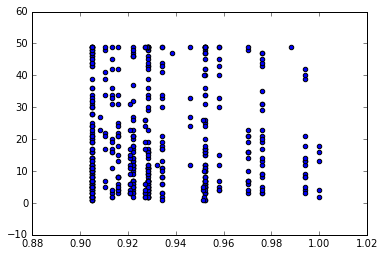

AWS0-50


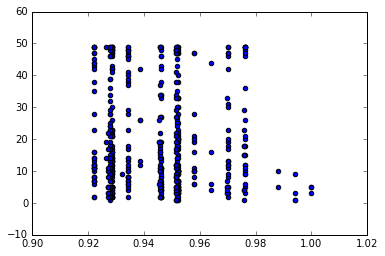

Ann-ppt


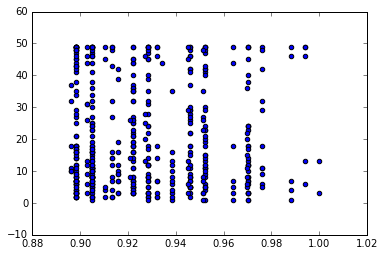

CEC


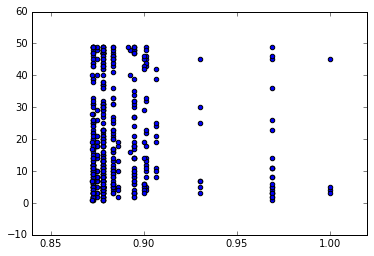

Clay


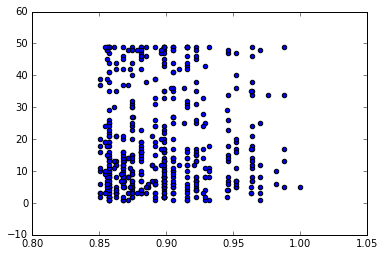

Elev


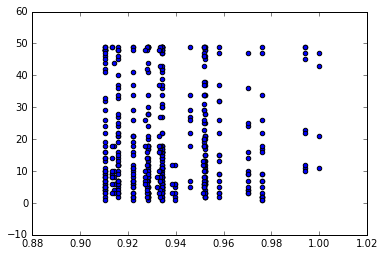

GDD-Aug


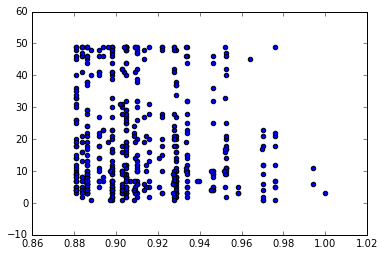

GDD-May


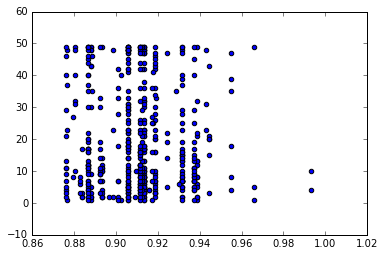

Lat


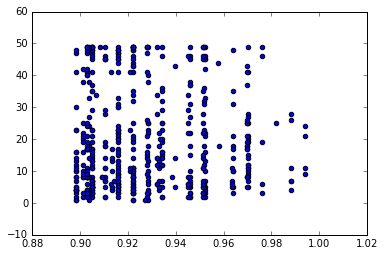

Lon


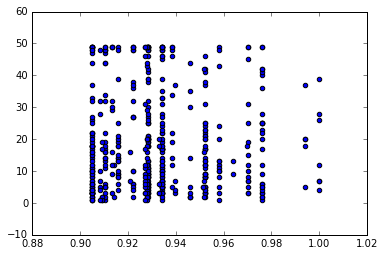

Max-rad-input


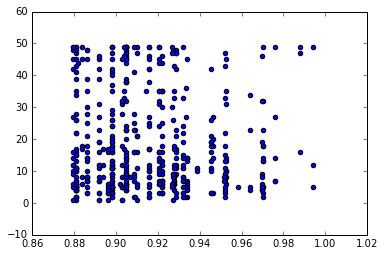

Rock-cov


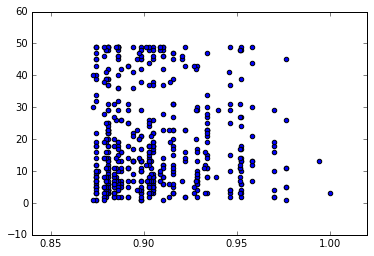

Sand


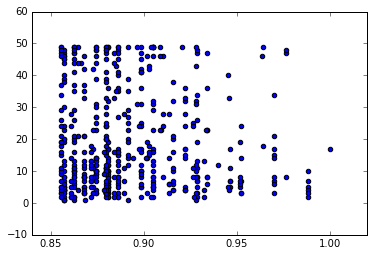

Silt


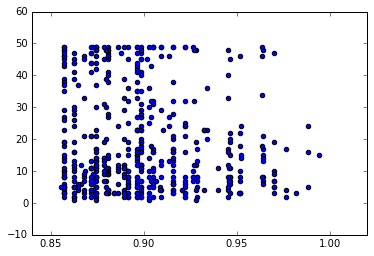

Tmax-July


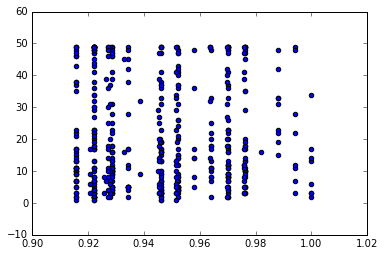

Tmin-Jan


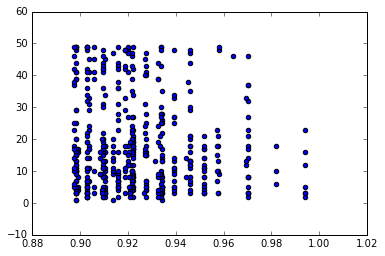

WC15Bar


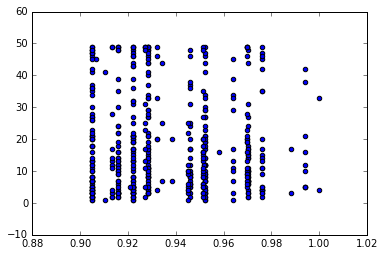

WC3rdbar


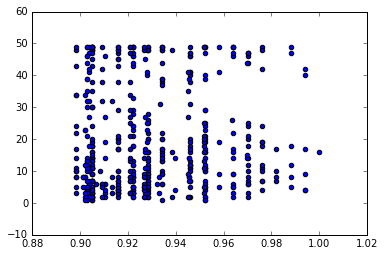

In [243]:
#make scatters 
for env in abscorr:
    print env
    abscorr.sort_values(by=env,ascending=0,inplace=True)
    f00 = pd.DataFrame(abscorr[env][abscorr.index[0:500]])
    H00 = pd.DataFrame(Habscorr['bin'][H.index.isin(f00.index)])
    plt.scatter(f00[env].tolist(),H00['bin'].tolist())
    plt.show()

Tmin-Jan


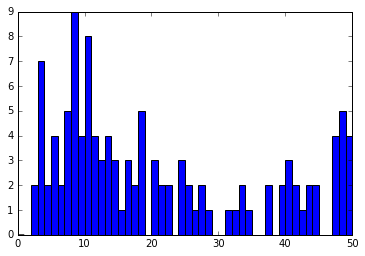

Ann-ppt


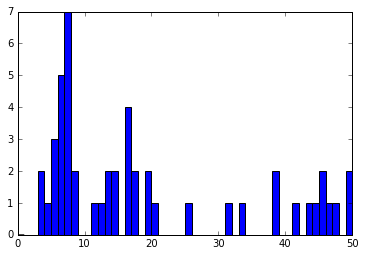

CEC


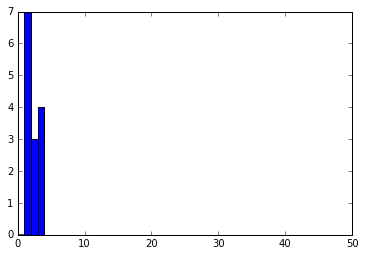

AWS0-25


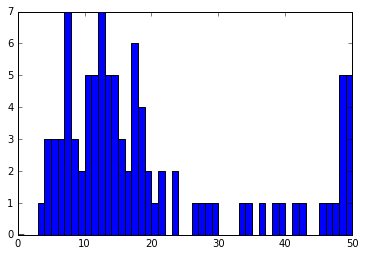

AWS0-50


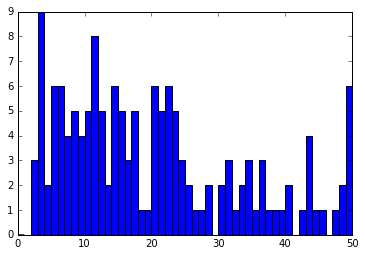

Rock-cov


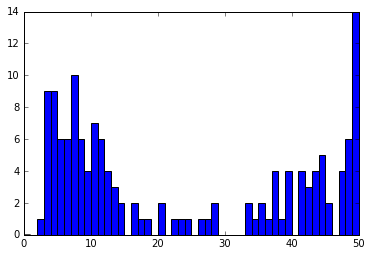

Tmax-July


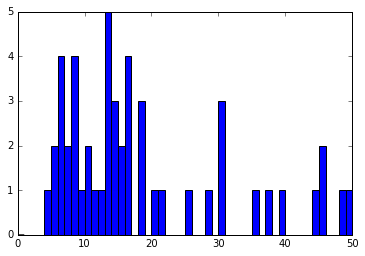

WC3rdbar


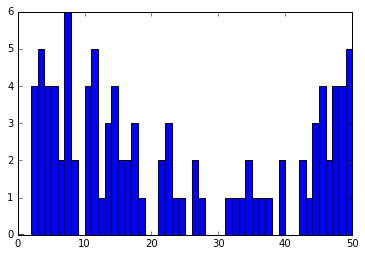

Silt


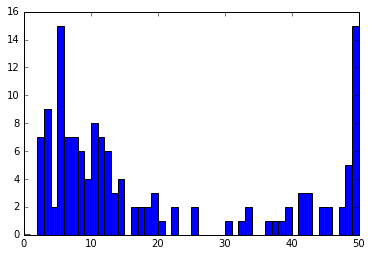

Lon


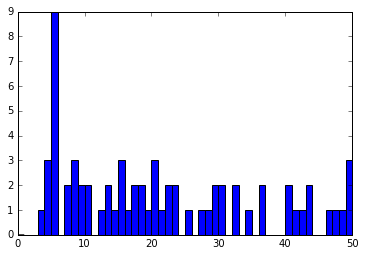

Sand


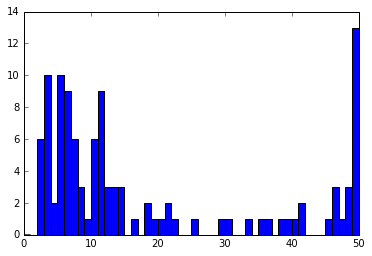

Max-rad-input


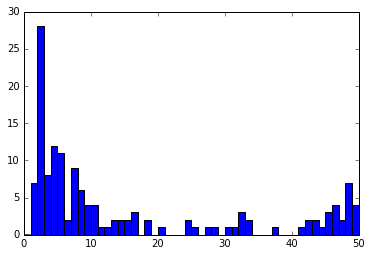

Elev


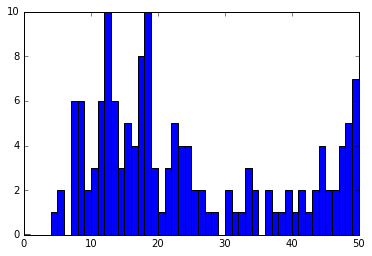

Clay


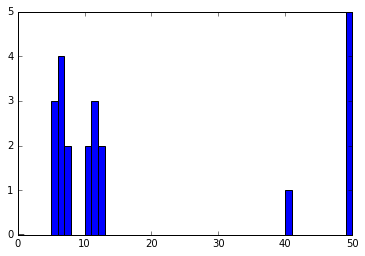

Lat


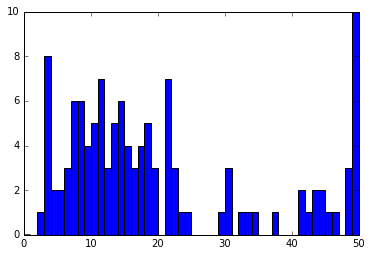

GDD-May


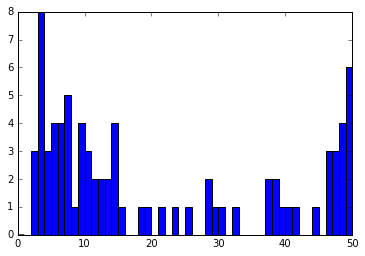

GDD-Aug


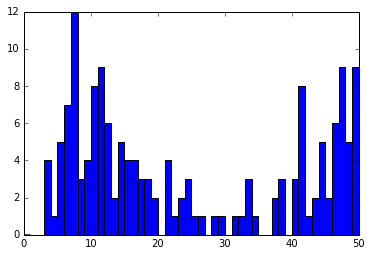

WC15Bar


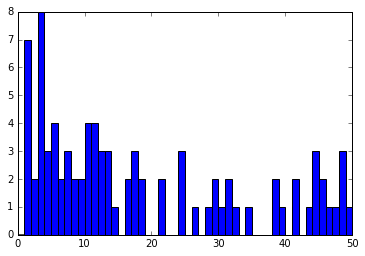

In [74]:
#make histograms of Hexp for SNPs correlated to env without correction for structure
for env in corrdict:
    df = pd.DataFrame(H[H.index.isin(corrdict[env])])
    print env
    plt.hist(df['bin'],bins=np.arange(0,51,1))
    plt.show()

Tmin-Jan 116


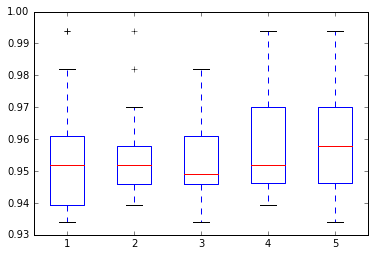

Ann-ppt 49


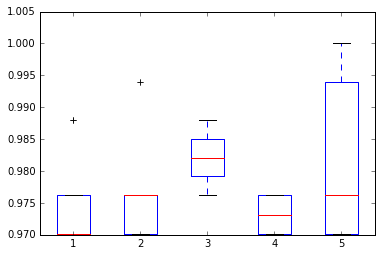

CEC 14


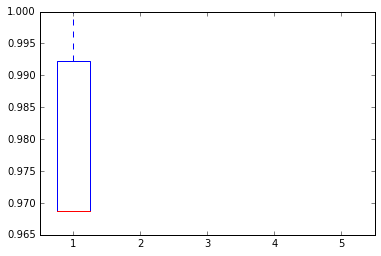

AWS0-25 95


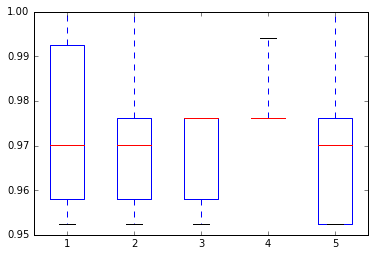

AWS0-50 147


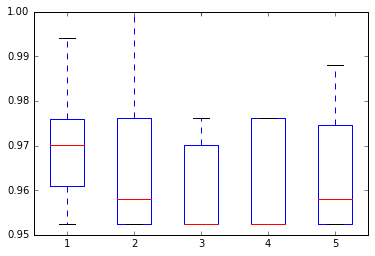

Rock-cov 143


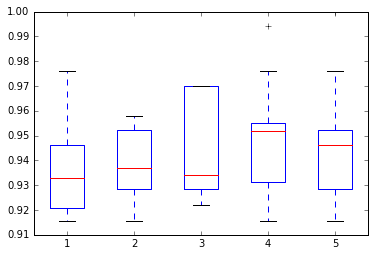

Tmax-July 50


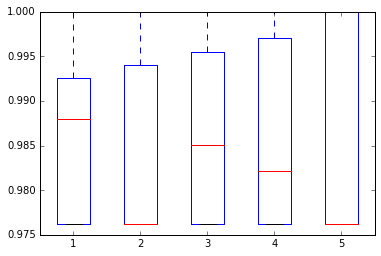

WC3rdbar 97


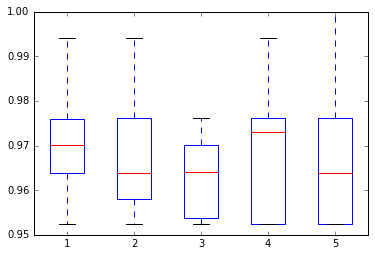

Silt 140


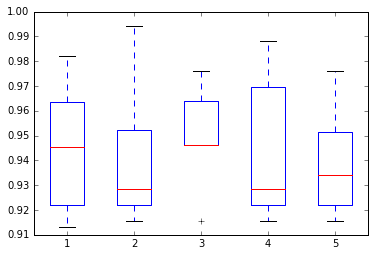

Lon 67


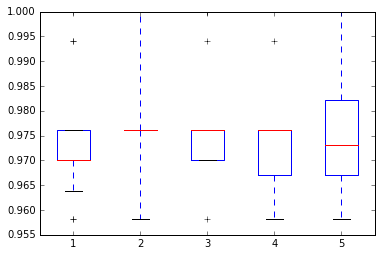

Sand 111


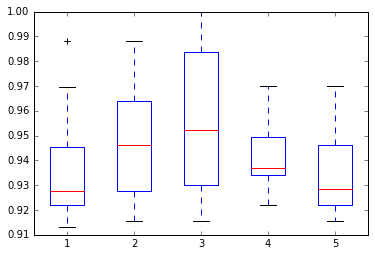

Max-rad-input 144


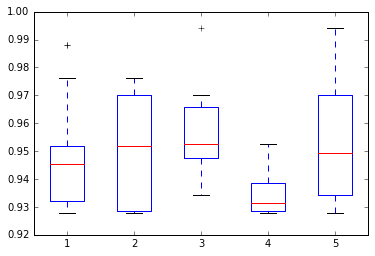

Elev 143


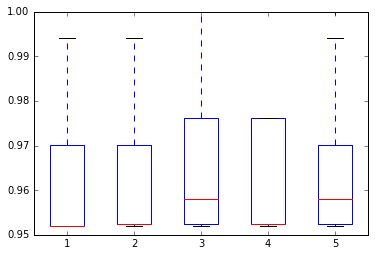

Clay 22


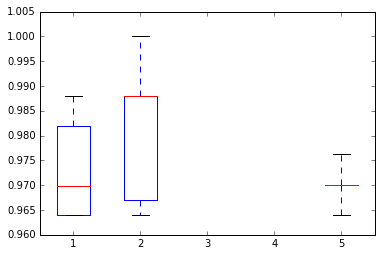

Lat 119


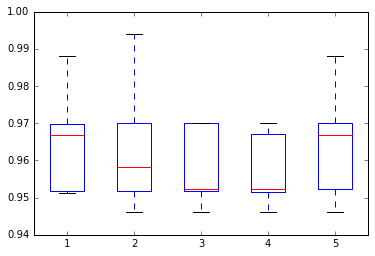

GDD-May 80


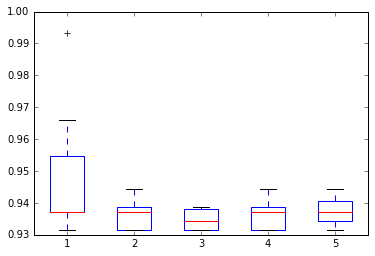

GDD-Aug 157


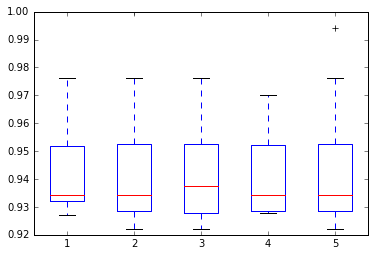

WC15Bar 86


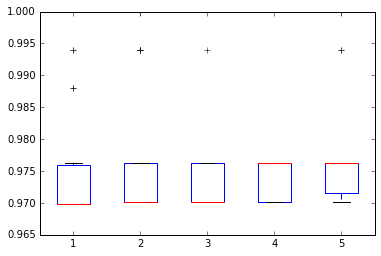

In [99]:
#make box plots
ulims = [10,20,30,40,50]
llims = [0,10,20,30,40]
for env in corrdict:
    df = pd.DataFrame(H[H.index.isin(corrdict[env])]) #get bins
    df1 = pd.DataFrame(abscorr[env]) #get rhos
    df = pd.merge(df1,df,left_index=True,right_index=True)
    boxes=[]
    count = 0
    for lim in ulims:
        df2 = pd.DataFrame(df[df['bin']<ulims[count]])
        df3 = pd.DataFrame(df2[df2['bin']>=llims[count]])
        boxes.append(df3[env].tolist())
        count += 1
    print env,len(corrdict[env])
    plt.boxplot(boxes)
    plt.show()

In [96]:
df.head()

,Tmin-Jan,locus,h_exp,bin
NODE_947008_length_150_cov_1.033333_113,0.957082,NODE_947008_length_150_cov_1.033333_113,0.028277,2
NODE_559847_length_106_cov_3.405660_112,0.957082,NODE_559847_length_106_cov_3.405660_112,0.028277,2
NODE_721449_length_98_cov_3.000000_63,0.957082,NODE_721449_length_98_cov_3.000000_63,0.032249,3
NODE_1614936_length_94_cov_1.723404_26,0.944945,NODE_1614936_length_94_cov_1.723404_26,0.032249,3
NODE_875099_length_93_cov_2.870968_11,0.944228,NODE_875099_length_93_cov_2.870968_11,0.032249,3


In [90]:
boxes[0].head()

,locus,h_exp,bin
NODE_947008_length_150_cov_1.033333_113,NODE_947008_length_150_cov_1.033333_113,0.028277,2
NODE_559847_length_106_cov_3.405660_112,NODE_559847_length_106_cov_3.405660_112,0.028277,2
NODE_721449_length_98_cov_3.000000_63,NODE_721449_length_98_cov_3.000000_63,0.032249,3
NODE_1614936_length_94_cov_1.723404_26,NODE_1614936_length_94_cov_1.723404_26,0.032249,3
NODE_875099_length_93_cov_2.870968_11,NODE_875099_length_93_cov_2.870968_11,0.032249,3


# bf.environfile - get the sig SNPs - this was done with the first chain only (ignore this section)

In [23]:
#get a DF that contains the names for environmental variables
envdf = pd.read_csv('/home/lindb/wbp/bayenv2/ENVIRONFILE_headerIDX.txt',header=0,index_col=0,sep='\t')
envdf.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks,Unnamed: 9
AWS0-25,-0.203570,-0.389380,-1.384005,0.474087,0.430367,0.299207,1.982420,-1.209126,NaN
AWS0-50,-0.035349,-0.578405,-1.156498,0.239933,-0.030344,0.510211,2.176919,-1.126467,NaN
Ann-ppt,1.621491,-0.620322,-1.416888,0.058608,-0.059028,0.260270,-1.124478,1.280346,NaN
CEC,-0.519958,-0.162005,-0.519958,2.565848,0.195949,-0.519958,-0.519958,-0.519958,NaN
Clay,-0.111761,-0.739189,-0.049018,2.429323,-1.209760,-0.033332,-0.017646,-0.268618,NaN


In [24]:
len(envdf.index)

18

In [25]:
#assign column value of the bf.environfile.ENVIRONFILE for each environmental variable
envDict = OrderedDict()
for i, env in enumerate(envdf.index):
    #print i,env
    envDict[env] = [(i*3),(i*3)+1,(i*3)+2]
envDict

OrderedDict([('AWS0-25', [0, 1, 2]),
             ('AWS0-50', [3, 4, 5]),
             ('Ann-ppt', [6, 7, 8]),
             ('CEC', [9, 10, 11]),
             ('Clay', [12, 13, 14]),
             ('Elev', [15, 16, 17]),
             ('GDD-Aug', [18, 19, 20]),
             ('GDD-May', [21, 22, 23]),
             ('Lat', [24, 25, 26]),
             ('Lon', [27, 28, 29]),
             ('Max-rad-input', [30, 31, 32]),
             ('Rock-cov', [33, 34, 35]),
             ('Sand', [36, 37, 38]),
             ('Silt', [39, 40, 41]),
             ('Tmax-July', [42, 43, 44]),
             ('Tmin-Jan', [45, 46, 47]),
             ('WC15Bar', [48, 49, 50]),
             ('WC3rdbar', [51, 52, 53])])

In [27]:
#get a dictionary to name columns in bf_environfile.ENVIRONFILE
orderDict = {}
orderDict[0] = 'BF'
orderDict[1] = 'rho'
orderDict[2] = 'pearson'
colDict = OrderedDict()
for env,cols in envDict.items():
    #print env,cols
    colCount = 0
    for col in cols:
        sub = '_'.join([str(env), orderDict[colCount]]) 
        colDict[col] = sub
        colCount += 1

In [28]:
#transform the bf_environfile to have indices and column names
df = pd.read_csv('/home/lindb/wbp/bayenv2/bf_environfile.ENVIRONFILE.txt.bf',header=None,sep='\t')s
loci = []
for row in df.index:
    locus = df.loc[row,0].split("/")[-1]
    loci.append(locus)
bayenv2 = df.loc[:,[x for x in df.columns[1:-1]]] #get rid of locus column and the 'blank' column at the end
bayenv2.columns = [col for col in range(len(bayenv2.columns))] #rename columns from 0 to len(columns)
bayenv2.columns = [colDict[col] for col in bayenv2.columns] #convert to BF, rho, pearson
bayenv2.index = [locus for locus in loci]
bayenv2.head()

,AWS0-25_BF,AWS0-25_rho,AWS0-25_pearson,AWS0-50_BF,AWS0-50_rho,AWS0-50_pearson,Ann-ppt_BF,Ann-ppt_rho,Ann-ppt_pearson,CEC_BF,...,Tmax-July_pearson,Tmin-Jan_BF,Tmin-Jan_rho,Tmin-Jan_pearson,WC15Bar_BF,WC15Bar_rho,WC15Bar_pearson,WC3rdbar_BF,WC3rdbar_rho,WC3rdbar_pearson
NODE_1022341_length_110_cov_1.572727_121,0.039412,-0.099499,-0.087594,0.044012,-0.091604,-0.084157,0.043089,-0.058897,0.027890,0.069205,...,-0.085162,0.030228,-0.015288,0.010594,0.052632,-0.011779,-0.063004,0.043833,0.011153,-0.047941
NODE_1022323_length_92_cov_1.141304_34,0.038105,0.082957,0.068218,0.035717,0.024561,0.048226,0.043443,-0.161030,-0.052010,0.043571,...,-0.094324,0.564850,-0.182580,-0.087993,0.039821,0.077444,0.011561,0.039301,0.056266,0.017767
NODE_1000053_length_94_cov_1.744681_25,0.069298,-0.035464,-0.032526,0.045437,-0.082832,-0.054847,0.040234,-0.063283,0.041394,0.043974,...,-0.143280,0.031764,-0.069298,-0.013922,0.044626,-0.034962,-0.072714,0.050776,-0.042607,-0.074374
NODE_1037913_length_76_cov_1.210526_45,0.151090,-0.008647,0.012484,0.088241,-0.016667,-0.004765,0.046748,-0.141600,-0.072316,0.124360,...,-0.085350,0.049883,-0.177440,-0.161130,0.050024,-0.005012,-0.030362,0.054170,0.002381,-0.023603
NODE_1037972_length_59_cov_1.237288_42,0.072104,0.013659,0.005138,0.077983,-0.025313,-0.017297,0.047167,-0.052632,0.054850,0.055690,...,-0.121790,0.063020,-0.035589,0.008212,0.056250,0.065789,-0.028304,0.050188,0.050501,-0.009588


In [51]:
pd.DataFrame(bayenv2.loc['NODE_335159_length_90_cov_1.000000_19',:]).T

,AWS0-25_BF,AWS0-25_rho,AWS0-25_pearson,AWS0-50_BF,AWS0-50_rho,AWS0-50_pearson,Ann-ppt_BF,Ann-ppt_rho,Ann-ppt_pearson,CEC_BF,...,Tmax-July_pearson,Tmin-Jan_BF,Tmin-Jan_rho,Tmin-Jan_pearson,WC15Bar_BF,WC15Bar_rho,WC15Bar_pearson,WC3rdbar_BF,WC3rdbar_rho,WC3rdbar_pearson
NODE_335159_length_90_cov_1.000000_19,625.36,0.014536,0.002028,355.82,0.019799,0.003,0.044888,-0.046742,0.052339,0.048658,...,-0.11118,0.052885,-0.048622,0.003231,7.0281,0.09599,0.016187,1.0747,0.095739,0.023289


In [29]:
len(np.unique(bayenv2.index).tolist())

116231

In [45]:
#get a rho df
rhos = [col for col in bayenv2.columns if 'rho' in col]
rhodf = bayenv2.loc[:,[col for col in rhos]]
filE = '/home/lindb/wbp/bayenv2/results/rho_all.txt'
rhodf.to_csv(filE,header=True,index=True,sep='\t')
rhodf.head()

,AWS0-25_rho,AWS0-50_rho,Ann-ppt_rho,CEC_rho,Clay_rho,Elev_rho,GDD-Aug_rho,GDD-May_rho,Lat_rho,Lon_rho,Max-rad-input_rho,Rock-cov_rho,Sand_rho,Silt_rho,Tmax-July_rho,Tmin-Jan_rho,WC15Bar_rho,WC3rdbar_rho
NODE_1022341_length_110_cov_1.572727_121,-0.099499,-0.091604,-0.058897,0.10050,0.089474,0.058020,-0.036341,0.065414,-0.031203,-0.002005,0.096491,-0.023434,0.009900,-0.011404,-0.079198,-0.015288,-0.011779,0.011153
NODE_1022323_length_92_cov_1.141304_34,0.082957,0.024561,-0.161030,0.23246,0.183710,0.072431,-0.012782,0.116040,-0.071178,0.052005,0.041353,-0.164660,-0.089223,0.128320,-0.065789,-0.182580,0.077444,0.056266
NODE_1000053_length_94_cov_1.744681_25,-0.035464,-0.082832,-0.063283,0.18258,0.063910,0.042732,-0.027444,0.093860,-0.102380,-0.019298,0.025188,-0.107270,0.020426,-0.022306,-0.150250,-0.069298,-0.034962,-0.042607
NODE_1037913_length_76_cov_1.210526_45,-0.008647,-0.016667,-0.141600,0.18960,0.082331,0.156640,-0.140600,0.052632,-0.077569,0.074687,0.061153,-0.126070,-0.024436,0.058271,-0.076817,-0.177440,-0.005012,0.002381
NODE_1037972_length_59_cov_1.237288_42,0.013659,-0.025313,-0.052632,0.16942,0.113530,0.003759,0.020050,0.115660,-0.011404,-0.029825,0.158020,-0.137720,-0.010401,0.026566,-0.100630,-0.035589,0.065789,0.050501


In [49]:
#get absolute values of rhos to rank them
max(abs(rhodf['AWS0-25_rho']))

0.30163000000000001

In [50]:
len(rhodf.index)

116231

In [81]:
#get a dictionary with the 0.01% (1162) largest rhos for each env
rho2 = pd.DataFrame(abs(rhodf))
rhoDict = OrderedDict() #k = env, val = list(top_loci)
for env in rho2.columns:
    sorts = pd.DataFrame(rho2.sort_values(by=env,ascending=0))
    rhoDict[env] = sorts.index[:1162] #top loci

In [69]:
#get a BF df
bfs = [col for col in bayenv2.columns if '_BF' in col]
bfdf = bayenv2.loc[:,[col for col in bfs]]
filE = '/home/lindb/wbp/bayenv2/results/BF_all.txt'
bfdf.to_csv(filE,header=True,index=True,sep='\t')
bfdf.head()

,AWS0-25_BF,AWS0-50_BF,Ann-ppt_BF,CEC_BF,Clay_BF,Elev_BF,GDD-Aug_BF,GDD-May_BF,Lat_BF,Lon_BF,Max-rad-input_BF,Rock-cov_BF,Sand_BF,Silt_BF,Tmax-July_BF,Tmin-Jan_BF,WC15Bar_BF,WC3rdbar_BF
NODE_1022341_length_110_cov_1.572727_121,0.039412,0.044012,0.043089,0.069205,0.065406,0.040421,0.026872,0.035479,0.048453,0.040624,0.059265,0.060311,0.050194,0.052312,0.043438,0.030228,0.052632,0.043833
NODE_1022323_length_92_cov_1.141304_34,0.038105,0.035717,0.043443,0.043571,0.032902,0.056315,0.053381,0.036369,0.041288,0.046238,0.036812,0.047657,0.031352,0.029938,0.046391,0.564850,0.039821,0.039301
NODE_1000053_length_94_cov_1.744681_25,0.069298,0.045437,0.040234,0.043974,0.031790,0.035175,0.039015,0.030961,0.036205,0.107700,0.060989,0.050068,0.040488,0.047824,0.301050,0.031764,0.044626,0.050776
NODE_1037913_length_76_cov_1.210526_45,0.151090,0.088241,0.046748,0.124360,0.041694,0.060639,0.074511,0.119890,0.042254,0.041710,0.044512,0.071720,0.067409,0.058143,0.044706,0.049883,0.050024,0.054170
NODE_1037972_length_59_cov_1.237288_42,0.072104,0.077983,0.047167,0.055690,0.067452,0.061527,0.051156,0.050269,0.071740,0.044611,0.086973,0.040416,0.083884,0.073501,0.038904,0.063020,0.056250,0.050188


In [7]:
bfdf = pd.read_csv('/home/lindb/wbp/bayenv2/results/BF_all.txt',header=0,index_col=0,sep='\t')
bfdf.head()

,AWS0-25_BF,AWS0-50_BF,Ann-ppt_BF,CEC_BF,Clay_BF,Elev_BF,GDD-Aug_BF,GDD-May_BF,Lat_BF,Lon_BF,Max-rad-input_BF,Rock-cov_BF,Sand_BF,Silt_BF,Tmax-July_BF,Tmin-Jan_BF,WC15Bar_BF,WC3rdbar_BF
NODE_1022341_length_110_cov_1.572727_121,0.039412,0.044012,0.043089,0.069205,0.065406,0.040421,0.026872,0.035479,0.048453,0.040624,0.059265,0.060311,0.050194,0.052312,0.043438,0.030228,0.052632,0.043833
NODE_1022323_length_92_cov_1.141304_34,0.038105,0.035717,0.043443,0.043571,0.032902,0.056315,0.053381,0.036369,0.041288,0.046238,0.036812,0.047657,0.031352,0.029938,0.046391,0.564850,0.039821,0.039301
NODE_1000053_length_94_cov_1.744681_25,0.069298,0.045437,0.040234,0.043974,0.031790,0.035175,0.039015,0.030961,0.036205,0.107700,0.060989,0.050068,0.040488,0.047824,0.301050,0.031764,0.044626,0.050776
NODE_1037913_length_76_cov_1.210526_45,0.151090,0.088241,0.046748,0.124360,0.041694,0.060639,0.074511,0.119890,0.042254,0.041710,0.044512,0.071720,0.067409,0.058143,0.044706,0.049883,0.050024,0.054170
NODE_1037972_length_59_cov_1.237288_42,0.072104,0.077983,0.047167,0.055690,0.067452,0.061527,0.051156,0.050269,0.071740,0.044611,0.086973,0.040416,0.083884,0.073501,0.038904,0.063020,0.056250,0.050188


In [82]:
#get a dictionary with the 0.01% (1162) largest BFs for each env
bf2 = pd.DataFrame(abs(bfdf))
bfDict = OrderedDict()
for env in bf2.columns:
    sorts = pd.DataFrame(bf2.sort_values(by=env,ascending=0))
    bfDict[env] = sorts.index[:1162]

In [83]:
#get the intersection of loci between top rhos and top BFs
intDict = OrderedDict()
for env in envDict.keys():
    bfkey = env+'_BF'
    rhokey = env+'_rho'
    intDict[env] = list(set(bfDict[bfkey]).intersection(set(rhoDict[rhokey])))

In [84]:
#see how many 'significant' SNPs for each env variable
for env in intDict.keys():
    print env,len(intDict[env])

AWS0-25 24
AWS0-50 33
Ann-ppt 22
CEC 18
Clay 24
Elev 44
GDD-Aug 33
GDD-May 33
Lat 43
Lon 30
Max-rad-input 47
Rock-cov 42
Sand 24
Silt 36
Tmax-July 19
Tmin-Jan 36
WC15Bar 31
WC3rdbar 29


In [89]:
min([len(intDict[env]) for env in intDict.keys()]),max([len(intDict[env]) for env in intDict.keys()])

(18, 47)

In [95]:
#write out files
for env in intDict.keys():
    filE = '/home/lindb/wbp/bayenv2/results/rhoBF_intersection_%s.txt' % env
    df = pd.DataFrame(intDict[env])
    df.columns = [env]
    df.to_csv(filE,header=True,index=False)
df.head()

,WC3rdbar
0,NODE_1012908_length_95_cov_1.884210_28
1,NODE_972489_length_95_cov_1.936842_13
2,NODE_915632_length_49_cov_1.469388_49
3,NODE_1324978_length_53_cov_1.000000_47
4,NODE_1769460_length_97_cov_1.010309_69


In [96]:
intDict.keys()

['AWS0-25',
 'AWS0-50',
 'Ann-ppt',
 'CEC',
 'Clay',
 'Elev',
 'GDD-Aug',
 'GDD-May',
 'Lat',
 'Lon',
 'Max-rad-input',
 'Rock-cov',
 'Sand',
 'Silt',
 'Tmax-July',
 'Tmin-Jan',
 'WC15Bar',
 'WC3rdbar']

# Get BFs >= 3

In [222]:
bfdf.head()

,AWS0-25_BF,AWS0-50_BF,Ann-ppt_BF,CEC_BF,Clay_BF,Elev_BF,GDD-Aug_BF,GDD-May_BF,Lat_BF,Lon_BF,Max-rad-input_BF,Rock-cov_BF,Sand_BF,Silt_BF,Tmax-July_BF,Tmin-Jan_BF,WC15Bar_BF,WC3rdbar_BF
NODE_1022341_length_110_cov_1.572727_121,0.039412,0.044012,0.043089,0.069205,0.065406,0.040421,0.026872,0.035479,0.048453,0.040624,0.059265,0.060311,0.050194,0.052312,0.043438,0.030228,0.052632,0.043833
NODE_1022323_length_92_cov_1.141304_34,0.038105,0.035717,0.043443,0.043571,0.032902,0.056315,0.053381,0.036369,0.041288,0.046238,0.036812,0.047657,0.031352,0.029938,0.046391,0.564850,0.039821,0.039301
NODE_1000053_length_94_cov_1.744681_25,0.069298,0.045437,0.040234,0.043974,0.031790,0.035175,0.039015,0.030961,0.036205,0.107700,0.060989,0.050068,0.040488,0.047824,0.301050,0.031764,0.044626,0.050776
NODE_1037913_length_76_cov_1.210526_45,0.151090,0.088241,0.046748,0.124360,0.041694,0.060639,0.074511,0.119890,0.042254,0.041710,0.044512,0.071720,0.067409,0.058143,0.044706,0.049883,0.050024,0.054170
NODE_1037972_length_59_cov_1.237288_42,0.072104,0.077983,0.047167,0.055690,0.067452,0.061527,0.051156,0.050269,0.071740,0.044611,0.086973,0.040416,0.083884,0.073501,0.038904,0.063020,0.056250,0.050188


In [8]:
#get the loci to run bayenv2 null runs
nullloci = [] #keep track of the loci
best = []
worst = []
for envbf in bfdf.columns:
    #get all BFs greater than or equal to 3
    env = envbf.split("_")[0]
    data = pd.DataFrame(bfdf[envbf])
    new = pd.DataFrame(data[data[envbf] >= 3] )
    [best.append(locus) for locus in new.index if locus not in best]
    
    #get 10 of the worst BFs
    bad    = pd.DataFrame(data[data[envbf]<=3])
    badder = pd.DataFrame(bad.sort_values(by=envbf,ascending=1))
    badder = badder[badder.index.isin(badder.index[:10])]
    [worst.append(locus) for locus in badder.index if locus not in worst]
    
    #concat the two dataframes
    catd = pd.concat([badder,new])
    catd.sort_values(by=envbf,ascending=1,inplace=True)
    
    #add loci to nullloci list
    [nullloci.append(locus) for locus in catd.index if locus not in nullloci]
    
    filE = '/home/lindb/wbp/bayenv2/results/%s_bfgreaterthan3and10worst.txt' % env
    catd.to_csv(filE,header=True,index=True,sep='\t')
    
    
    print env,len(catd.index),len(new.index),len(badder.index),len(bad.index)

AWS0-25 146 136 10 116095
AWS0-50 144 134 10 116097
Ann-ppt 121 111 10 116120
CEC 155 145 10 116086
Clay 143 133 10 116098
Elev 142 132 10 116099
GDD-Aug 162 152 10 116079
GDD-May 140 130 10 116101
Lat 108 98 10 116133
Lon 133 123 10 116108
Max-rad-input 130 120 10 116111
Rock-cov 130 120 10 116111
Sand 117 107 10 116124
Silt 127 117 10 116114
Tmax-July 138 128 10 116103
Tmin-Jan 140 130 10 116101
WC15Bar 143 133 10 116098
WC3rdbar 169 159 10 116072


In [18]:
new.sort_values(by='WC3rdbar_BF',ascending=1).head()

,WC3rdbar_BF
NODE_1639246_length_96_cov_1.000000_54,3.0227
NODE_1827590_length_97_cov_1.010309_95,3.0255
NODE_801495_length_93_cov_1.043011_98,3.0348
NODE_1768702_length_98_cov_2.000000_29,3.0532
NODE_1245880_length_98_cov_2.000000_120,3.0540


In [20]:
catd.head()

,WC3rdbar_BF
NODE_1157581_length_98_cov_2.000000_65,0.020211
NODE_1984741_length_126_cov_1.079365_106,0.021756
NODE_1899121_length_96_cov_1.000000_96,0.022275
NODE_1963464_length_94_cov_1.000000_96,0.022540
NODE_1020727_length_92_cov_1.043478_23,0.022608


In [19]:
len(new.index)

159

In [9]:
len(best),len(worst),len(nullloci)

(1873, 130, 2003)

In [285]:
nulls = pd.DataFrame(nullloci)
nulls.columns = ['topandlowestBFs']
filE = '/home/lindb/wbp/bayenv2/results/uniq_loci_bfgreaterthan3and10worst.txt'
nulls.to_csv(filE,header=True,index=False,sep='\t')
nulls.head()

,topandlowestBFs
0,NODE_1386958_length_95_cov_1.010526_23
1,NODE_1157581_length_98_cov_2.000000_65
2,NODE_1918081_length_96_cov_1.020833_21
3,NODE_1699474_length_93_cov_1.021505_62
4,NODE_572919_length_82_cov_1.597561_54


In [286]:
len(nulls)

2003

In [10]:
best = pd.DataFrame(best)
best.columns = ['BF>=3']
filE = '/home/lindb/wbp/bayenv2/results/best_loci_bfgreaterthan3without10worst.txt'
best.to_csv(filE,header=True,index=False,sep='\t')
best.head()

,BF>=3
0,NODE_1002609_length_96_cov_6.687500_11
1,NODE_1015203_length_91_cov_1.000000_32
2,NODE_1031333_length_98_cov_2.908163_110
3,NODE_1062938_length_98_cov_2.000000_38
4,NODE_1065067_length_74_cov_1.027027_39


In [11]:
worst = pd.DataFrame(worst)
worst.columns = ['worstBF']
filE = '/home/lindb/wbp/bayenv2/results/worst_loci_bfgreaterthan3without10worst.txt'
worst.to_csv(filE,header=True,index=False,sep='\t')
worst.head()

,worstBF
0,NODE_1386958_length_95_cov_1.010526_23
1,NODE_1157581_length_98_cov_2.000000_65
2,NODE_1918081_length_96_cov_1.020833_21
3,NODE_1699474_length_93_cov_1.021505_62
4,NODE_572919_length_82_cov_1.597561_54
